In [1]:
from qiskit import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import IBMQ, Aer, execute,assemble,QuantumCircuit, aqua
from qiskit.visualization import plot_histogram, plot_bloch_vector, plot_bloch_multivector
from qiskit.quantum_info import Statevector
from qiskit.extensions import *
provider = IBMQ.load_account()

from qiskit.quantum_info import random_unitary

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math
from math import pi, sqrt
from qiskit.circuit import Parameter

from random import seed
from random import random
import cmath

C:\Users\Saesun Kim\anaconda3\envs\name_of_my_env\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import random

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

In [3]:
import random
from random import seed
from random import random

import numpy as np
import matplotlib.pyplot as plt

from numpy import where
from collections import Counter
from sklearn.datasets import make_blobs
from matplotlib import pyplot

import numpy as np
import matplotlib.pyplot as plt
from sklearn import mixture
from sklearn.neighbors import KernelDensity

import random

In [4]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

def readfile(name):
    f = open (name , 'r')
    l = []
    l = [line.split() for line in f]
    l = np.array(l)
    return l

def strtoeval1(file):
    tt=[]
    for i in range(len(file)):
        tt.append([eval(file[i][0]),eval(file[i][1])])
    return tt

def strtoeval2(file):
    tt=[]
    for i in range(len(file)):
        tt.append(int(eval(file[i][0])))
    return tt

In [5]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
filePath=r'C:\Users\Saesun Kim\Documents\GitHub\Quantum_Machine_Learning_Express\dataset\data1a.txt';
data1a = np.array(strtoeval1(readfile(filePath)))
data1alabel = np.array(strtoeval2(readfile(filePath)))
ct=Counter(data1alabel)



from sklearn.utils import shuffle

a_shuffled, b_shuffled = shuffle(data1a, data1alabel)
a_shuffled[0]

array([0.73, 0.5 ])

In [6]:
def cN(eqs,string):
    if string in eqs:
        return eqs[string]   
    else:
        return 0

In [7]:
data1Path = r'../dataset/data1a.txt'
data1Label = r'../dataset/data1alabel.txt'

dataCoords = np.loadtxt(data1Path)
dataLabels = np.loadtxt(data1Label)

In [8]:
# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)

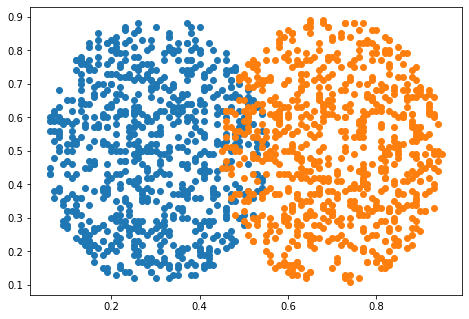

In [9]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 0)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 0)])[1::2], ls='', marker='o')

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 1)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 1)])[1::2], ls='', marker='o')

In [25]:
from IPython.display import Image

# Loss function Two-Qubit

Loss is calculated with a simple two-qubit gate. First, the data is embedded into Rx rotation with pi/4 rotation of Ry and Rz. The parameterized quantum circuit is placed after the embedding. We used same structure of the circuit1 from the paper to check the convergence.

![Two-Qubits Example](Two-qubits.png)

In [182]:
def embed(qc,qr,theta,i):
    qc.rx(dataCoords[i][0],qr[0])
    qc.rx(dataCoords[i][1],qr[1])
    
    qc.ry(pi/4,qr[:])
    qc.rz(pi/4,qr[:])
    
    return qc

def circuit1(qc,qr,theta,i):
    count=0;

    for i in range(2):
        qc.rx(theta[count],qr[i])
        count=count+1
    for i in range(2):
        qc.rz(theta[count],qr[i])
        count=count+1
    
    return qc

def QCrun(theta,i,nshot):
    backend = Aer.get_backend('qasm_simulator')
    qr = QuantumRegister(2)
    cr = ClassicalRegister(2)
    qc = QuantumCircuit(qr,cr)

    qc=embed(qc,qr,theta,i)
    qc=circuit1(qc,qr,theta,i)


    qc.measure(qr[:],cr[:])
    job = execute(qc, backend, shots=nshot)
    result = job.result()
    count =result.get_counts()
    lm=-1*(cN(count,'00')+cN(count,'01'))
    lp=1*(cN(count,'10')+cN(count,'11'))
    
    return (lm+lp)/nshot
    
def loss(y,i):
    return abs(y-2*(b_shuffled[i]-0.5))
    

def loss2qubit(theta,i):    
    #i th data
    #parameter
    #return loss
    
    nshot=1000;
    y=QCrun(theta,i,nshot)
    l1=loss(y,i)
   
    return l1
loss2qubit([1,1,1,1],10)

0.702

## [SPSA method](https://en.wikipedia.org/wiki/Simultaneous_perturbation_stochastic_approximation)

SPSA is an algorithm used in numerical optimization.

Consider a loss function $L(\mathbf{x})$. In order to optimize $L$, SPSA iteratively optimizes the parameters of the loss function according to the following update rule:

$$\mathbf{y}_{n+1} = \mathbf{y}_{n} - a_{n}\widehat{\Delta L}_{n}(\mathbf{y}_{n}),$$

where $\widehat{\Delta L}_{n}(\mathbf{y}_{n}))$ is an estimate of the gradient at $\mathbf{y}_{n}$.

How SPSA calculates that gradient is by using a finite-difference rule on random perturbations of component of the parameter vector.
    $$\left( \widehat{\Delta L}_{n}(\mathbf{y}_{n}))\right)_{j} = \frac{L(\mathbf{y}_{n} + c_{n}\boldsymbol{\Delta}_{n}) - L(\mathbf{y}_{n} - c_{n}\boldsymbol{\Delta}_{n}) }{c_{n}\left(\boldsymbol{\Delta}_{n}\right)_{j}}$$
    
That is at each iteration, SPSA generates a random perturbation $\boldsymbol{\Delta}_{n}$, and does a finite-difference rule with that perturbation.

In order for the algorithm to converge, the random perturbation $\boldsymbol{\Delta}_{n}$ and finite-difference coefficients $c_{n}$ must satisfy certain properties (see the Wikipedia article linked to in the title). Importantly $c_{n}$ must tend to 0 as $n$ increases, and the size of the random fluctuations $\boldsymbol{\Delta}_{n}$ must also be bounded.

According to the wikipedia article, the coefficients $a_{n}$ and $c_{n}$ should look something like

$$c_{n} = \frac{c}{n^\gamma}~~\text{and}~~a_{n} = \frac{a}{n}.$$

In [183]:
def SPSA_gradient(loss, currentParams, gradientCoefficient):
    r'''Computes an estimator of the gradient using the procedure
    described in the SPSA algorithm.
    
    Inputs:
        loss: The loss function
        currentParams: The current value for the parameters
        gradientCoefficient: The coefficient c_n, which controls how much the current parameters are
                                               perturbed when computing the gradient
    
    Returns:
        gradient: The SPSA-based gradient of the loss function at currentParams'''
    
    numParams = len(currentParams)
    # Generate a random perturbation using the Rademacher distribution
    randomPerturbation = 2*np.random.binomial(1, .5, size=numParams) - 1
    
    gradient = (loss(currentParams + gradientCoefficient*randomPerturbation,1) - loss(currentParams - gradientCoefficient*randomPerturbation,1))\
                        /(gradientCoefficient*randomPerturbation)
    
    return gradient

def SPSA_update(loss, currentParams, updateCoefficient, gradientCoefficient):
    r'''Performs a parameter update according to the SPSA approach.
    
    NOTE: This function isn't aware of the notion of iterations, or anything of that sort.
    
    Inputs:
        loss: The loss function
        currentParams: The current value for the parameters
        updateCoefficient: The coefficient a_n, which controls how the current parameters are updated
                                            when including the gradient
        gradientCoefficient: The coefficient c_n, which controls how much the current parameters are
                                               perturbed when computing the gradient

    Returns:
        The updated parameter values'''
    
    grad = SPSA_gradient(loss, currentParams, gradientCoefficient)
    
    return currentParams - updateCoefficient*grad

# Test the convergence of first data point

To have sanity check, we take first data and run the optimization.

In [184]:

c = 3
a = 1

# Make some lists to keep track of things
lossList = []
coeffsList = []
paramsList = []

# Set starting values for the parameters
np.random.seed(0)
currentParams = np.random.uniform(size=4)

# Do the updates
for j in range(100):
    cj = c/(j+1)**.5
    aj = a/(j+1)

    lossList.append(loss2qubit(currentParams,1))
    coeffsList.append((cj, aj))
    paramsList.append(currentParams)
    
    currentParams = SPSA_update(loss2qubit, currentParams, aj, cj)

Text(0.5, 1.0, 'Parameter values')

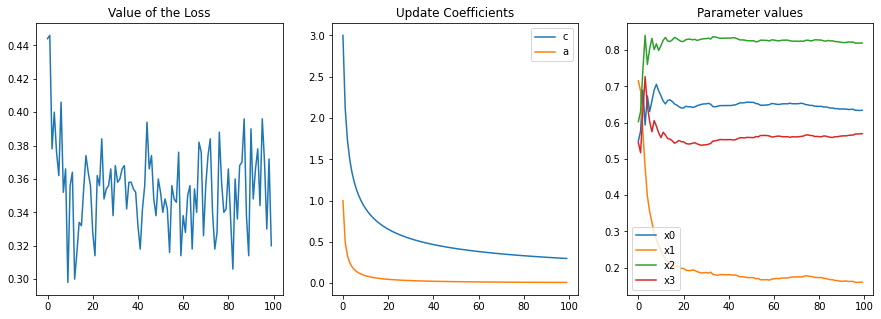

In [181]:
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(1, 3, 1)
ax.plot(lossList)
ax.set_title('Value of the Loss')

ax = fig.add_subplot(1, 3, 2)
ax.plot([X[0] for X in coeffsList], label='c')
ax.plot([X[1] for X in coeffsList], label='a')
ax.set_title('Update Coefficients')
ax.legend(loc=0)

ax = fig.add_subplot(1, 3, 3)
for j in range(4):
    ax.plot([X[j] for X in paramsList], label='x{0}'.format(j))
ax.legend(loc=0)
ax.set_title('Parameter values')

# Large data

In [189]:
def SPSA_gradient(loss, currentParams, gradientCoefficient):
    r'''Computes an estimator of the gradient using the procedure
    described in the SPSA algorithm.
    
    Inputs:
        loss: The loss function
        currentParams: The current value for the parameters
        gradientCoefficient: The coefficient c_n, which controls how much the current parameters are
                                               perturbed when computing the gradient
    
    Returns:
        gradient: The SPSA-based gradient of the loss function at currentParams'''
    
    numParams = len(currentParams)
    # Generate a random perturbation using the Rademacher distribution
    randomPerturbation = 2*np.random.binomial(1, .5, size=numParams) - 1
    
    gradient = (loss(currentParams + gradientCoefficient*randomPerturbation) - loss(currentParams - gradientCoefficient*randomPerturbation))\
                        /(gradientCoefficient*randomPerturbation)
    
    return gradient

def SPSA_update(loss, currentParams, updateCoefficient, gradientCoefficient):
    r'''Performs a parameter update according to the SPSA approach.
    
    NOTE: This function isn't aware of the notion of iterations, or anything of that sort.
    
    Inputs:
        loss: The loss function
        currentParams: The current value for the parameters
        updateCoefficient: The coefficient a_n, which controls how the current parameters are updated
                                            when including the gradient
        gradientCoefficient: The coefficient c_n, which controls how much the current parameters are
                                               perturbed when computing the gradient

    Returns:
        The updated parameter values'''
    
    grad = SPSA_gradient(loss, currentParams, gradientCoefficient)
    
    return currentParams - updateCoefficient*grad

In [190]:
def embed(qc,qr,theta,i):
    qc.rx(dataCoords[i][0],qr[0])
    qc.rx(dataCoords[i][1],qr[1])
    
    qc.ry(pi/4,qr[:])
    qc.rz(pi/4,qr[:])
    return qc

def circuit1(qc,qr,theta):
    count=0;
    for i in range(2):
        qc.rx(theta[count],qr[i])
        count=count+1
    for i in range(2):
        qc.rz(theta[count],qr[i])
        count=count+1
    qc.cz(qr[0],qr[1])
    return qc

def QCrun(theta,i,nshot):
    backend = Aer.get_backend('qasm_simulator')
    qr = QuantumRegister(2)
    cr = ClassicalRegister(2)
    qc = QuantumCircuit(qr,cr)

    qc=embed(qc,qr,theta,i)
    qc=circuit1(qc,qr,theta)


    qc.measure(qr[:],cr[:])
    job = execute(qc, backend, shots=nshot)
    result = job.result()
    count =result.get_counts()
    lm=-1*(cN(count,'00')+cN(count,'01'))
    lp=1*(cN(count,'10')+cN(count,'11'))
    
    return (lm+lp)/nshot
    
def loss(y,i):
    return abs(y-2*(b_shuffled[i]-0.5))
    

def loss2qubit(theta,i):    
    #i th data
    #parameter
    #return loss
    
    nshot=1000;
    y=QCrun(theta,i,nshot)
    l1=loss(y,i)
   
    return l1

def result(theta,i):    
    #i th data
    #parameter
    #return loss
    
    nshot=1;
    y=QCrun(theta,i,nshot)
   
    return y


result([1,1,1,1],10)

1.0

In [206]:
L = lambda x: np.sum([loss2qubit(currentParams,j) for j in data_ixs])/len(data_ixs) + .05*np.linalg.norm(x[:2])**2

In [210]:
L(1)

TypeError: 'int' object is not subscriptable

In [203]:

c = 3
a = 1

# Make some lists to keep track of things
lossList = []
coeffsList = []
paramsList =[]
accuracyList = []

# Set starting values for the parameters
np.random.seed(2)
currentParams = np.random.uniform(size=4)

# Do the updates
for j in range(100):
    
    cj = c/(j+1)**.5
    aj = a/(j+1)
    
    # Grab a subset of the data for minibatching
    #np.random.seed(j)
    np.random.seed(1)
    #data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
    data_ixs = np.random.choice(len(shuffled_data), size=1)
    
    # Evaluate the loss over that subset
    # We include a regularization term at the end 
    L = lambda x: np.sum([loss2qubit(currentParams,j) for j in data_ixs])/len(data_ixs) + .05*np.linalg.norm(x[:2])**2
    
    lossList.append(L(currentParams))
    coeffsList.append((cj, aj))
    paramsList.append(currentParams)
    #accuracyList.append(np.sum([result(currentParams,j) ==d[1] for d in data])/len(data))
    currentParams = SPSA_update(L, currentParams, aj, cj)

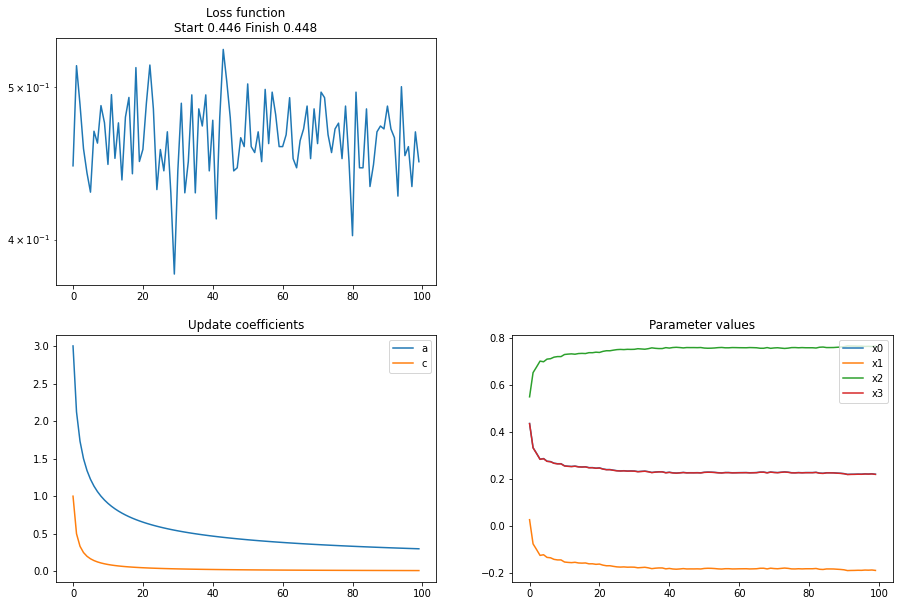

In [204]:
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(2, 2, 1)
ax.plot(lossList)
ax.set_title('Loss function\nStart {0} Finish {1}'.format(np.round(lossList[0], 3), np.round(lossList[-1], 3)))
ax.set_yscale('log')

#ax = fig.add_subplot(2, 2, 2)
#ax.plot(accuracyList)
#ax.set_title('Classification accuracy \nStart {0} Finish {1}'.format(np.round(accuracyList[0], 3), np.round(accuracyList[-1], 3)))
#ax.set_yscale('log')

ax = fig.add_subplot(2, 2, 3)
ax.plot([c[0] for c in coeffsList], label='a')
ax.plot([c[1] for c in coeffsList], label='c')
ax.legend(loc=0)
ax.set_title('Update coefficients')

ax = fig.add_subplot(2, 2, 4)
for j in range(4):
    ax.plot([X[j] for X in paramsList], label='x{0}'.format(j))
ax.legend(loc=0)
ax.set_title('Parameter values')
ax.legend(loc=0)

In [172]:
# A quick evaluation of the accuracy
np.sum([result(currentParams,j) ==d[1] for d in data])/len(data)

0.5053333333333333

In [65]:
def embedcheck(qc,qr,theta,point):
    qc.rx(point[0],qr[0])
    qc.rx(point[1],qr[1])
    
    qc.ry(pi/4,qr[:])
    qc.rz(pi/4,qr[:])
    return qc

def QCruncheck(theta,point,nshot):
    backend = Aer.get_backend('qasm_simulator')
    qr = QuantumRegister(2)
    cr = ClassicalRegister(2)
    qc = QuantumCircuit(qr,cr)

    qc=embedcheck(qc,qr,theta,point)
    qc=circuit1(qc,qr,theta)


    qc.measure(qr[:],cr[:])
    job = execute(qc, backend, shots=nshot)
    result = job.result()
    count =result.get_counts()
    lm=-1*(cN(count,'00')+cN(count,'01'))
    lp=1*(cN(count,'10')+cN(count,'11'))
    
    return (lm+lp)/nshot

def check(theta,point):    
    #i th data
    #parameter
    #return loss
    
    nshot=1;
    y=QCruncheck(theta,point,nshot)
   
    return y

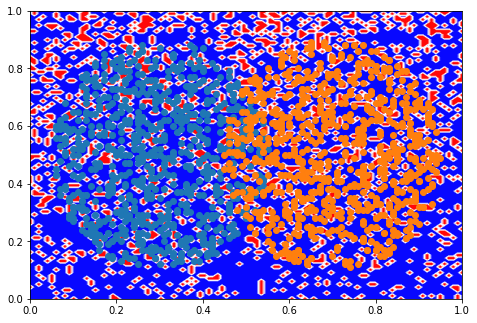

In [66]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(np.ravel(dataCoords[np.where(dataLabels == 0)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 0)])[1::2], ls='', marker='o')

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 1)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 1)])[1::2], ls='', marker='o')

X = np.linspace(0, 1, num=100)
Z = np.zeros((len(X), len(X)))



# Contour map
for j in range(len(X)):
    for k in range(len(X)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z[j, k] = check(currentParams, np.array([X[k], X[j]]))
        
        

        
ax.contourf(X, X, Z, cmap='bwr', levels=30)

After 1000 iteration we have theta = [-1.09816828 -2.70145399  1.88104365  1.51070775]


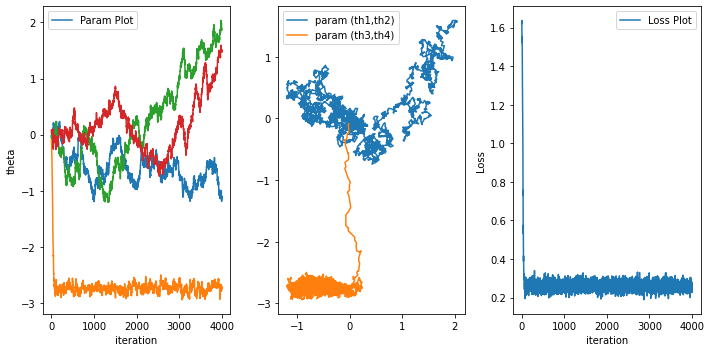

In [150]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
print('After 1000 iteration we have theta =',theta)
axes[0].plot(thdata)
axes[0].set_ylabel('theta')
axes[0].legend(['Param Plot'])
axes[0].set_xlabel('iteration')
axes[1].plot([item[2] for item in thdata],[item[3] for item in thdata],[item[0] for item in thdata],[item[1] for item in thdata])
axes[1].legend(['param (th1,th2)','param (th3,th4)'])

axes[2].plot(progress)
axes[2].legend(['Loss Plot'])
axes[2].set_ylabel('Loss')
axes[2].set_xlabel('iteration')
fig.tight_layout()    

In [151]:
progress=[];

thdata=[];
theta=[0,0,0,0];
c1=0.05;   
delta=6;
nshot=100;
theta=np.array(theta)-SPSA(1,theta,c1,delta,nshot)
for ep in range(4000):
    delta=random.random()+0.3
    theta=theta-SPSA(1,theta,c1,delta,nshot)
    print(ep,"th iteration L=",lossCal2qubit(1,theta,nshot))
    progress.append(lossCal2qubit(1,theta,nshot))
    thdata.append(theta)

0 th iteration L= 1.72
1 th iteration L= 1.6800000000000002
2 th iteration L= 1.52
3 th iteration L= 1.62
4 th iteration L= 1.6600000000000001
5 th iteration L= 1.26
6 th iteration L= 1.48
7 th iteration L= 1.28
8 th iteration L= 1.08
9 th iteration L= 1.3
10 th iteration L= 1.4
11 th iteration L= 1.52
12 th iteration L= 1.44
13 th iteration L= 1.38
14 th iteration L= 1.46
15 th iteration L= 1.48
16 th iteration L= 1.3599999999999999
17 th iteration L= 1.32
18 th iteration L= 1.28
19 th iteration L= 1.08
20 th iteration L= 1.02
21 th iteration L= 0.6799999999999999
22 th iteration L= 0.86
23 th iteration L= 0.72
24 th iteration L= 0.88
25 th iteration L= 0.6799999999999999
26 th iteration L= 0.6799999999999999
27 th iteration L= 0.62
28 th iteration L= 0.76
29 th iteration L= 0.9
30 th iteration L= 0.84
31 th iteration L= 0.76
32 th iteration L= 0.72
33 th iteration L= 0.45999999999999996
34 th iteration L= 0.6599999999999999
35 th iteration L= 0.5800000000000001
36 th iteration L= 0.6

264 th iteration L= 0.31999999999999995
265 th iteration L= 0.30000000000000004
266 th iteration L= 0.18000000000000005
267 th iteration L= 0.33999999999999997
268 th iteration L= 0.33999999999999997
269 th iteration L= 0.26
270 th iteration L= 0.30000000000000004
271 th iteration L= 0.19999999999999996
272 th iteration L= 0.33999999999999997
273 th iteration L= 0.38
274 th iteration L= 0.48
275 th iteration L= 0.26
276 th iteration L= 0.42000000000000004
277 th iteration L= 0.42000000000000004
278 th iteration L= 0.28
279 th iteration L= 0.24
280 th iteration L= 0.33999999999999997
281 th iteration L= 0.28
282 th iteration L= 0.26
283 th iteration L= 0.30000000000000004
284 th iteration L= 0.45999999999999996
285 th iteration L= 0.33999999999999997
286 th iteration L= 0.26
287 th iteration L= 0.28
288 th iteration L= 0.28
289 th iteration L= 0.4
290 th iteration L= 0.26
291 th iteration L= 0.36
292 th iteration L= 0.14
293 th iteration L= 0.19999999999999996
294 th iteration L= 0.36
2

510 th iteration L= 0.21999999999999997
511 th iteration L= 0.18000000000000005
512 th iteration L= 0.30000000000000004
513 th iteration L= 0.31999999999999995
514 th iteration L= 0.26
515 th iteration L= 0.26
516 th iteration L= 0.30000000000000004
517 th iteration L= 0.19999999999999996
518 th iteration L= 0.30000000000000004
519 th iteration L= 0.21999999999999997
520 th iteration L= 0.43999999999999995
521 th iteration L= 0.31999999999999995
522 th iteration L= 0.21999999999999997
523 th iteration L= 0.33999999999999997
524 th iteration L= 0.38
525 th iteration L= 0.30000000000000004
526 th iteration L= 0.30000000000000004
527 th iteration L= 0.31999999999999995
528 th iteration L= 0.36
529 th iteration L= 0.31999999999999995
530 th iteration L= 0.38
531 th iteration L= 0.33999999999999997
532 th iteration L= 0.28
533 th iteration L= 0.30000000000000004
534 th iteration L= 0.28
535 th iteration L= 0.31999999999999995
536 th iteration L= 0.21999999999999997
537 th iteration L= 0.38


771 th iteration L= 0.30000000000000004
772 th iteration L= 0.31999999999999995
773 th iteration L= 0.30000000000000004
774 th iteration L= 0.31999999999999995
775 th iteration L= 0.24
776 th iteration L= 0.38
777 th iteration L= 0.16000000000000003
778 th iteration L= 0.18000000000000005
779 th iteration L= 0.26
780 th iteration L= 0.42000000000000004
781 th iteration L= 0.18000000000000005
782 th iteration L= 0.24
783 th iteration L= 0.31999999999999995
784 th iteration L= 0.24
785 th iteration L= 0.18000000000000005
786 th iteration L= 0.19999999999999996
787 th iteration L= 0.28
788 th iteration L= 0.45999999999999996
789 th iteration L= 0.16000000000000003
790 th iteration L= 0.36
791 th iteration L= 0.31999999999999995
792 th iteration L= 0.28
793 th iteration L= 0.33999999999999997
794 th iteration L= 0.24
795 th iteration L= 0.30000000000000004
796 th iteration L= 0.31999999999999995
797 th iteration L= 0.26
798 th iteration L= 0.31999999999999995
799 th iteration L= 0.21999999

1028 th iteration L= 0.19999999999999996
1029 th iteration L= 0.33999999999999997
1030 th iteration L= 0.30000000000000004
1031 th iteration L= 0.07999999999999996
1032 th iteration L= 0.28
1033 th iteration L= 0.31999999999999995
1034 th iteration L= 0.18000000000000005
1035 th iteration L= 0.28
1036 th iteration L= 0.36
1037 th iteration L= 0.26
1038 th iteration L= 0.19999999999999996
1039 th iteration L= 0.33999999999999997
1040 th iteration L= 0.42000000000000004
1041 th iteration L= 0.28
1042 th iteration L= 0.19999999999999996
1043 th iteration L= 0.31999999999999995
1044 th iteration L= 0.28
1045 th iteration L= 0.31999999999999995
1046 th iteration L= 0.31999999999999995
1047 th iteration L= 0.26
1048 th iteration L= 0.16000000000000003
1049 th iteration L= 0.30000000000000004
1050 th iteration L= 0.24
1051 th iteration L= 0.28
1052 th iteration L= 0.30000000000000004
1053 th iteration L= 0.19999999999999996
1054 th iteration L= 0.26
1055 th iteration L= 0.16000000000000003
10

1272 th iteration L= 0.43999999999999995
1273 th iteration L= 0.19999999999999996
1274 th iteration L= 0.30000000000000004
1275 th iteration L= 0.28
1276 th iteration L= 0.28
1277 th iteration L= 0.33999999999999997
1278 th iteration L= 0.16000000000000003
1279 th iteration L= 0.28
1280 th iteration L= 0.45999999999999996
1281 th iteration L= 0.24
1282 th iteration L= 0.28
1283 th iteration L= 0.24
1284 th iteration L= 0.19999999999999996
1285 th iteration L= 0.26
1286 th iteration L= 0.18000000000000005
1287 th iteration L= 0.18000000000000005
1288 th iteration L= 0.31999999999999995
1289 th iteration L= 0.30000000000000004
1290 th iteration L= 0.28
1291 th iteration L= 0.31999999999999995
1292 th iteration L= 0.31999999999999995
1293 th iteration L= 0.28
1294 th iteration L= 0.52
1295 th iteration L= 0.18000000000000005
1296 th iteration L= 0.26
1297 th iteration L= 0.21999999999999997
1298 th iteration L= 0.24
1299 th iteration L= 0.24
1300 th iteration L= 0.48
1301 th iteration L= 

1517 th iteration L= 0.19999999999999996
1518 th iteration L= 0.31999999999999995
1519 th iteration L= 0.31999999999999995
1520 th iteration L= 0.31999999999999995
1521 th iteration L= 0.31999999999999995
1522 th iteration L= 0.24
1523 th iteration L= 0.30000000000000004
1524 th iteration L= 0.28
1525 th iteration L= 0.30000000000000004
1526 th iteration L= 0.21999999999999997
1527 th iteration L= 0.21999999999999997
1528 th iteration L= 0.33999999999999997
1529 th iteration L= 0.24
1530 th iteration L= 0.21999999999999997
1531 th iteration L= 0.16000000000000003
1532 th iteration L= 0.26
1533 th iteration L= 0.31999999999999995
1534 th iteration L= 0.33999999999999997
1535 th iteration L= 0.28
1536 th iteration L= 0.19999999999999996
1537 th iteration L= 0.30000000000000004
1538 th iteration L= 0.14
1539 th iteration L= 0.30000000000000004
1540 th iteration L= 0.19999999999999996
1541 th iteration L= 0.24
1542 th iteration L= 0.21999999999999997
1543 th iteration L= 0.1999999999999999

1755 th iteration L= 0.38
1756 th iteration L= 0.19999999999999996
1757 th iteration L= 0.30000000000000004
1758 th iteration L= 0.24
1759 th iteration L= 0.14
1760 th iteration L= 0.14
1761 th iteration L= 0.24
1762 th iteration L= 0.31999999999999995
1763 th iteration L= 0.26
1764 th iteration L= 0.18000000000000005
1765 th iteration L= 0.33999999999999997
1766 th iteration L= 0.24
1767 th iteration L= 0.21999999999999997
1768 th iteration L= 0.31999999999999995
1769 th iteration L= 0.19999999999999996
1770 th iteration L= 0.24
1771 th iteration L= 0.24
1772 th iteration L= 0.33999999999999997
1773 th iteration L= 0.21999999999999997
1774 th iteration L= 0.28
1775 th iteration L= 0.18000000000000005
1776 th iteration L= 0.16000000000000003
1777 th iteration L= 0.24
1778 th iteration L= 0.31999999999999995
1779 th iteration L= 0.30000000000000004
1780 th iteration L= 0.26
1781 th iteration L= 0.28
1782 th iteration L= 0.21999999999999997
1783 th iteration L= 0.24
1784 th iteration L= 

2006 th iteration L= 0.24
2007 th iteration L= 0.19999999999999996
2008 th iteration L= 0.21999999999999997
2009 th iteration L= 0.24
2010 th iteration L= 0.18000000000000005
2011 th iteration L= 0.24
2012 th iteration L= 0.18000000000000005
2013 th iteration L= 0.16000000000000003
2014 th iteration L= 0.21999999999999997
2015 th iteration L= 0.33999999999999997
2016 th iteration L= 0.24
2017 th iteration L= 0.16000000000000003
2018 th iteration L= 0.26
2019 th iteration L= 0.33999999999999997
2020 th iteration L= 0.30000000000000004
2021 th iteration L= 0.24
2022 th iteration L= 0.21999999999999997
2023 th iteration L= 0.26
2024 th iteration L= 0.33999999999999997
2025 th iteration L= 0.33999999999999997
2026 th iteration L= 0.19999999999999996
2027 th iteration L= 0.21999999999999997
2028 th iteration L= 0.38
2029 th iteration L= 0.21999999999999997
2030 th iteration L= 0.36
2031 th iteration L= 0.18000000000000005
2032 th iteration L= 0.26
2033 th iteration L= 0.33999999999999997
20

2251 th iteration L= 0.30000000000000004
2252 th iteration L= 0.26
2253 th iteration L= 0.28
2254 th iteration L= 0.4
2255 th iteration L= 0.26
2256 th iteration L= 0.24
2257 th iteration L= 0.24
2258 th iteration L= 0.30000000000000004
2259 th iteration L= 0.31999999999999995
2260 th iteration L= 0.31999999999999995
2261 th iteration L= 0.28
2262 th iteration L= 0.4
2263 th iteration L= 0.4
2264 th iteration L= 0.45999999999999996
2265 th iteration L= 0.42000000000000004
2266 th iteration L= 0.30000000000000004
2267 th iteration L= 0.26
2268 th iteration L= 0.43999999999999995
2269 th iteration L= 0.38
2270 th iteration L= 0.4
2271 th iteration L= 0.38
2272 th iteration L= 0.48
2273 th iteration L= 0.38
2274 th iteration L= 0.26
2275 th iteration L= 0.30000000000000004
2276 th iteration L= 0.21999999999999997
2277 th iteration L= 0.30000000000000004
2278 th iteration L= 0.28
2279 th iteration L= 0.26
2280 th iteration L= 0.30000000000000004
2281 th iteration L= 0.16000000000000003
228

2493 th iteration L= 0.26
2494 th iteration L= 0.38
2495 th iteration L= 0.18000000000000005
2496 th iteration L= 0.31999999999999995
2497 th iteration L= 0.19999999999999996
2498 th iteration L= 0.18000000000000005
2499 th iteration L= 0.31999999999999995
2500 th iteration L= 0.26
2501 th iteration L= 0.36
2502 th iteration L= 0.24
2503 th iteration L= 0.18000000000000005
2504 th iteration L= 0.28
2505 th iteration L= 0.31999999999999995
2506 th iteration L= 0.36
2507 th iteration L= 0.4
2508 th iteration L= 0.18000000000000005
2509 th iteration L= 0.28
2510 th iteration L= 0.28
2511 th iteration L= 0.24
2512 th iteration L= 0.28
2513 th iteration L= 0.26
2514 th iteration L= 0.14
2515 th iteration L= 0.31999999999999995
2516 th iteration L= 0.21999999999999997
2517 th iteration L= 0.12
2518 th iteration L= 0.18000000000000005
2519 th iteration L= 0.19999999999999996
2520 th iteration L= 0.26
2521 th iteration L= 0.21999999999999997
2522 th iteration L= 0.4
2523 th iteration L= 0.1600

2738 th iteration L= 0.45999999999999996
2739 th iteration L= 0.19999999999999996
2740 th iteration L= 0.43999999999999995
2741 th iteration L= 0.31999999999999995
2742 th iteration L= 0.18000000000000005
2743 th iteration L= 0.4
2744 th iteration L= 0.38
2745 th iteration L= 0.24
2746 th iteration L= 0.31999999999999995
2747 th iteration L= 0.19999999999999996
2748 th iteration L= 0.28
2749 th iteration L= 0.42000000000000004
2750 th iteration L= 0.36
2751 th iteration L= 0.18000000000000005
2752 th iteration L= 0.26
2753 th iteration L= 0.31999999999999995
2754 th iteration L= 0.38
2755 th iteration L= 0.42000000000000004
2756 th iteration L= 0.30000000000000004
2757 th iteration L= 0.36
2758 th iteration L= 0.26
2759 th iteration L= 0.26
2760 th iteration L= 0.28
2761 th iteration L= 0.30000000000000004
2762 th iteration L= 0.14
2763 th iteration L= 0.31999999999999995
2764 th iteration L= 0.31999999999999995
2765 th iteration L= 0.36
2766 th iteration L= 0.26
2767 th iteration L= 0

2985 th iteration L= 0.31999999999999995
2986 th iteration L= 0.26
2987 th iteration L= 0.24
2988 th iteration L= 0.24
2989 th iteration L= 0.19999999999999996
2990 th iteration L= 0.21999999999999997
2991 th iteration L= 0.26
2992 th iteration L= 0.14
2993 th iteration L= 0.38
2994 th iteration L= 0.16000000000000003
2995 th iteration L= 0.36
2996 th iteration L= 0.16000000000000003
2997 th iteration L= 0.24
2998 th iteration L= 0.26
2999 th iteration L= 0.30000000000000004
3000 th iteration L= 0.14
3001 th iteration L= 0.28
3002 th iteration L= 0.4
3003 th iteration L= 0.5800000000000001
3004 th iteration L= 0.26
3005 th iteration L= 0.36
3006 th iteration L= 0.18000000000000005
3007 th iteration L= 0.26
3008 th iteration L= 0.38
3009 th iteration L= 0.38
3010 th iteration L= 0.26
3011 th iteration L= 0.21999999999999997
3012 th iteration L= 0.26
3013 th iteration L= 0.26
3014 th iteration L= 0.18000000000000005
3015 th iteration L= 0.14
3016 th iteration L= 0.31999999999999995
3017 

3235 th iteration L= 0.26
3236 th iteration L= 0.30000000000000004
3237 th iteration L= 0.28
3238 th iteration L= 0.31999999999999995
3239 th iteration L= 0.26
3240 th iteration L= 0.31999999999999995
3241 th iteration L= 0.31999999999999995
3242 th iteration L= 0.33999999999999997
3243 th iteration L= 0.33999999999999997
3244 th iteration L= 0.26
3245 th iteration L= 0.31999999999999995
3246 th iteration L= 0.21999999999999997
3247 th iteration L= 0.31999999999999995
3248 th iteration L= 0.38
3249 th iteration L= 0.30000000000000004
3250 th iteration L= 0.52
3251 th iteration L= 0.19999999999999996
3252 th iteration L= 0.28
3253 th iteration L= 0.26
3254 th iteration L= 0.28
3255 th iteration L= 0.28
3256 th iteration L= 0.28
3257 th iteration L= 0.36
3258 th iteration L= 0.31999999999999995
3259 th iteration L= 0.42000000000000004
3260 th iteration L= 0.5
3261 th iteration L= 0.42000000000000004
3262 th iteration L= 0.38
3263 th iteration L= 0.4
3264 th iteration L= 0.24
3265 th iter

3729 th iteration L= 0.31999999999999995
3730 th iteration L= 0.42000000000000004
3731 th iteration L= 0.48
3732 th iteration L= 0.42000000000000004
3733 th iteration L= 0.30000000000000004
3734 th iteration L= 0.12
3735 th iteration L= 0.28
3736 th iteration L= 0.28
3737 th iteration L= 0.31999999999999995
3738 th iteration L= 0.36
3739 th iteration L= 0.14
3740 th iteration L= 0.28
3741 th iteration L= 0.4
3742 th iteration L= 0.16000000000000003
3743 th iteration L= 0.12
3744 th iteration L= 0.30000000000000004
3745 th iteration L= 0.28
3746 th iteration L= 0.18000000000000005
3747 th iteration L= 0.28
3748 th iteration L= 0.18000000000000005
3749 th iteration L= 0.28
3750 th iteration L= 0.24
3751 th iteration L= 0.31999999999999995
3752 th iteration L= 0.31999999999999995
3753 th iteration L= 0.33999999999999997
3754 th iteration L= 0.26
3755 th iteration L= 0.26
3756 th iteration L= 0.33999999999999997
3757 th iteration L= 0.38
3758 th iteration L= 0.21999999999999997
3759 th ite

3971 th iteration L= 0.24
3972 th iteration L= 0.38
3973 th iteration L= 0.19999999999999996
3974 th iteration L= 0.33999999999999997
3975 th iteration L= 0.21999999999999997
3976 th iteration L= 0.33999999999999997
3977 th iteration L= 0.5
3978 th iteration L= 0.26
3979 th iteration L= 0.26
3980 th iteration L= 0.28
3981 th iteration L= 0.33999999999999997
3982 th iteration L= 0.30000000000000004
3983 th iteration L= 0.24
3984 th iteration L= 0.24
3985 th iteration L= 0.42000000000000004
3986 th iteration L= 0.26
3987 th iteration L= 0.24
3988 th iteration L= 0.21999999999999997
3989 th iteration L= 0.26
3990 th iteration L= 0.26
3991 th iteration L= 0.28
3992 th iteration L= 0.26
3993 th iteration L= 0.26
3994 th iteration L= 0.36
3995 th iteration L= 0.24
3996 th iteration L= 0.18000000000000005
3997 th iteration L= 0.24
3998 th iteration L= 0.24
3999 th iteration L= 0.28


After 1000 iteration we have theta = [-3.09330618 -2.71047858  1.43642718  2.84540161]


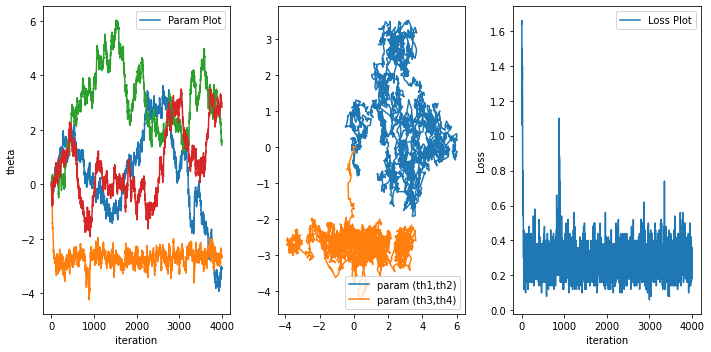

In [152]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
print('After 1000 iteration we have theta =',theta)
axes[0].plot(thdata)
axes[0].set_ylabel('theta')
axes[0].legend(['Param Plot'])
axes[0].set_xlabel('iteration')
axes[1].plot([item[2] for item in thdata],[item[3] for item in thdata],[item[0] for item in thdata],[item[1] for item in thdata])
axes[1].legend(['param (th1,th2)','param (th3,th4)'])

axes[2].plot(progress)
axes[2].legend(['Loss Plot'])
axes[2].set_ylabel('Loss')
axes[2].set_xlabel('iteration')
fig.tight_layout()    

In [153]:
progress=[];

thdata=[];
theta=[0,0,0,0];
c1=0.05;   
delta=6;
nshot=1000;
theta=np.array(theta)-SPSA(1,theta,c1,delta,nshot)
for ep in range(4000):
    delta=random.random()+0.3
    theta=theta-SPSA(1,theta,c1,delta,nshot)
    print(ep,"th iteration L=",lossCal2qubit(1,theta,nshot))
    progress.append(lossCal2qubit(1,theta,nshot))
    thdata.append(theta)

0 th iteration L= 1.6640000000000001
1 th iteration L= 1.6640000000000001
2 th iteration L= 1.698
3 th iteration L= 1.674
4 th iteration L= 1.6480000000000001
5 th iteration L= 1.616
6 th iteration L= 1.6360000000000001
7 th iteration L= 1.63
8 th iteration L= 1.674
9 th iteration L= 1.588
10 th iteration L= 1.6019999999999999
11 th iteration L= 1.56
12 th iteration L= 1.5779999999999998
13 th iteration L= 1.554
14 th iteration L= 1.5779999999999998
15 th iteration L= 1.542
16 th iteration L= 1.516
17 th iteration L= 1.552
18 th iteration L= 1.484
19 th iteration L= 1.546
20 th iteration L= 1.438
21 th iteration L= 1.476
22 th iteration L= 1.45
23 th iteration L= 1.432
24 th iteration L= 1.4020000000000001
25 th iteration L= 1.3719999999999999
26 th iteration L= 1.35
27 th iteration L= 1.324
28 th iteration L= 1.288
29 th iteration L= 1.148
30 th iteration L= 0.918
31 th iteration L= 0.914
32 th iteration L= 0.876
33 th iteration L= 0.776
34 th iteration L= 0.786
35 th iteration L= 0.7

274 th iteration L= 0.276
275 th iteration L= 0.26
276 th iteration L= 0.276
277 th iteration L= 0.266
278 th iteration L= 0.266
279 th iteration L= 0.19599999999999995
280 th iteration L= 0.242
281 th iteration L= 0.266
282 th iteration L= 0.28800000000000003
283 th iteration L= 0.266
284 th iteration L= 0.26
285 th iteration L= 0.22599999999999998
286 th iteration L= 0.21999999999999997
287 th iteration L= 0.23199999999999998
288 th iteration L= 0.266
289 th iteration L= 0.244
290 th iteration L= 0.28
291 th iteration L= 0.238
292 th iteration L= 0.256
293 th iteration L= 0.274
294 th iteration L= 0.21999999999999997
295 th iteration L= 0.274
296 th iteration L= 0.238
297 th iteration L= 0.28
298 th iteration L= 0.236
299 th iteration L= 0.24
300 th iteration L= 0.28
301 th iteration L= 0.24
302 th iteration L= 0.248
303 th iteration L= 0.27
304 th iteration L= 0.21999999999999997
305 th iteration L= 0.22799999999999998
306 th iteration L= 0.274
307 th iteration L= 0.26
308 th iterat

547 th iteration L= 0.268
548 th iteration L= 0.262
549 th iteration L= 0.262
550 th iteration L= 0.266
551 th iteration L= 0.274
552 th iteration L= 0.268
553 th iteration L= 0.276
554 th iteration L= 0.274
555 th iteration L= 0.27
556 th iteration L= 0.272
557 th iteration L= 0.25
558 th iteration L= 0.27
559 th iteration L= 0.25
560 th iteration L= 0.262
561 th iteration L= 0.272
562 th iteration L= 0.244
563 th iteration L= 0.25
564 th iteration L= 0.256
565 th iteration L= 0.246
566 th iteration L= 0.23399999999999999
567 th iteration L= 0.238
568 th iteration L= 0.266
569 th iteration L= 0.22399999999999998
570 th iteration L= 0.28400000000000003
571 th iteration L= 0.252
572 th iteration L= 0.262
573 th iteration L= 0.23399999999999999
574 th iteration L= 0.252
575 th iteration L= 0.29400000000000004
576 th iteration L= 0.22999999999999998
577 th iteration L= 0.244
578 th iteration L= 0.28
579 th iteration L= 0.23199999999999998
580 th iteration L= 0.264
581 th iteration L= 0.22

826 th iteration L= 0.252
827 th iteration L= 0.274
828 th iteration L= 0.256
829 th iteration L= 0.29200000000000004
830 th iteration L= 0.278
831 th iteration L= 0.264
832 th iteration L= 0.28600000000000003
833 th iteration L= 0.252
834 th iteration L= 0.26
835 th iteration L= 0.20199999999999996
836 th iteration L= 0.266
837 th iteration L= 0.29200000000000004
838 th iteration L= 0.28
839 th iteration L= 0.258
840 th iteration L= 0.29200000000000004
841 th iteration L= 0.27
842 th iteration L= 0.272
843 th iteration L= 0.266
844 th iteration L= 0.264
845 th iteration L= 0.25
846 th iteration L= 0.236
847 th iteration L= 0.268
848 th iteration L= 0.23399999999999999
849 th iteration L= 0.238
850 th iteration L= 0.236
851 th iteration L= 0.248
852 th iteration L= 0.272
853 th iteration L= 0.278
854 th iteration L= 0.29400000000000004
855 th iteration L= 0.278
856 th iteration L= 0.252
857 th iteration L= 0.28200000000000003
858 th iteration L= 0.268
859 th iteration L= 0.254
860 th i

1097 th iteration L= 0.262
1098 th iteration L= 0.264
1099 th iteration L= 0.236
1100 th iteration L= 0.254
1101 th iteration L= 0.21599999999999997
1102 th iteration L= 0.23399999999999999
1103 th iteration L= 0.256
1104 th iteration L= 0.244
1105 th iteration L= 0.274
1106 th iteration L= 0.276
1107 th iteration L= 0.236
1108 th iteration L= 0.256
1109 th iteration L= 0.23399999999999999
1110 th iteration L= 0.258
1111 th iteration L= 0.31200000000000006
1112 th iteration L= 0.242
1113 th iteration L= 0.258
1114 th iteration L= 0.262
1115 th iteration L= 0.26
1116 th iteration L= 0.29400000000000004
1117 th iteration L= 0.25
1118 th iteration L= 0.268
1119 th iteration L= 0.28
1120 th iteration L= 0.26
1121 th iteration L= 0.272
1122 th iteration L= 0.27
1123 th iteration L= 0.28400000000000003
1124 th iteration L= 0.278
1125 th iteration L= 0.242
1126 th iteration L= 0.268
1127 th iteration L= 0.254
1128 th iteration L= 0.242
1129 th iteration L= 0.244
1130 th iteration L= 0.254
113

1364 th iteration L= 0.254
1365 th iteration L= 0.29400000000000004
1366 th iteration L= 0.27
1367 th iteration L= 0.27
1368 th iteration L= 0.248
1369 th iteration L= 0.248
1370 th iteration L= 0.28400000000000003
1371 th iteration L= 0.29000000000000004
1372 th iteration L= 0.22999999999999998
1373 th iteration L= 0.246
1374 th iteration L= 0.23199999999999998
1375 th iteration L= 0.266
1376 th iteration L= 0.258
1377 th iteration L= 0.264
1378 th iteration L= 0.29200000000000004
1379 th iteration L= 0.20599999999999996
1380 th iteration L= 0.22399999999999998
1381 th iteration L= 0.272
1382 th iteration L= 0.252
1383 th iteration L= 0.236
1384 th iteration L= 0.244
1385 th iteration L= 0.248
1386 th iteration L= 0.26
1387 th iteration L= 0.28
1388 th iteration L= 0.258
1389 th iteration L= 0.28800000000000003
1390 th iteration L= 0.238
1391 th iteration L= 0.244
1392 th iteration L= 0.26
1393 th iteration L= 0.272
1394 th iteration L= 0.262
1395 th iteration L= 0.25
1396 th iteratio

1636 th iteration L= 0.238
1637 th iteration L= 0.262
1638 th iteration L= 0.262
1639 th iteration L= 0.28
1640 th iteration L= 0.254
1641 th iteration L= 0.252
1642 th iteration L= 0.28800000000000003
1643 th iteration L= 0.258
1644 th iteration L= 0.21199999999999997
1645 th iteration L= 0.29200000000000004
1646 th iteration L= 0.30600000000000005
1647 th iteration L= 0.272
1648 th iteration L= 0.256
1649 th iteration L= 0.26
1650 th iteration L= 0.258
1651 th iteration L= 0.246
1652 th iteration L= 0.28
1653 th iteration L= 0.28400000000000003
1654 th iteration L= 0.29400000000000004
1655 th iteration L= 0.28600000000000003
1656 th iteration L= 0.264
1657 th iteration L= 0.24
1658 th iteration L= 0.256
1659 th iteration L= 0.28400000000000003
1660 th iteration L= 0.26
1661 th iteration L= 0.262
1662 th iteration L= 0.246
1663 th iteration L= 0.22999999999999998
1664 th iteration L= 0.28
1665 th iteration L= 0.256
1666 th iteration L= 0.268
1667 th iteration L= 0.244
1668 th iteratio

1908 th iteration L= 0.274
1909 th iteration L= 0.262
1910 th iteration L= 0.266
1911 th iteration L= 0.28800000000000003
1912 th iteration L= 0.20599999999999996
1913 th iteration L= 0.262
1914 th iteration L= 0.276
1915 th iteration L= 0.29000000000000004
1916 th iteration L= 0.29000000000000004
1917 th iteration L= 0.246
1918 th iteration L= 0.268
1919 th iteration L= 0.272
1920 th iteration L= 0.23199999999999998
1921 th iteration L= 0.246
1922 th iteration L= 0.26
1923 th iteration L= 0.254
1924 th iteration L= 0.22599999999999998
1925 th iteration L= 0.276
1926 th iteration L= 0.246
1927 th iteration L= 0.246
1928 th iteration L= 0.276
1929 th iteration L= 0.23199999999999998
1930 th iteration L= 0.27
1931 th iteration L= 0.254
1932 th iteration L= 0.262
1933 th iteration L= 0.256
1934 th iteration L= 0.21199999999999997
1935 th iteration L= 0.256
1936 th iteration L= 0.21799999999999997
1937 th iteration L= 0.266
1938 th iteration L= 0.272
1939 th iteration L= 0.28
1940 th itera

2175 th iteration L= 0.236
2176 th iteration L= 0.27
2177 th iteration L= 0.262
2178 th iteration L= 0.22799999999999998
2179 th iteration L= 0.28
2180 th iteration L= 0.256
2181 th iteration L= 0.28
2182 th iteration L= 0.246
2183 th iteration L= 0.256
2184 th iteration L= 0.28400000000000003
2185 th iteration L= 0.246
2186 th iteration L= 0.256
2187 th iteration L= 0.31200000000000006
2188 th iteration L= 0.258
2189 th iteration L= 0.254
2190 th iteration L= 0.29800000000000004
2191 th iteration L= 0.29600000000000004
2192 th iteration L= 0.26
2193 th iteration L= 0.266
2194 th iteration L= 0.24
2195 th iteration L= 0.27
2196 th iteration L= 0.262
2197 th iteration L= 0.246
2198 th iteration L= 0.238
2199 th iteration L= 0.26
2200 th iteration L= 0.256
2201 th iteration L= 0.21799999999999997
2202 th iteration L= 0.266
2203 th iteration L= 0.25
2204 th iteration L= 0.23199999999999998
2205 th iteration L= 0.238
2206 th iteration L= 0.238
2207 th iteration L= 0.28
2208 th iteration L=

2443 th iteration L= 0.272
2444 th iteration L= 0.266
2445 th iteration L= 0.252
2446 th iteration L= 0.262
2447 th iteration L= 0.254
2448 th iteration L= 0.31399999999999995
2449 th iteration L= 0.254
2450 th iteration L= 0.252
2451 th iteration L= 0.264
2452 th iteration L= 0.276
2453 th iteration L= 0.28600000000000003
2454 th iteration L= 0.24
2455 th iteration L= 0.248
2456 th iteration L= 0.28200000000000003
2457 th iteration L= 0.254
2458 th iteration L= 0.27
2459 th iteration L= 0.274
2460 th iteration L= 0.258
2461 th iteration L= 0.242
2462 th iteration L= 0.26
2463 th iteration L= 0.258
2464 th iteration L= 0.248
2465 th iteration L= 0.254
2466 th iteration L= 0.25
2467 th iteration L= 0.25
2468 th iteration L= 0.244
2469 th iteration L= 0.30000000000000004
2470 th iteration L= 0.22799999999999998
2471 th iteration L= 0.27
2472 th iteration L= 0.238
2473 th iteration L= 0.22399999999999998
2474 th iteration L= 0.272
2475 th iteration L= 0.252
2476 th iteration L= 0.22999999

2710 th iteration L= 0.236
2711 th iteration L= 0.254
2712 th iteration L= 0.26
2713 th iteration L= 0.22599999999999998
2714 th iteration L= 0.26
2715 th iteration L= 0.28200000000000003
2716 th iteration L= 0.272
2717 th iteration L= 0.21799999999999997
2718 th iteration L= 0.23199999999999998
2719 th iteration L= 0.276
2720 th iteration L= 0.246
2721 th iteration L= 0.25
2722 th iteration L= 0.258
2723 th iteration L= 0.25
2724 th iteration L= 0.28600000000000003
2725 th iteration L= 0.26
2726 th iteration L= 0.276
2727 th iteration L= 0.238
2728 th iteration L= 0.22599999999999998
2729 th iteration L= 0.262
2730 th iteration L= 0.244
2731 th iteration L= 0.278
2732 th iteration L= 0.28800000000000003
2733 th iteration L= 0.258
2734 th iteration L= 0.25
2735 th iteration L= 0.252
2736 th iteration L= 0.246
2737 th iteration L= 0.29600000000000004
2738 th iteration L= 0.25
2739 th iteration L= 0.258
2740 th iteration L= 0.22599999999999998
2741 th iteration L= 0.262
2742 th iteration

2971 th iteration L= 0.256
2972 th iteration L= 0.26
2973 th iteration L= 0.27
2974 th iteration L= 0.274
2975 th iteration L= 0.29200000000000004
2976 th iteration L= 0.22799999999999998
2977 th iteration L= 0.258
2978 th iteration L= 0.276
2979 th iteration L= 0.258
2980 th iteration L= 0.258
2981 th iteration L= 0.242
2982 th iteration L= 0.254
2983 th iteration L= 0.266
2984 th iteration L= 0.236
2985 th iteration L= 0.242
2986 th iteration L= 0.266
2987 th iteration L= 0.264
2988 th iteration L= 0.32399999999999995
2989 th iteration L= 0.242
2990 th iteration L= 0.21999999999999997
2991 th iteration L= 0.276
2992 th iteration L= 0.24
2993 th iteration L= 0.28200000000000003
2994 th iteration L= 0.22799999999999998
2995 th iteration L= 0.272
2996 th iteration L= 0.256
2997 th iteration L= 0.242
2998 th iteration L= 0.272
2999 th iteration L= 0.25
3000 th iteration L= 0.23199999999999998
3001 th iteration L= 0.256
3002 th iteration L= 0.248
3003 th iteration L= 0.236
3004 th iterati

3241 th iteration L= 0.262
3242 th iteration L= 0.264
3243 th iteration L= 0.22799999999999998
3244 th iteration L= 0.274
3245 th iteration L= 0.262
3246 th iteration L= 0.262
3247 th iteration L= 0.27
3248 th iteration L= 0.21999999999999997
3249 th iteration L= 0.28600000000000003
3250 th iteration L= 0.254
3251 th iteration L= 0.244
3252 th iteration L= 0.278
3253 th iteration L= 0.274
3254 th iteration L= 0.256
3255 th iteration L= 0.262
3256 th iteration L= 0.264
3257 th iteration L= 0.28
3258 th iteration L= 0.29800000000000004
3259 th iteration L= 0.264
3260 th iteration L= 0.27
3261 th iteration L= 0.264
3262 th iteration L= 0.258
3263 th iteration L= 0.256
3264 th iteration L= 0.29200000000000004
3265 th iteration L= 0.26
3266 th iteration L= 0.258
3267 th iteration L= 0.246
3268 th iteration L= 0.256
3269 th iteration L= 0.256
3270 th iteration L= 0.27
3271 th iteration L= 0.238
3272 th iteration L= 0.23399999999999999
3273 th iteration L= 0.23199999999999998
3274 th iteratio

3511 th iteration L= 0.28600000000000003
3512 th iteration L= 0.246
3513 th iteration L= 0.264
3514 th iteration L= 0.272
3515 th iteration L= 0.248
3516 th iteration L= 0.262
3517 th iteration L= 0.24
3518 th iteration L= 0.20199999999999996
3519 th iteration L= 0.256
3520 th iteration L= 0.278
3521 th iteration L= 0.262
3522 th iteration L= 0.272
3523 th iteration L= 0.22199999999999998
3524 th iteration L= 0.256
3525 th iteration L= 0.272
3526 th iteration L= 0.248
3527 th iteration L= 0.24
3528 th iteration L= 0.25
3529 th iteration L= 0.22599999999999998
3530 th iteration L= 0.264
3531 th iteration L= 0.29400000000000004
3532 th iteration L= 0.248
3533 th iteration L= 0.28800000000000003
3534 th iteration L= 0.272
3535 th iteration L= 0.22199999999999998
3536 th iteration L= 0.256
3537 th iteration L= 0.248
3538 th iteration L= 0.29000000000000004
3539 th iteration L= 0.20399999999999996
3540 th iteration L= 0.248
3541 th iteration L= 0.28400000000000003
3542 th iteration L= 0.262

3776 th iteration L= 0.252
3777 th iteration L= 0.29200000000000004
3778 th iteration L= 0.24
3779 th iteration L= 0.272
3780 th iteration L= 0.248
3781 th iteration L= 0.28600000000000003
3782 th iteration L= 0.274
3783 th iteration L= 0.27
3784 th iteration L= 0.258
3785 th iteration L= 0.244
3786 th iteration L= 0.29000000000000004
3787 th iteration L= 0.28600000000000003
3788 th iteration L= 0.264
3789 th iteration L= 0.256
3790 th iteration L= 0.256
3791 th iteration L= 0.25
3792 th iteration L= 0.28
3793 th iteration L= 0.264
3794 th iteration L= 0.258
3795 th iteration L= 0.266
3796 th iteration L= 0.23399999999999999
3797 th iteration L= 0.276
3798 th iteration L= 0.28600000000000003
3799 th iteration L= 0.29600000000000004
3800 th iteration L= 0.262
3801 th iteration L= 0.264
3802 th iteration L= 0.21599999999999997
3803 th iteration L= 0.248
3804 th iteration L= 0.256
3805 th iteration L= 0.252
3806 th iteration L= 0.21799999999999997
3807 th iteration L= 0.264
3808 th iterat

After 1000 iteration we have theta = [-0.22572999 -2.72253771  0.34094337 -0.30667653]


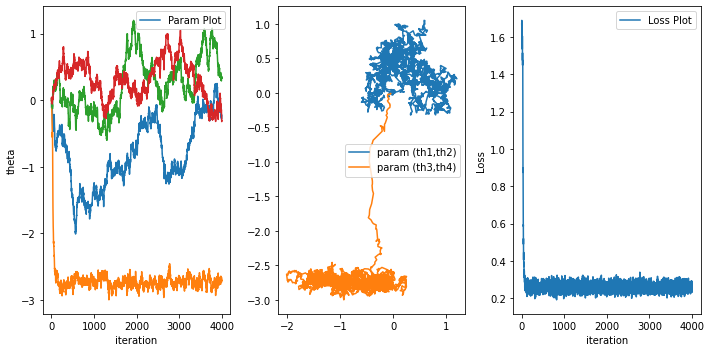

In [154]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
print('After 1000 iteration we have theta =',theta)
axes[0].plot(thdata)
axes[0].set_ylabel('theta')
axes[0].legend(['Param Plot'])
axes[0].set_xlabel('iteration')
axes[1].plot([item[2] for item in thdata],[item[3] for item in thdata],[item[0] for item in thdata],[item[1] for item in thdata])
axes[1].legend(['param (th1,th2)','param (th3,th4)'])

axes[2].plot(progress)
axes[2].legend(['Loss Plot'])
axes[2].set_ylabel('Loss')
axes[2].set_xlabel('iteration')
fig.tight_layout()    

In [155]:
progress=[];

thdata=[];
theta=[0,0,0,0];
c1=0.05;   
delta=6;
nshot=10000;
theta=np.array(theta)-SPSA(1,theta,c1,delta,nshot)
for ep in range(4000):
    delta=random.random()+0.3
    theta=theta-SPSA(1,theta,c1,delta,nshot)
    print(ep,"th iteration L=",lossCal2qubit(1,theta,nshot))
    progress.append(lossCal2qubit(1,theta,nshot))
    thdata.append(theta)

0 th iteration L= 1.6834
1 th iteration L= 1.671
2 th iteration L= 1.6758
3 th iteration L= 1.6722000000000001
4 th iteration L= 1.662
5 th iteration L= 1.6406
6 th iteration L= 1.6522000000000001
7 th iteration L= 1.617
8 th iteration L= 1.6219999999999999
9 th iteration L= 1.6186
10 th iteration L= 1.5856
11 th iteration L= 1.5596
12 th iteration L= 1.5544
13 th iteration L= 1.5196
14 th iteration L= 1.4862
15 th iteration L= 1.4546000000000001
16 th iteration L= 1.4126
17 th iteration L= 1.38
18 th iteration L= 1.3652
19 th iteration L= 1.3226
20 th iteration L= 1.2676
21 th iteration L= 1.1688
22 th iteration L= 1.1012
23 th iteration L= 1.0646
24 th iteration L= 1.0382
25 th iteration L= 0.9888
26 th iteration L= 0.9866
27 th iteration L= 0.916
28 th iteration L= 0.8726
29 th iteration L= 0.802
30 th iteration L= 0.7296
31 th iteration L= 0.6992
32 th iteration L= 0.6998
33 th iteration L= 0.6484
34 th iteration L= 0.6364000000000001
35 th iteration L= 0.6118
36 th iteration L= 0.

493 th iteration L= 0.26680000000000004
494 th iteration L= 0.24060000000000004
495 th iteration L= 0.25880000000000003
496 th iteration L= 0.25960000000000005
497 th iteration L= 0.2602
498 th iteration L= 0.2512
499 th iteration L= 0.25360000000000005
500 th iteration L= 0.2548
501 th iteration L= 0.2558
502 th iteration L= 0.25560000000000005
503 th iteration L= 0.272
504 th iteration L= 0.25780000000000003
505 th iteration L= 0.26180000000000003
506 th iteration L= 0.2572
507 th iteration L= 0.26359999999999995
508 th iteration L= 0.26480000000000004
509 th iteration L= 0.25780000000000003
510 th iteration L= 0.2518
511 th iteration L= 0.25239999999999996
512 th iteration L= 0.26180000000000003
513 th iteration L= 0.26160000000000005
514 th iteration L= 0.2532
515 th iteration L= 0.25339999999999996
516 th iteration L= 0.266
517 th iteration L= 0.2572
518 th iteration L= 0.25939999999999996
519 th iteration L= 0.2518
520 th iteration L= 0.2542
521 th iteration L= 0.2558
522 th iter

731 th iteration L= 0.25439999999999996
732 th iteration L= 0.24960000000000004
733 th iteration L= 0.26380000000000003
734 th iteration L= 0.25560000000000005
735 th iteration L= 0.26139999999999997
736 th iteration L= 0.24560000000000004
737 th iteration L= 0.2652
738 th iteration L= 0.257
739 th iteration L= 0.25780000000000003
740 th iteration L= 0.258
741 th iteration L= 0.26839999999999997
742 th iteration L= 0.24539999999999995
743 th iteration L= 0.26259999999999994
744 th iteration L= 0.267
745 th iteration L= 0.2532
746 th iteration L= 0.25139999999999996
747 th iteration L= 0.24819999999999998
748 th iteration L= 0.2508
749 th iteration L= 0.2532
750 th iteration L= 0.24919999999999998
751 th iteration L= 0.24919999999999998
752 th iteration L= 0.24060000000000004
753 th iteration L= 0.26039999999999996
754 th iteration L= 0.2548
755 th iteration L= 0.25160000000000005
756 th iteration L= 0.247
757 th iteration L= 0.25839999999999996
758 th iteration L= 0.26559999999999995
7

1198 th iteration L= 0.266
1199 th iteration L= 0.26
1200 th iteration L= 0.258
1201 th iteration L= 0.2518
1202 th iteration L= 0.2548
1203 th iteration L= 0.267
1204 th iteration L= 0.2542
1205 th iteration L= 0.26
1206 th iteration L= 0.271
1207 th iteration L= 0.24419999999999997
1208 th iteration L= 0.2632
1209 th iteration L= 0.253
1210 th iteration L= 0.262
1211 th iteration L= 0.26359999999999995
1212 th iteration L= 0.2532
1213 th iteration L= 0.26039999999999996
1214 th iteration L= 0.2732
1215 th iteration L= 0.25860000000000005
1216 th iteration L= 0.2612
1217 th iteration L= 0.2572
1218 th iteration L= 0.26880000000000004
1219 th iteration L= 0.25860000000000005
1220 th iteration L= 0.258
1221 th iteration L= 0.26239999999999997
1222 th iteration L= 0.26
1223 th iteration L= 0.258
1224 th iteration L= 0.25339999999999996
1225 th iteration L= 0.26439999999999997
1226 th iteration L= 0.24939999999999996
1227 th iteration L= 0.2642
1228 th iteration L= 0.25
1229 th iteration 

1435 th iteration L= 0.24980000000000002
1436 th iteration L= 0.25239999999999996
1437 th iteration L= 0.256
1438 th iteration L= 0.25939999999999996
1439 th iteration L= 0.25860000000000005
1440 th iteration L= 0.26139999999999997
1441 th iteration L= 0.25460000000000005
1442 th iteration L= 0.258
1443 th iteration L= 0.2694
1444 th iteration L= 0.2542
1445 th iteration L= 0.24980000000000002
1446 th iteration L= 0.26759999999999995
1447 th iteration L= 0.25960000000000005
1448 th iteration L= 0.2672
1449 th iteration L= 0.26659999999999995
1450 th iteration L= 0.2724
1451 th iteration L= 0.253
1452 th iteration L= 0.24619999999999997
1453 th iteration L= 0.25880000000000003
1454 th iteration L= 0.2528
1455 th iteration L= 0.25560000000000005
1456 th iteration L= 0.2572
1457 th iteration L= 0.25880000000000003
1458 th iteration L= 0.26280000000000003
1459 th iteration L= 0.26139999999999997
1460 th iteration L= 0.26060000000000005
1461 th iteration L= 0.24919999999999998
1462 th itera

1669 th iteration L= 0.25839999999999996
1670 th iteration L= 0.24760000000000004
1671 th iteration L= 0.25839999999999996
1672 th iteration L= 0.26359999999999995
1673 th iteration L= 0.24619999999999997
1674 th iteration L= 0.256
1675 th iteration L= 0.2508
1676 th iteration L= 0.26739999999999997
1677 th iteration L= 0.257
1678 th iteration L= 0.2724
1679 th iteration L= 0.26180000000000003
1680 th iteration L= 0.2562
1681 th iteration L= 0.24360000000000004
1682 th iteration L= 0.2572
1683 th iteration L= 0.25839999999999996
1684 th iteration L= 0.2662
1685 th iteration L= 0.24939999999999996
1686 th iteration L= 0.25960000000000005
1687 th iteration L= 0.24360000000000004
1688 th iteration L= 0.25139999999999996
1689 th iteration L= 0.26239999999999997
1690 th iteration L= 0.25539999999999996
1691 th iteration L= 0.24780000000000002
1692 th iteration L= 0.24880000000000002
1693 th iteration L= 0.25360000000000005
1694 th iteration L= 0.2592
1695 th iteration L= 0.2518
1696 th iter

1901 th iteration L= 0.25539999999999996
1902 th iteration L= 0.2538
1903 th iteration L= 0.25839999999999996
1904 th iteration L= 0.264
1905 th iteration L= 0.25560000000000005
1906 th iteration L= 0.27259999999999995
1907 th iteration L= 0.26
1908 th iteration L= 0.26439999999999997
1909 th iteration L= 0.24539999999999995
1910 th iteration L= 0.2632
1911 th iteration L= 0.2562
1912 th iteration L= 0.2558
1913 th iteration L= 0.26380000000000003
1914 th iteration L= 0.24839999999999995
1915 th iteration L= 0.25880000000000003
1916 th iteration L= 0.25680000000000003
1917 th iteration L= 0.2592
1918 th iteration L= 0.263
1919 th iteration L= 0.25839999999999996
1920 th iteration L= 0.25239999999999996
1921 th iteration L= 0.25860000000000005
1922 th iteration L= 0.25780000000000003
1923 th iteration L= 0.2652
1924 th iteration L= 0.26659999999999995
1925 th iteration L= 0.25160000000000005
1926 th iteration L= 0.25360000000000005
1927 th iteration L= 0.25760000000000005
1928 th iterat

2139 th iteration L= 0.25639999999999996
2140 th iteration L= 0.2562
2141 th iteration L= 0.25460000000000005
2142 th iteration L= 0.26439999999999997
2143 th iteration L= 0.26780000000000004
2144 th iteration L= 0.24939999999999996
2145 th iteration L= 0.25880000000000003
2146 th iteration L= 0.2694
2147 th iteration L= 0.2512
2148 th iteration L= 0.2542
2149 th iteration L= 0.26839999999999997
2150 th iteration L= 0.2572
2151 th iteration L= 0.25139999999999996
2152 th iteration L= 0.2714
2153 th iteration L= 0.24960000000000004
2154 th iteration L= 0.26339999999999997
2155 th iteration L= 0.24980000000000002
2156 th iteration L= 0.25460000000000005
2157 th iteration L= 0.264
2158 th iteration L= 0.25439999999999996
2159 th iteration L= 0.251
2160 th iteration L= 0.25639999999999996
2161 th iteration L= 0.272
2162 th iteration L= 0.265
2163 th iteration L= 0.26580000000000004
2164 th iteration L= 0.2548
2165 th iteration L= 0.252
2166 th iteration L= 0.259
2167 th iteration L= 0.2625

2374 th iteration L= 0.26359999999999995
2375 th iteration L= 0.2558
2376 th iteration L= 0.2622
2377 th iteration L= 0.261
2378 th iteration L= 0.2518
2379 th iteration L= 0.256
2380 th iteration L= 0.26359999999999995
2381 th iteration L= 0.25639999999999996
2382 th iteration L= 0.25460000000000005
2383 th iteration L= 0.2528
2384 th iteration L= 0.261
2385 th iteration L= 0.2612
2386 th iteration L= 0.26139999999999997
2387 th iteration L= 0.24639999999999995
2388 th iteration L= 0.262
2389 th iteration L= 0.2612
2390 th iteration L= 0.265
2391 th iteration L= 0.263
2392 th iteration L= 0.25760000000000005
2393 th iteration L= 0.2502
2394 th iteration L= 0.2548
2395 th iteration L= 0.26380000000000003
2396 th iteration L= 0.27159999999999995
2397 th iteration L= 0.25360000000000005
2398 th iteration L= 0.25239999999999996
2399 th iteration L= 0.2552
2400 th iteration L= 0.2582
2401 th iteration L= 0.249
2402 th iteration L= 0.267
2403 th iteration L= 0.258
2404 th iteration L= 0.263

2613 th iteration L= 0.25339999999999996
2614 th iteration L= 0.25360000000000005
2615 th iteration L= 0.2652
2616 th iteration L= 0.26539999999999997
2617 th iteration L= 0.25660000000000005
2618 th iteration L= 0.2532
2619 th iteration L= 0.24919999999999998
2620 th iteration L= 0.25039999999999996
2621 th iteration L= 0.2552
2622 th iteration L= 0.26880000000000004
2623 th iteration L= 0.26180000000000003
2624 th iteration L= 0.2612
2625 th iteration L= 0.258
2626 th iteration L= 0.25960000000000005
2627 th iteration L= 0.255
2628 th iteration L= 0.25839999999999996
2629 th iteration L= 0.26980000000000004
2630 th iteration L= 0.26160000000000005
2631 th iteration L= 0.24360000000000004
2632 th iteration L= 0.25680000000000003
2633 th iteration L= 0.25880000000000003
2634 th iteration L= 0.24960000000000004
2635 th iteration L= 0.2704
2636 th iteration L= 0.25739999999999996
2637 th iteration L= 0.26880000000000004
2638 th iteration L= 0.259
2639 th iteration L= 0.25360000000000005


2848 th iteration L= 0.25880000000000003
2849 th iteration L= 0.2508
2850 th iteration L= 0.25560000000000005
2851 th iteration L= 0.26080000000000003
2852 th iteration L= 0.26439999999999997
2853 th iteration L= 0.265
2854 th iteration L= 0.258
2855 th iteration L= 0.26339999999999997
2856 th iteration L= 0.26359999999999995
2857 th iteration L= 0.2592
2858 th iteration L= 0.25680000000000003
2859 th iteration L= 0.25439999999999996
2860 th iteration L= 0.249
2861 th iteration L= 0.26039999999999996
2862 th iteration L= 0.255
2863 th iteration L= 0.243
2864 th iteration L= 0.2592
2865 th iteration L= 0.26160000000000005
2866 th iteration L= 0.2632
2867 th iteration L= 0.26280000000000003
2868 th iteration L= 0.268
2869 th iteration L= 0.2652
2870 th iteration L= 0.2692
2871 th iteration L= 0.2662
2872 th iteration L= 0.27159999999999995
2873 th iteration L= 0.26539999999999997
2874 th iteration L= 0.25539999999999996
2875 th iteration L= 0.267
2876 th iteration L= 0.261
2877 th iterat

3080 th iteration L= 0.26559999999999995
3081 th iteration L= 0.26280000000000003
3082 th iteration L= 0.2662
3083 th iteration L= 0.26280000000000003
3084 th iteration L= 0.255
3085 th iteration L= 0.269
3086 th iteration L= 0.2562
3087 th iteration L= 0.2722
3088 th iteration L= 0.2502
3089 th iteration L= 0.25139999999999996
3090 th iteration L= 0.263
3091 th iteration L= 0.2582
3092 th iteration L= 0.2592
3093 th iteration L= 0.25139999999999996
3094 th iteration L= 0.2672
3095 th iteration L= 0.2522
3096 th iteration L= 0.26880000000000004
3097 th iteration L= 0.24980000000000002
3098 th iteration L= 0.253
3099 th iteration L= 0.2562
3100 th iteration L= 0.2602
3101 th iteration L= 0.2538
3102 th iteration L= 0.26339999999999997
3103 th iteration L= 0.26180000000000003
3104 th iteration L= 0.26559999999999995
3105 th iteration L= 0.26080000000000003
3106 th iteration L= 0.25639999999999996
3107 th iteration L= 0.2682
3108 th iteration L= 0.25639999999999996
3109 th iteration L= 0.

3316 th iteration L= 0.28080000000000005
3317 th iteration L= 0.24880000000000002
3318 th iteration L= 0.25760000000000005
3319 th iteration L= 0.2622
3320 th iteration L= 0.26139999999999997
3321 th iteration L= 0.25139999999999996
3322 th iteration L= 0.27280000000000004
3323 th iteration L= 0.2632
3324 th iteration L= 0.25560000000000005
3325 th iteration L= 0.25660000000000005
3326 th iteration L= 0.25439999999999996
3327 th iteration L= 0.25339999999999996
3328 th iteration L= 0.24739999999999995
3329 th iteration L= 0.25980000000000003
3330 th iteration L= 0.24919999999999998
3331 th iteration L= 0.26080000000000003
3332 th iteration L= 0.25939999999999996
3333 th iteration L= 0.2642
3334 th iteration L= 0.25460000000000005
3335 th iteration L= 0.24860000000000004
3336 th iteration L= 0.26
3337 th iteration L= 0.25239999999999996
3338 th iteration L= 0.2602
3339 th iteration L= 0.2388
3340 th iteration L= 0.2714
3341 th iteration L= 0.25360000000000005
3342 th iteration L= 0.2513

3549 th iteration L= 0.2652
3550 th iteration L= 0.26359999999999995
3551 th iteration L= 0.25860000000000005
3552 th iteration L= 0.25780000000000003
3553 th iteration L= 0.2512
3554 th iteration L= 0.25139999999999996
3555 th iteration L= 0.2552
3556 th iteration L= 0.255
3557 th iteration L= 0.25739999999999996
3558 th iteration L= 0.261
3559 th iteration L= 0.2592
3560 th iteration L= 0.262
3561 th iteration L= 0.24880000000000002
3562 th iteration L= 0.2558
3563 th iteration L= 0.2502
3564 th iteration L= 0.25660000000000005
3565 th iteration L= 0.25060000000000004
3566 th iteration L= 0.2582
3567 th iteration L= 0.25339999999999996
3568 th iteration L= 0.25760000000000005
3569 th iteration L= 0.26780000000000004
3570 th iteration L= 0.258
3571 th iteration L= 0.267
3572 th iteration L= 0.2622
3573 th iteration L= 0.258
3574 th iteration L= 0.2542
3575 th iteration L= 0.25880000000000003
3576 th iteration L= 0.25960000000000005
3577 th iteration L= 0.2558
3578 th iteration L= 0.24

3783 th iteration L= 0.252
3784 th iteration L= 0.25980000000000003
3785 th iteration L= 0.26459999999999995
3786 th iteration L= 0.24960000000000004
3787 th iteration L= 0.24739999999999995
3788 th iteration L= 0.2582
3789 th iteration L= 0.2558
3790 th iteration L= 0.26680000000000004
3791 th iteration L= 0.25680000000000003
3792 th iteration L= 0.25160000000000005
3793 th iteration L= 0.2622
3794 th iteration L= 0.257
3795 th iteration L= 0.2538
3796 th iteration L= 0.26839999999999997
3797 th iteration L= 0.2528
3798 th iteration L= 0.25680000000000003
3799 th iteration L= 0.25439999999999996
3800 th iteration L= 0.26039999999999996
3801 th iteration L= 0.24619999999999997
3802 th iteration L= 0.25339999999999996
3803 th iteration L= 0.26380000000000003
3804 th iteration L= 0.2582
3805 th iteration L= 0.2562
3806 th iteration L= 0.25880000000000003
3807 th iteration L= 0.25880000000000003
3808 th iteration L= 0.25860000000000005
3809 th iteration L= 0.27
3810 th iteration L= 0.2546

After 1000 iteration we have theta = [-0.77079885 -2.71457124  0.25986405 -0.16207888]


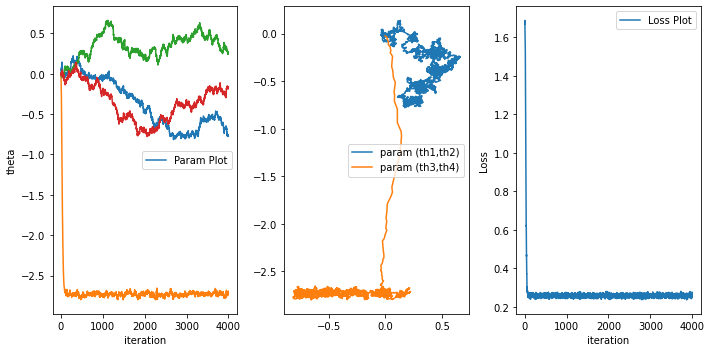

In [156]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
print('After 1000 iteration we have theta =',theta)
axes[0].plot(thdata)
axes[0].set_ylabel('theta')
axes[0].legend(['Param Plot'])
axes[0].set_xlabel('iteration')
axes[1].plot([item[2] for item in thdata],[item[3] for item in thdata],[item[0] for item in thdata],[item[1] for item in thdata])
axes[1].legend(['param (th1,th2)','param (th3,th4)'])

axes[2].plot(progress)
axes[2].legend(['Loss Plot'])
axes[2].set_ylabel('Loss')
axes[2].set_xlabel('iteration')
fig.tight_layout()    

## Two Qubit single data point

### c1=0.01(small movement) delta=0.3+ (small fluctuation)

In [157]:
progress=[];

thdata=[];
theta=[0,0,0,0];
c1=0.01   
delta=6
nshot=3000;
theta=np.array(theta)-SPSA(1,theta,c1,delta,nshot)
for ep in range(4000):
    delta=random.random()+0.3
    theta=theta-SPSA(1,theta,c1,delta,nshot)
    print(ep,"th iteration L=",lossCal2qubit(1,theta,nshot))
    progress.append(lossCal2qubit(1,theta,nshot))
    thdata.append(theta)

0 th iteration L= 1.6726666666666667
1 th iteration L= 1.6686666666666667
2 th iteration L= 1.6446666666666667
3 th iteration L= 1.6733333333333333
4 th iteration L= 1.6433333333333333
5 th iteration L= 1.6360000000000001
6 th iteration L= 1.6473333333333333
7 th iteration L= 1.6746666666666665
8 th iteration L= 1.6653333333333333
9 th iteration L= 1.638
10 th iteration L= 1.6033333333333335
11 th iteration L= 1.6373333333333333
12 th iteration L= 1.6613333333333333
13 th iteration L= 1.6733333333333333
14 th iteration L= 1.65
15 th iteration L= 1.6886666666666668
16 th iteration L= 1.6646666666666667
17 th iteration L= 1.63
18 th iteration L= 1.6433333333333333
19 th iteration L= 1.6333333333333333
20 th iteration L= 1.6413333333333333
21 th iteration L= 1.6213333333333333
22 th iteration L= 1.6360000000000001
23 th iteration L= 1.6226666666666667
24 th iteration L= 1.6346666666666667
25 th iteration L= 1.596
26 th iteration L= 1.6046666666666667
27 th iteration L= 1.5739999999999998


237 th iteration L= 0.33666666666666667
238 th iteration L= 0.3426666666666667
239 th iteration L= 0.3606666666666667
240 th iteration L= 0.32599999999999996
241 th iteration L= 0.32999999999999996
242 th iteration L= 0.30866666666666664
243 th iteration L= 0.30600000000000005
244 th iteration L= 0.32733333333333337
245 th iteration L= 0.30600000000000005
246 th iteration L= 0.30733333333333335
247 th iteration L= 0.2886666666666666
248 th iteration L= 0.29533333333333334
249 th iteration L= 0.33533333333333337
250 th iteration L= 0.28400000000000003
251 th iteration L= 0.2866666666666666
252 th iteration L= 0.31133333333333335
253 th iteration L= 0.2706666666666667
254 th iteration L= 0.29133333333333333
255 th iteration L= 0.30933333333333335
256 th iteration L= 0.29933333333333334
257 th iteration L= 0.30666666666666664
258 th iteration L= 0.29666666666666663
259 th iteration L= 0.29733333333333334
260 th iteration L= 0.2713333333333333
261 th iteration L= 0.29600000000000004
262 th

462 th iteration L= 0.248
463 th iteration L= 0.2826666666666666
464 th iteration L= 0.28933333333333333
465 th iteration L= 0.2713333333333333
466 th iteration L= 0.268
467 th iteration L= 0.2626666666666667
468 th iteration L= 0.242
469 th iteration L= 0.2573333333333333
470 th iteration L= 0.254
471 th iteration L= 0.2573333333333333
472 th iteration L= 0.264
473 th iteration L= 0.2673333333333333
474 th iteration L= 0.2646666666666667
475 th iteration L= 0.2586666666666667
476 th iteration L= 0.23199999999999998
477 th iteration L= 0.2706666666666667
478 th iteration L= 0.256
479 th iteration L= 0.254
480 th iteration L= 0.2673333333333333
481 th iteration L= 0.274
482 th iteration L= 0.2573333333333333
483 th iteration L= 0.2613333333333333
484 th iteration L= 0.22933333333333328
485 th iteration L= 0.262
486 th iteration L= 0.2593333333333333
487 th iteration L= 0.2513333333333333
488 th iteration L= 0.2386666666666667
489 th iteration L= 0.25
490 th iteration L= 0.24533333333333

702 th iteration L= 0.2726666666666666
703 th iteration L= 0.2733333333333333
704 th iteration L= 0.2746666666666666
705 th iteration L= 0.2753333333333333
706 th iteration L= 0.2733333333333333
707 th iteration L= 0.30666666666666664
708 th iteration L= 0.2693333333333333
709 th iteration L= 0.2846666666666666
710 th iteration L= 0.28
711 th iteration L= 0.2833333333333333
712 th iteration L= 0.29066666666666663
713 th iteration L= 0.28400000000000003
714 th iteration L= 0.2806666666666666
715 th iteration L= 0.272
716 th iteration L= 0.28200000000000003
717 th iteration L= 0.2673333333333333
718 th iteration L= 0.2666666666666667
719 th iteration L= 0.2793333333333333
720 th iteration L= 0.2653333333333333
721 th iteration L= 0.2846666666666666
722 th iteration L= 0.2786666666666666
723 th iteration L= 0.29600000000000004
724 th iteration L= 0.272
725 th iteration L= 0.2726666666666666
726 th iteration L= 0.2613333333333333
727 th iteration L= 0.2673333333333333
728 th iteration L= 0

930 th iteration L= 0.272
931 th iteration L= 0.2766666666666666
932 th iteration L= 0.2626666666666667
933 th iteration L= 0.2506666666666667
934 th iteration L= 0.2633333333333333
935 th iteration L= 0.26
936 th iteration L= 0.264
937 th iteration L= 0.2766666666666666
938 th iteration L= 0.2673333333333333
939 th iteration L= 0.2606666666666667
940 th iteration L= 0.274
941 th iteration L= 0.2553333333333333
942 th iteration L= 0.2633333333333333
943 th iteration L= 0.248
944 th iteration L= 0.2593333333333333
945 th iteration L= 0.2513333333333333
946 th iteration L= 0.2786666666666666
947 th iteration L= 0.2586666666666667
948 th iteration L= 0.2366666666666667
949 th iteration L= 0.2533333333333333
950 th iteration L= 0.2486666666666667
951 th iteration L= 0.2386666666666667
952 th iteration L= 0.2386666666666667
953 th iteration L= 0.2813333333333333
954 th iteration L= 0.2813333333333333
955 th iteration L= 0.2546666666666667
956 th iteration L= 0.2393333333333333
957 th iterat

1158 th iteration L= 0.2533333333333333
1159 th iteration L= 0.2746666666666666
1160 th iteration L= 0.2626666666666667
1161 th iteration L= 0.252
1162 th iteration L= 0.2653333333333333
1163 th iteration L= 0.238
1164 th iteration L= 0.278
1165 th iteration L= 0.2526666666666667
1166 th iteration L= 0.27
1167 th iteration L= 0.27
1168 th iteration L= 0.2766666666666666
1169 th iteration L= 0.2653333333333333
1170 th iteration L= 0.2853333333333333
1171 th iteration L= 0.254
1172 th iteration L= 0.2673333333333333
1173 th iteration L= 0.2386666666666667
1174 th iteration L= 0.244
1175 th iteration L= 0.2693333333333333
1176 th iteration L= 0.254
1177 th iteration L= 0.266
1178 th iteration L= 0.2453333333333333
1179 th iteration L= 0.2406666666666667
1180 th iteration L= 0.2673333333333333
1181 th iteration L= 0.2533333333333333
1182 th iteration L= 0.2573333333333333
1183 th iteration L= 0.258
1184 th iteration L= 0.2646666666666667
1185 th iteration L= 0.2706666666666667
1186 th iter

1385 th iteration L= 0.29333333333333333
1386 th iteration L= 0.2693333333333333
1387 th iteration L= 0.2593333333333333
1388 th iteration L= 0.29133333333333333
1389 th iteration L= 0.27
1390 th iteration L= 0.2646666666666667
1391 th iteration L= 0.2666666666666667
1392 th iteration L= 0.2593333333333333
1393 th iteration L= 0.2633333333333333
1394 th iteration L= 0.264
1395 th iteration L= 0.2546666666666667
1396 th iteration L= 0.2693333333333333
1397 th iteration L= 0.2733333333333333
1398 th iteration L= 0.264
1399 th iteration L= 0.2533333333333333
1400 th iteration L= 0.2526666666666667
1401 th iteration L= 0.2593333333333333
1402 th iteration L= 0.28
1403 th iteration L= 0.28600000000000003
1404 th iteration L= 0.258
1405 th iteration L= 0.2726666666666666
1406 th iteration L= 0.29333333333333333
1407 th iteration L= 0.2713333333333333
1408 th iteration L= 0.2733333333333333
1409 th iteration L= 0.2886666666666666
1410 th iteration L= 0.2393333333333333
1411 th iteration L= 0.

1610 th iteration L= 0.248
1611 th iteration L= 0.2533333333333333
1612 th iteration L= 0.238
1613 th iteration L= 0.254
1614 th iteration L= 0.2673333333333333
1615 th iteration L= 0.2773333333333333
1616 th iteration L= 0.2606666666666667
1617 th iteration L= 0.262
1618 th iteration L= 0.2613333333333333
1619 th iteration L= 0.2646666666666667
1620 th iteration L= 0.2573333333333333
1621 th iteration L= 0.266
1622 th iteration L= 0.254
1623 th iteration L= 0.2753333333333333
1624 th iteration L= 0.29466666666666663
1625 th iteration L= 0.2386666666666667
1626 th iteration L= 0.2753333333333333
1627 th iteration L= 0.246
1628 th iteration L= 0.2753333333333333
1629 th iteration L= 0.2473333333333333
1630 th iteration L= 0.2586666666666667
1631 th iteration L= 0.256
1632 th iteration L= 0.27
1633 th iteration L= 0.2686666666666667
1634 th iteration L= 0.2413333333333333
1635 th iteration L= 0.258
1636 th iteration L= 0.2713333333333333
1637 th iteration L= 0.2566666666666667
1638 th it

1844 th iteration L= 0.23533333333333328
1845 th iteration L= 0.2533333333333333
1846 th iteration L= 0.26
1847 th iteration L= 0.2726666666666666
1848 th iteration L= 0.236
1849 th iteration L= 0.2533333333333333
1850 th iteration L= 0.272
1851 th iteration L= 0.264
1852 th iteration L= 0.242
1853 th iteration L= 0.262
1854 th iteration L= 0.264
1855 th iteration L= 0.2473333333333333
1856 th iteration L= 0.258
1857 th iteration L= 0.29266666666666663
1858 th iteration L= 0.276
1859 th iteration L= 0.2633333333333333
1860 th iteration L= 0.2533333333333333
1861 th iteration L= 0.28
1862 th iteration L= 0.2713333333333333
1863 th iteration L= 0.252
1864 th iteration L= 0.2733333333333333
1865 th iteration L= 0.248
1866 th iteration L= 0.26
1867 th iteration L= 0.2533333333333333
1868 th iteration L= 0.2713333333333333
1869 th iteration L= 0.2453333333333333
1870 th iteration L= 0.266
1871 th iteration L= 0.2693333333333333
1872 th iteration L= 0.2866666666666666
1873 th iteration L= 0.

2072 th iteration L= 0.23533333333333328
2073 th iteration L= 0.274
2074 th iteration L= 0.2506666666666667
2075 th iteration L= 0.29466666666666663
2076 th iteration L= 0.2653333333333333
2077 th iteration L= 0.2573333333333333
2078 th iteration L= 0.2613333333333333
2079 th iteration L= 0.258
2080 th iteration L= 0.274
2081 th iteration L= 0.2666666666666667
2082 th iteration L= 0.266
2083 th iteration L= 0.2753333333333333
2084 th iteration L= 0.2713333333333333
2085 th iteration L= 0.2646666666666667
2086 th iteration L= 0.278
2087 th iteration L= 0.258
2088 th iteration L= 0.28
2089 th iteration L= 0.2486666666666667
2090 th iteration L= 0.268
2091 th iteration L= 0.2506666666666667
2092 th iteration L= 0.2613333333333333
2093 th iteration L= 0.2653333333333333
2094 th iteration L= 0.2473333333333333
2095 th iteration L= 0.2673333333333333
2096 th iteration L= 0.2546666666666667
2097 th iteration L= 0.264
2098 th iteration L= 0.2633333333333333
2099 th iteration L= 0.278
2100 th i

2303 th iteration L= 0.2666666666666667
2304 th iteration L= 0.2706666666666667
2305 th iteration L= 0.264
2306 th iteration L= 0.252
2307 th iteration L= 0.2666666666666667
2308 th iteration L= 0.2426666666666667
2309 th iteration L= 0.26
2310 th iteration L= 0.266
2311 th iteration L= 0.2553333333333333
2312 th iteration L= 0.2553333333333333
2313 th iteration L= 0.2533333333333333
2314 th iteration L= 0.2613333333333333
2315 th iteration L= 0.2593333333333333
2316 th iteration L= 0.2426666666666667
2317 th iteration L= 0.2593333333333333
2318 th iteration L= 0.268
2319 th iteration L= 0.2513333333333333
2320 th iteration L= 0.2586666666666667
2321 th iteration L= 0.24
2322 th iteration L= 0.2766666666666666
2323 th iteration L= 0.2613333333333333
2324 th iteration L= 0.2586666666666667
2325 th iteration L= 0.2573333333333333
2326 th iteration L= 0.29533333333333334
2327 th iteration L= 0.2606666666666667
2328 th iteration L= 0.23333333333333328
2329 th iteration L= 0.260666666666666

2533 th iteration L= 0.256
2534 th iteration L= 0.2486666666666667
2535 th iteration L= 0.2593333333333333
2536 th iteration L= 0.2733333333333333
2537 th iteration L= 0.2533333333333333
2538 th iteration L= 0.262
2539 th iteration L= 0.2466666666666667
2540 th iteration L= 0.278
2541 th iteration L= 0.2646666666666667
2542 th iteration L= 0.2433333333333333
2543 th iteration L= 0.2546666666666667
2544 th iteration L= 0.256
2545 th iteration L= 0.2606666666666667
2546 th iteration L= 0.2633333333333333
2547 th iteration L= 0.2553333333333333
2548 th iteration L= 0.2466666666666667
2549 th iteration L= 0.262
2550 th iteration L= 0.2653333333333333
2551 th iteration L= 0.28200000000000003
2552 th iteration L= 0.2573333333333333
2553 th iteration L= 0.2526666666666667
2554 th iteration L= 0.266
2555 th iteration L= 0.2866666666666666
2556 th iteration L= 0.2686666666666667
2557 th iteration L= 0.2473333333333333
2558 th iteration L= 0.2666666666666667
2559 th iteration L= 0.26666666666666

2758 th iteration L= 0.2653333333333333
2759 th iteration L= 0.2553333333333333
2760 th iteration L= 0.256
2761 th iteration L= 0.2573333333333333
2762 th iteration L= 0.2553333333333333
2763 th iteration L= 0.2566666666666667
2764 th iteration L= 0.2713333333333333
2765 th iteration L= 0.25
2766 th iteration L= 0.2386666666666667
2767 th iteration L= 0.24
2768 th iteration L= 0.258
2769 th iteration L= 0.276
2770 th iteration L= 0.254
2771 th iteration L= 0.2533333333333333
2772 th iteration L= 0.2546666666666667
2773 th iteration L= 0.258
2774 th iteration L= 0.2553333333333333
2775 th iteration L= 0.274
2776 th iteration L= 0.244
2777 th iteration L= 0.2633333333333333
2778 th iteration L= 0.274
2779 th iteration L= 0.2686666666666667
2780 th iteration L= 0.23199999999999998
2781 th iteration L= 0.252
2782 th iteration L= 0.2386666666666667
2783 th iteration L= 0.2673333333333333
2784 th iteration L= 0.2773333333333333
2785 th iteration L= 0.2673333333333333
2786 th iteration L= 0.2

2985 th iteration L= 0.2686666666666667
2986 th iteration L= 0.262
2987 th iteration L= 0.2593333333333333
2988 th iteration L= 0.2626666666666667
2989 th iteration L= 0.23733333333333329
2990 th iteration L= 0.2766666666666666
2991 th iteration L= 0.29133333333333333
2992 th iteration L= 0.27
2993 th iteration L= 0.2673333333333333
2994 th iteration L= 0.2493333333333333
2995 th iteration L= 0.246
2996 th iteration L= 0.2526666666666667
2997 th iteration L= 0.2686666666666667
2998 th iteration L= 0.2746666666666666
2999 th iteration L= 0.2473333333333333
3000 th iteration L= 0.2753333333333333
3001 th iteration L= 0.2626666666666667
3002 th iteration L= 0.2606666666666667
3003 th iteration L= 0.264
3004 th iteration L= 0.242
3005 th iteration L= 0.2713333333333333
3006 th iteration L= 0.2566666666666667
3007 th iteration L= 0.256
3008 th iteration L= 0.254
3009 th iteration L= 0.2546666666666667
3010 th iteration L= 0.272
3011 th iteration L= 0.2693333333333333
3012 th iteration L= 0.

3213 th iteration L= 0.2793333333333333
3214 th iteration L= 0.2546666666666667
3215 th iteration L= 0.2626666666666667
3216 th iteration L= 0.2506666666666667
3217 th iteration L= 0.2773333333333333
3218 th iteration L= 0.248
3219 th iteration L= 0.2653333333333333
3220 th iteration L= 0.238
3221 th iteration L= 0.2513333333333333
3222 th iteration L= 0.2413333333333333
3223 th iteration L= 0.2606666666666667
3224 th iteration L= 0.268
3225 th iteration L= 0.2733333333333333
3226 th iteration L= 0.2633333333333333
3227 th iteration L= 0.2653333333333333
3228 th iteration L= 0.2413333333333333
3229 th iteration L= 0.2606666666666667
3230 th iteration L= 0.2486666666666667
3231 th iteration L= 0.29133333333333333
3232 th iteration L= 0.2486666666666667
3233 th iteration L= 0.2713333333333333
3234 th iteration L= 0.256
3235 th iteration L= 0.2826666666666666
3236 th iteration L= 0.2733333333333333
3237 th iteration L= 0.2526666666666667
3238 th iteration L= 0.252
3239 th iteration L= 0.2

3444 th iteration L= 0.22466666666666668
3445 th iteration L= 0.2546666666666667
3446 th iteration L= 0.262
3447 th iteration L= 0.2773333333333333
3448 th iteration L= 0.2413333333333333
3449 th iteration L= 0.254
3450 th iteration L= 0.29000000000000004
3451 th iteration L= 0.2786666666666666
3452 th iteration L= 0.2686666666666667
3453 th iteration L= 0.2573333333333333
3454 th iteration L= 0.26
3455 th iteration L= 0.2413333333333333
3456 th iteration L= 0.2433333333333333
3457 th iteration L= 0.2546666666666667
3458 th iteration L= 0.23133333333333328
3459 th iteration L= 0.2706666666666667
3460 th iteration L= 0.2693333333333333
3461 th iteration L= 0.2666666666666667
3462 th iteration L= 0.2733333333333333
3463 th iteration L= 0.278
3464 th iteration L= 0.2566666666666667
3465 th iteration L= 0.26
3466 th iteration L= 0.274
3467 th iteration L= 0.276
3468 th iteration L= 0.2753333333333333
3469 th iteration L= 0.276
3470 th iteration L= 0.26
3471 th iteration L= 0.26533333333333

3668 th iteration L= 0.264
3669 th iteration L= 0.29466666666666663
3670 th iteration L= 0.254
3671 th iteration L= 0.2486666666666667
3672 th iteration L= 0.2613333333333333
3673 th iteration L= 0.246
3674 th iteration L= 0.264
3675 th iteration L= 0.266
3676 th iteration L= 0.266
3677 th iteration L= 0.2366666666666667
3678 th iteration L= 0.2753333333333333
3679 th iteration L= 0.2706666666666667
3680 th iteration L= 0.2493333333333333
3681 th iteration L= 0.248
3682 th iteration L= 0.2453333333333333
3683 th iteration L= 0.2653333333333333
3684 th iteration L= 0.2413333333333333
3685 th iteration L= 0.252
3686 th iteration L= 0.2533333333333333
3687 th iteration L= 0.256
3688 th iteration L= 0.2813333333333333
3689 th iteration L= 0.258
3690 th iteration L= 0.2633333333333333
3691 th iteration L= 0.2633333333333333
3692 th iteration L= 0.2746666666666666
3693 th iteration L= 0.2613333333333333
3694 th iteration L= 0.254
3695 th iteration L= 0.266
3696 th iteration L= 0.254666666666

3902 th iteration L= 0.2686666666666667
3903 th iteration L= 0.2626666666666667
3904 th iteration L= 0.2513333333333333
3905 th iteration L= 0.2486666666666667
3906 th iteration L= 0.2806666666666666
3907 th iteration L= 0.2693333333333333
3908 th iteration L= 0.2513333333333333
3909 th iteration L= 0.2446666666666667
3910 th iteration L= 0.2566666666666667
3911 th iteration L= 0.252
3912 th iteration L= 0.23399999999999999
3913 th iteration L= 0.2673333333333333
3914 th iteration L= 0.2693333333333333
3915 th iteration L= 0.2713333333333333
3916 th iteration L= 0.2673333333333333
3917 th iteration L= 0.2846666666666666
3918 th iteration L= 0.2526666666666667
3919 th iteration L= 0.25
3920 th iteration L= 0.248
3921 th iteration L= 0.248
3922 th iteration L= 0.258
3923 th iteration L= 0.2573333333333333
3924 th iteration L= 0.2646666666666667
3925 th iteration L= 0.268
3926 th iteration L= 0.2593333333333333
3927 th iteration L= 0.254
3928 th iteration L= 0.23533333333333328
3929 th it

After 1000 iteration we have theta = [ 0.35167368 -2.75101446 -1.66286682  0.72911323]


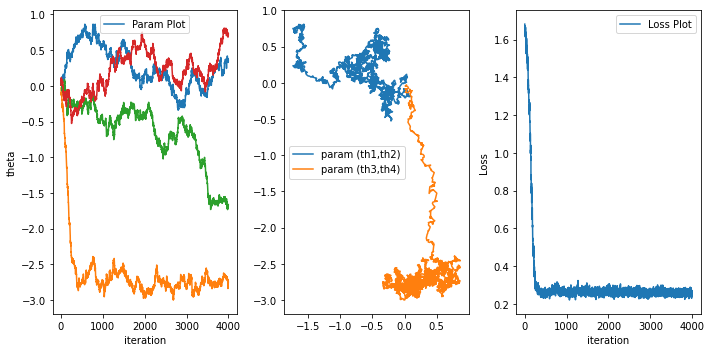

In [158]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
print('After 1000 iteration we have theta =',theta)
axes[0].plot(thdata)
axes[0].set_ylabel('theta')
axes[0].legend(['Param Plot'])
axes[0].set_xlabel('iteration')
axes[1].plot([item[2] for item in thdata],[item[3] for item in thdata],[item[0] for item in thdata],[item[1] for item in thdata])
axes[1].legend(['param (th1,th2)','param (th3,th4)'])

axes[2].plot(progress)
axes[2].legend(['Loss Plot'])
axes[2].set_ylabel('Loss')
axes[2].set_xlabel('iteration')
fig.tight_layout()

### c1=0.01(small movement) delta=0.1+ (medium fluctuation)

In [159]:
progress=[];
theta=[0,0,0,0];
thdata=[];

c1=0.01   
delta=6
nshot=3000;
theta=np.array(theta)-SPSA(1,theta,c1,delta,nshot)
for ep in range(4000):
    delta=random.random()+0.1
    theta=theta-SPSA(1,theta,c1,delta,nshot)
    print(ep,"th iteration L=",lossCal2qubit(1,theta,nshot))
    progress.append(lossCal2qubit(1,theta,nshot))
    thdata.append(theta)

0 th iteration L= 1.6973333333333334
1 th iteration L= 1.692
2 th iteration L= 1.6733333333333333
3 th iteration L= 1.6853333333333333
4 th iteration L= 1.6653333333333333
5 th iteration L= 1.6706666666666665
6 th iteration L= 1.6586666666666665
7 th iteration L= 1.688
8 th iteration L= 1.6526666666666667
9 th iteration L= 1.6393333333333333
10 th iteration L= 1.6413333333333333
11 th iteration L= 1.6453333333333333
12 th iteration L= 1.6426666666666667
13 th iteration L= 1.654
14 th iteration L= 1.6406666666666667
15 th iteration L= 1.6413333333333333
16 th iteration L= 1.6640000000000001
17 th iteration L= 1.6466666666666665
18 th iteration L= 1.6133333333333333
19 th iteration L= 1.616
20 th iteration L= 1.6066666666666667
21 th iteration L= 1.5966666666666667
22 th iteration L= 1.592
23 th iteration L= 1.5993333333333335
24 th iteration L= 1.6086666666666667
25 th iteration L= 1.6013333333333333
26 th iteration L= 1.6
27 th iteration L= 1.5613333333333332
28 th iteration L= 1.58733

228 th iteration L= 0.3993333333333333
229 th iteration L= 0.368
230 th iteration L= 0.33999999999999997
231 th iteration L= 0.3433333333333334
232 th iteration L= 0.3893333333333333
233 th iteration L= 0.3493333333333334
234 th iteration L= 0.3433333333333334
235 th iteration L= 0.3506666666666667
236 th iteration L= 0.382
237 th iteration L= 0.3426666666666667
238 th iteration L= 0.356
239 th iteration L= 0.32599999999999996
240 th iteration L= 0.33466666666666667
241 th iteration L= 0.30400000000000005
242 th iteration L= 0.29066666666666663
243 th iteration L= 0.30266666666666664
244 th iteration L= 0.31266666666666665
245 th iteration L= 0.3406666666666667
246 th iteration L= 0.29933333333333334
247 th iteration L= 0.30933333333333335
248 th iteration L= 0.30266666666666664
249 th iteration L= 0.30466666666666664
250 th iteration L= 0.30600000000000005
251 th iteration L= 0.29866666666666664
252 th iteration L= 0.30800000000000005
253 th iteration L= 0.31666666666666665
254 th ite

462 th iteration L= 0.2553333333333333
463 th iteration L= 0.2793333333333333
464 th iteration L= 0.2706666666666667
465 th iteration L= 0.238
466 th iteration L= 0.2626666666666667
467 th iteration L= 0.2466666666666667
468 th iteration L= 0.2673333333333333
469 th iteration L= 0.2666666666666667
470 th iteration L= 0.2406666666666667
471 th iteration L= 0.26
472 th iteration L= 0.2586666666666667
473 th iteration L= 0.2566666666666667
474 th iteration L= 0.264
475 th iteration L= 0.2566666666666667
476 th iteration L= 0.262
477 th iteration L= 0.278
478 th iteration L= 0.2426666666666667
479 th iteration L= 0.2733333333333333
480 th iteration L= 0.258
481 th iteration L= 0.252
482 th iteration L= 0.2806666666666666
483 th iteration L= 0.2486666666666667
484 th iteration L= 0.256
485 th iteration L= 0.2626666666666667
486 th iteration L= 0.2633333333333333
487 th iteration L= 0.264
488 th iteration L= 0.2453333333333333
489 th iteration L= 0.2413333333333333
490 th iteration L= 0.258


696 th iteration L= 0.2673333333333333
697 th iteration L= 0.2406666666666667
698 th iteration L= 0.2626666666666667
699 th iteration L= 0.258
700 th iteration L= 0.2553333333333333
701 th iteration L= 0.254
702 th iteration L= 0.2633333333333333
703 th iteration L= 0.2513333333333333
704 th iteration L= 0.252
705 th iteration L= 0.2793333333333333
706 th iteration L= 0.242
707 th iteration L= 0.25
708 th iteration L= 0.2626666666666667
709 th iteration L= 0.2606666666666667
710 th iteration L= 0.2726666666666666
711 th iteration L= 0.2413333333333333
712 th iteration L= 0.2633333333333333
713 th iteration L= 0.268
714 th iteration L= 0.2526666666666667
715 th iteration L= 0.248
716 th iteration L= 0.2626666666666667
717 th iteration L= 0.2466666666666667
718 th iteration L= 0.2393333333333333
719 th iteration L= 0.2486666666666667
720 th iteration L= 0.258
721 th iteration L= 0.2773333333333333
722 th iteration L= 0.2693333333333333
723 th iteration L= 0.28
724 th iteration L= 0.24133

930 th iteration L= 0.2626666666666667
931 th iteration L= 0.29000000000000004
932 th iteration L= 0.2706666666666667
933 th iteration L= 0.29200000000000004
934 th iteration L= 0.272
935 th iteration L= 0.266
936 th iteration L= 0.2606666666666667
937 th iteration L= 0.2806666666666666
938 th iteration L= 0.2686666666666667
939 th iteration L= 0.28800000000000003
940 th iteration L= 0.2753333333333333
941 th iteration L= 0.29200000000000004
942 th iteration L= 0.28800000000000003
943 th iteration L= 0.2733333333333333
944 th iteration L= 0.2786666666666666
945 th iteration L= 0.29066666666666663
946 th iteration L= 0.29600000000000004
947 th iteration L= 0.30266666666666664
948 th iteration L= 0.32533333333333336
949 th iteration L= 0.31200000000000006
950 th iteration L= 0.32666666666666666
951 th iteration L= 0.31399999999999995
952 th iteration L= 0.3693333333333333
953 th iteration L= 0.3626666666666667
954 th iteration L= 0.3433333333333334
955 th iteration L= 0.3526666666666667


1155 th iteration L= 0.266
1156 th iteration L= 0.2773333333333333
1157 th iteration L= 0.264
1158 th iteration L= 0.2486666666666667
1159 th iteration L= 0.268
1160 th iteration L= 0.2513333333333333
1161 th iteration L= 0.2606666666666667
1162 th iteration L= 0.2546666666666667
1163 th iteration L= 0.2553333333333333
1164 th iteration L= 0.2506666666666667
1165 th iteration L= 0.2486666666666667
1166 th iteration L= 0.2586666666666667
1167 th iteration L= 0.28600000000000003
1168 th iteration L= 0.274
1169 th iteration L= 0.2826666666666666
1170 th iteration L= 0.264
1171 th iteration L= 0.2673333333333333
1172 th iteration L= 0.2453333333333333
1173 th iteration L= 0.2626666666666667
1174 th iteration L= 0.2566666666666667
1175 th iteration L= 0.2813333333333333
1176 th iteration L= 0.27
1177 th iteration L= 0.248
1178 th iteration L= 0.2686666666666667
1179 th iteration L= 0.264
1180 th iteration L= 0.2593333333333333
1181 th iteration L= 0.2626666666666667
1182 th iteration L= 0.2

1385 th iteration L= 0.244
1386 th iteration L= 0.29400000000000004
1387 th iteration L= 0.2626666666666667
1388 th iteration L= 0.2653333333333333
1389 th iteration L= 0.27
1390 th iteration L= 0.2666666666666667
1391 th iteration L= 0.25
1392 th iteration L= 0.2726666666666666
1393 th iteration L= 0.266
1394 th iteration L= 0.2633333333333333
1395 th iteration L= 0.2506666666666667
1396 th iteration L= 0.2606666666666667
1397 th iteration L= 0.2606666666666667
1398 th iteration L= 0.2573333333333333
1399 th iteration L= 0.2473333333333333
1400 th iteration L= 0.256
1401 th iteration L= 0.2826666666666666
1402 th iteration L= 0.2506666666666667
1403 th iteration L= 0.2726666666666666
1404 th iteration L= 0.2533333333333333
1405 th iteration L= 0.2646666666666667
1406 th iteration L= 0.246
1407 th iteration L= 0.278
1408 th iteration L= 0.252
1409 th iteration L= 0.24
1410 th iteration L= 0.2466666666666667
1411 th iteration L= 0.276
1412 th iteration L= 0.262
1413 th iteration L= 0.27

1615 th iteration L= 0.2486666666666667
1616 th iteration L= 0.278
1617 th iteration L= 0.2646666666666667
1618 th iteration L= 0.254
1619 th iteration L= 0.2693333333333333
1620 th iteration L= 0.272
1621 th iteration L= 0.27
1622 th iteration L= 0.2846666666666666
1623 th iteration L= 0.254
1624 th iteration L= 0.2533333333333333
1625 th iteration L= 0.2746666666666666
1626 th iteration L= 0.258
1627 th iteration L= 0.268
1628 th iteration L= 0.2553333333333333
1629 th iteration L= 0.2566666666666667
1630 th iteration L= 0.2553333333333333
1631 th iteration L= 0.268
1632 th iteration L= 0.2533333333333333
1633 th iteration L= 0.24
1634 th iteration L= 0.2833333333333333
1635 th iteration L= 0.274
1636 th iteration L= 0.278
1637 th iteration L= 0.2426666666666667
1638 th iteration L= 0.2586666666666667
1639 th iteration L= 0.2726666666666666
1640 th iteration L= 0.2773333333333333
1641 th iteration L= 0.2466666666666667
1642 th iteration L= 0.2566666666666667
1643 th iteration L= 0.24

1844 th iteration L= 0.2393333333333333
1845 th iteration L= 0.2473333333333333
1846 th iteration L= 0.2593333333333333
1847 th iteration L= 0.28200000000000003
1848 th iteration L= 0.2506666666666667
1849 th iteration L= 0.2473333333333333
1850 th iteration L= 0.2693333333333333
1851 th iteration L= 0.27
1852 th iteration L= 0.272
1853 th iteration L= 0.2666666666666667
1854 th iteration L= 0.2726666666666666
1855 th iteration L= 0.272
1856 th iteration L= 0.2606666666666667
1857 th iteration L= 0.262
1858 th iteration L= 0.2593333333333333
1859 th iteration L= 0.2486666666666667
1860 th iteration L= 0.2746666666666666
1861 th iteration L= 0.2713333333333333
1862 th iteration L= 0.2593333333333333
1863 th iteration L= 0.276
1864 th iteration L= 0.28733333333333333
1865 th iteration L= 0.254
1866 th iteration L= 0.248
1867 th iteration L= 0.266
1868 th iteration L= 0.27
1869 th iteration L= 0.238
1870 th iteration L= 0.248
1871 th iteration L= 0.2486666666666667
1872 th iteration L= 0.

2075 th iteration L= 0.2573333333333333
2076 th iteration L= 0.2786666666666666
2077 th iteration L= 0.2633333333333333
2078 th iteration L= 0.2546666666666667
2079 th iteration L= 0.268
2080 th iteration L= 0.2433333333333333
2081 th iteration L= 0.23533333333333328
2082 th iteration L= 0.2753333333333333
2083 th iteration L= 0.2506666666666667
2084 th iteration L= 0.276
2085 th iteration L= 0.2426666666666667
2086 th iteration L= 0.2426666666666667
2087 th iteration L= 0.2593333333333333
2088 th iteration L= 0.266
2089 th iteration L= 0.2533333333333333
2090 th iteration L= 0.2633333333333333
2091 th iteration L= 0.238
2092 th iteration L= 0.252
2093 th iteration L= 0.2533333333333333
2094 th iteration L= 0.26
2095 th iteration L= 0.2613333333333333
2096 th iteration L= 0.248
2097 th iteration L= 0.246
2098 th iteration L= 0.2633333333333333
2099 th iteration L= 0.276
2100 th iteration L= 0.2546666666666667
2101 th iteration L= 0.246
2102 th iteration L= 0.2706666666666667
2103 th it

2300 th iteration L= 0.2693333333333333
2301 th iteration L= 0.2653333333333333
2302 th iteration L= 0.2666666666666667
2303 th iteration L= 0.256
2304 th iteration L= 0.2593333333333333
2305 th iteration L= 0.2506666666666667
2306 th iteration L= 0.2653333333333333
2307 th iteration L= 0.278
2308 th iteration L= 0.266
2309 th iteration L= 0.2526666666666667
2310 th iteration L= 0.23199999999999998
2311 th iteration L= 0.28933333333333333
2312 th iteration L= 0.2553333333333333
2313 th iteration L= 0.2633333333333333
2314 th iteration L= 0.2633333333333333
2315 th iteration L= 0.2506666666666667
2316 th iteration L= 0.2653333333333333
2317 th iteration L= 0.2653333333333333
2318 th iteration L= 0.2586666666666667
2319 th iteration L= 0.2733333333333333
2320 th iteration L= 0.2726666666666666
2321 th iteration L= 0.2393333333333333
2322 th iteration L= 0.26
2323 th iteration L= 0.2413333333333333
2324 th iteration L= 0.2673333333333333
2325 th iteration L= 0.244
2326 th iteration L= 0.2

2524 th iteration L= 0.27
2525 th iteration L= 0.28600000000000003
2526 th iteration L= 0.2573333333333333
2527 th iteration L= 0.2653333333333333
2528 th iteration L= 0.2573333333333333
2529 th iteration L= 0.2533333333333333
2530 th iteration L= 0.268
2531 th iteration L= 0.2306666666666667
2532 th iteration L= 0.27
2533 th iteration L= 0.28400000000000003
2534 th iteration L= 0.2753333333333333
2535 th iteration L= 0.2573333333333333
2536 th iteration L= 0.2513333333333333
2537 th iteration L= 0.272
2538 th iteration L= 0.2633333333333333
2539 th iteration L= 0.2686666666666667
2540 th iteration L= 0.2653333333333333
2541 th iteration L= 0.2466666666666667
2542 th iteration L= 0.2553333333333333
2543 th iteration L= 0.2506666666666667
2544 th iteration L= 0.258
2545 th iteration L= 0.2506666666666667
2546 th iteration L= 0.264
2547 th iteration L= 0.2553333333333333
2548 th iteration L= 0.28600000000000003
2549 th iteration L= 0.28600000000000003
2550 th iteration L= 0.2633333333333

2746 th iteration L= 0.266
2747 th iteration L= 0.28400000000000003
2748 th iteration L= 0.266
2749 th iteration L= 0.23533333333333328
2750 th iteration L= 0.2446666666666667
2751 th iteration L= 0.2573333333333333
2752 th iteration L= 0.264
2753 th iteration L= 0.2566666666666667
2754 th iteration L= 0.2646666666666667
2755 th iteration L= 0.2706666666666667
2756 th iteration L= 0.2753333333333333
2757 th iteration L= 0.246
2758 th iteration L= 0.2513333333333333
2759 th iteration L= 0.28
2760 th iteration L= 0.2606666666666667
2761 th iteration L= 0.2673333333333333
2762 th iteration L= 0.236
2763 th iteration L= 0.2666666666666667
2764 th iteration L= 0.2606666666666667
2765 th iteration L= 0.2586666666666667
2766 th iteration L= 0.2733333333333333
2767 th iteration L= 0.25
2768 th iteration L= 0.2593333333333333
2769 th iteration L= 0.25
2770 th iteration L= 0.2493333333333333
2771 th iteration L= 0.2693333333333333
2772 th iteration L= 0.2626666666666667
2773 th iteration L= 0.24

2971 th iteration L= 0.2853333333333333
2972 th iteration L= 0.25
2973 th iteration L= 0.2526666666666667
2974 th iteration L= 0.2666666666666667
2975 th iteration L= 0.2666666666666667
2976 th iteration L= 0.2646666666666667
2977 th iteration L= 0.2773333333333333
2978 th iteration L= 0.23733333333333329
2979 th iteration L= 0.2326666666666667
2980 th iteration L= 0.2386666666666667
2981 th iteration L= 0.2506666666666667
2982 th iteration L= 0.2566666666666667
2983 th iteration L= 0.248
2984 th iteration L= 0.2526666666666667
2985 th iteration L= 0.2746666666666666
2986 th iteration L= 0.254
2987 th iteration L= 0.23533333333333328
2988 th iteration L= 0.2653333333333333
2989 th iteration L= 0.2513333333333333
2990 th iteration L= 0.2653333333333333
2991 th iteration L= 0.2606666666666667
2992 th iteration L= 0.2573333333333333
2993 th iteration L= 0.2646666666666667
2994 th iteration L= 0.28733333333333333
2995 th iteration L= 0.23533333333333328
2996 th iteration L= 0.2353333333333

3198 th iteration L= 0.2693333333333333
3199 th iteration L= 0.248
3200 th iteration L= 0.2866666666666666
3201 th iteration L= 0.2386666666666667
3202 th iteration L= 0.276
3203 th iteration L= 0.2626666666666667
3204 th iteration L= 0.2693333333333333
3205 th iteration L= 0.276
3206 th iteration L= 0.278
3207 th iteration L= 0.268
3208 th iteration L= 0.2773333333333333
3209 th iteration L= 0.2606666666666667
3210 th iteration L= 0.262
3211 th iteration L= 0.242
3212 th iteration L= 0.2786666666666666
3213 th iteration L= 0.2593333333333333
3214 th iteration L= 0.252
3215 th iteration L= 0.2506666666666667
3216 th iteration L= 0.256
3217 th iteration L= 0.272
3218 th iteration L= 0.2393333333333333
3219 th iteration L= 0.2466666666666667
3220 th iteration L= 0.2866666666666666
3221 th iteration L= 0.2366666666666667
3222 th iteration L= 0.2653333333333333
3223 th iteration L= 0.2533333333333333
3224 th iteration L= 0.248
3225 th iteration L= 0.2533333333333333
3226 th iteration L= 0.

3425 th iteration L= 0.2653333333333333
3426 th iteration L= 0.2533333333333333
3427 th iteration L= 0.2773333333333333
3428 th iteration L= 0.27
3429 th iteration L= 0.2573333333333333
3430 th iteration L= 0.2473333333333333
3431 th iteration L= 0.27
3432 th iteration L= 0.2533333333333333
3433 th iteration L= 0.266
3434 th iteration L= 0.26
3435 th iteration L= 0.2853333333333333
3436 th iteration L= 0.2826666666666666
3437 th iteration L= 0.2586666666666667
3438 th iteration L= 0.274
3439 th iteration L= 0.28600000000000003
3440 th iteration L= 0.2633333333333333
3441 th iteration L= 0.274
3442 th iteration L= 0.28933333333333333
3443 th iteration L= 0.28600000000000003
3444 th iteration L= 0.2673333333333333
3445 th iteration L= 0.27
3446 th iteration L= 0.2666666666666667
3447 th iteration L= 0.254
3448 th iteration L= 0.2493333333333333
3449 th iteration L= 0.276
3450 th iteration L= 0.2866666666666666
3451 th iteration L= 0.2493333333333333
3452 th iteration L= 0.269333333333333

3656 th iteration L= 0.2713333333333333
3657 th iteration L= 0.2533333333333333
3658 th iteration L= 0.252
3659 th iteration L= 0.2713333333333333
3660 th iteration L= 0.272
3661 th iteration L= 0.252
3662 th iteration L= 0.2573333333333333
3663 th iteration L= 0.2393333333333333
3664 th iteration L= 0.2706666666666667
3665 th iteration L= 0.244
3666 th iteration L= 0.2546666666666667
3667 th iteration L= 0.2546666666666667
3668 th iteration L= 0.2613333333333333
3669 th iteration L= 0.256
3670 th iteration L= 0.2686666666666667
3671 th iteration L= 0.2606666666666667
3672 th iteration L= 0.272
3673 th iteration L= 0.2813333333333333
3674 th iteration L= 0.2686666666666667
3675 th iteration L= 0.268
3676 th iteration L= 0.2713333333333333
3677 th iteration L= 0.2673333333333333
3678 th iteration L= 0.262
3679 th iteration L= 0.2626666666666667
3680 th iteration L= 0.2626666666666667
3681 th iteration L= 0.254
3682 th iteration L= 0.2613333333333333
3683 th iteration L= 0.24866666666666

3886 th iteration L= 0.2773333333333333
3887 th iteration L= 0.2673333333333333
3888 th iteration L= 0.2806666666666666
3889 th iteration L= 0.2606666666666667
3890 th iteration L= 0.2866666666666666
3891 th iteration L= 0.2586666666666667
3892 th iteration L= 0.28200000000000003
3893 th iteration L= 0.2626666666666667
3894 th iteration L= 0.2726666666666666
3895 th iteration L= 0.2793333333333333
3896 th iteration L= 0.2566666666666667
3897 th iteration L= 0.2666666666666667
3898 th iteration L= 0.28200000000000003
3899 th iteration L= 0.2706666666666667
3900 th iteration L= 0.244
3901 th iteration L= 0.264
3902 th iteration L= 0.26
3903 th iteration L= 0.2506666666666667
3904 th iteration L= 0.2626666666666667
3905 th iteration L= 0.2586666666666667
3906 th iteration L= 0.2726666666666666
3907 th iteration L= 0.2406666666666667
3908 th iteration L= 0.262
3909 th iteration L= 0.2706666666666667
3910 th iteration L= 0.2593333333333333
3911 th iteration L= 0.2433333333333333
3912 th ite

After 1000 iteration we have theta = [ 2.68933459 -2.81553331 -1.58911096  0.06151941]


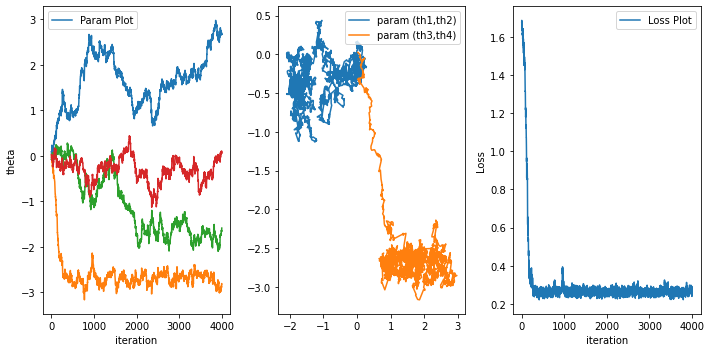

In [160]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
print('After 1000 iteration we have theta =',theta)
axes[0].plot(thdata)
axes[0].set_ylabel('theta')
axes[0].legend(['Param Plot'])
axes[0].set_xlabel('iteration')
axes[1].plot([item[2] for item in thdata],[item[3] for item in thdata],[item[0] for item in thdata],[item[1] for item in thdata])
axes[1].legend(['param (th1,th2)','param (th3,th4)'])

axes[2].plot(progress)
axes[2].legend(['Loss Plot'])
axes[2].set_ylabel('Loss')
axes[2].set_xlabel('iteration')
fig.tight_layout()

### c1=0.01(small movement) delta=0+ (Large fluctuation)

In [161]:
progress=[];
theta=[0,0,0,0];
thdata=[];

c1=0.01   
delta=6
nshot=3000;
theta=np.array(theta)-SPSA(1,theta,c1,delta,nshot)
for ep in range(4000):
    delta=random.random()
    theta=theta-SPSA(1,theta,c1,delta,nshot)
    print(ep,"th iteration L=",lossCal2qubit(1,theta,nshot))
    progress.append(lossCal2qubit(1,theta,nshot))
    thdata.append(theta)

0 th iteration L= 1.6800000000000002
1 th iteration L= 1.6760000000000002
2 th iteration L= 1.6560000000000001
3 th iteration L= 1.6633333333333333
4 th iteration L= 1.6786666666666665
5 th iteration L= 1.6773333333333333
6 th iteration L= 1.6666666666666665
7 th iteration L= 1.6600000000000001
8 th iteration L= 1.69
9 th iteration L= 1.658
10 th iteration L= 1.6633333333333333
11 th iteration L= 1.638
12 th iteration L= 1.6513333333333333
13 th iteration L= 1.6146666666666667
14 th iteration L= 1.6440000000000001
15 th iteration L= 1.6393333333333333
16 th iteration L= 1.604
17 th iteration L= 1.6306666666666667
18 th iteration L= 1.6113333333333333
19 th iteration L= 1.6206666666666667
20 th iteration L= 1.6333333333333333
21 th iteration L= 1.6153333333333333
22 th iteration L= 1.588
23 th iteration L= 1.6206666666666667
24 th iteration L= 1.5979999999999999
25 th iteration L= 1.6113333333333333
26 th iteration L= 1.572
27 th iteration L= 1.6046666666666667
28 th iteration L= 1.6053

237 th iteration L= 0.4813333333333333
238 th iteration L= 0.4733333333333334
239 th iteration L= 0.5246666666666666
240 th iteration L= 0.4946666666666667
241 th iteration L= 0.4933333333333333
242 th iteration L= 0.4826666666666667
243 th iteration L= 0.5113333333333333
244 th iteration L= 0.506
245 th iteration L= 0.5306666666666666
246 th iteration L= 0.5146666666666666
247 th iteration L= 0.4746666666666667
248 th iteration L= 0.5206666666666666
249 th iteration L= 0.5473333333333333
250 th iteration L= 0.542
251 th iteration L= 0.5326666666666666
252 th iteration L= 0.5
253 th iteration L= 0.502
254 th iteration L= 0.504
255 th iteration L= 0.4746666666666667
256 th iteration L= 0.4806666666666667
257 th iteration L= 0.45866666666666667
258 th iteration L= 0.4613333333333334
259 th iteration L= 0.46199999999999997
260 th iteration L= 0.44733333333333336
261 th iteration L= 0.546
262 th iteration L= 0.4633333333333334
263 th iteration L= 0.4613333333333334
264 th iteration L= 0.46

465 th iteration L= 0.2866666666666666
466 th iteration L= 0.29000000000000004
467 th iteration L= 0.2693333333333333
468 th iteration L= 0.278
469 th iteration L= 0.22666666666666668
470 th iteration L= 0.29000000000000004
471 th iteration L= 0.29000000000000004
472 th iteration L= 0.26
473 th iteration L= 0.2646666666666667
474 th iteration L= 0.2766666666666666
475 th iteration L= 0.268
476 th iteration L= 0.2826666666666666
477 th iteration L= 0.2573333333333333
478 th iteration L= 0.2713333333333333
479 th iteration L= 0.2666666666666667
480 th iteration L= 0.2673333333333333
481 th iteration L= 0.2593333333333333
482 th iteration L= 0.2413333333333333
483 th iteration L= 0.268
484 th iteration L= 0.2546666666666667
485 th iteration L= 0.28400000000000003
486 th iteration L= 0.25
487 th iteration L= 0.264
488 th iteration L= 1.424
489 th iteration L= 1.418
490 th iteration L= 1.3780000000000001
491 th iteration L= 1.388
492 th iteration L= 1.3333333333333333
493 th iteration L= 1.

696 th iteration L= 0.272
697 th iteration L= 0.31066666666666665
698 th iteration L= 0.2733333333333333
699 th iteration L= 0.2613333333333333
700 th iteration L= 0.29000000000000004
701 th iteration L= 0.31466666666666665
702 th iteration L= 0.28800000000000003
703 th iteration L= 0.2793333333333333
704 th iteration L= 0.2886666666666666
705 th iteration L= 0.2806666666666666
706 th iteration L= 0.2626666666666667
707 th iteration L= 0.29000000000000004
708 th iteration L= 0.2726666666666666
709 th iteration L= 0.2773333333333333
710 th iteration L= 0.2686666666666667
711 th iteration L= 0.2713333333333333
712 th iteration L= 0.29466666666666663
713 th iteration L= 0.27
714 th iteration L= 0.29000000000000004
715 th iteration L= 0.29600000000000004
716 th iteration L= 0.2813333333333333
717 th iteration L= 0.2713333333333333
718 th iteration L= 0.2493333333333333
719 th iteration L= 0.27
720 th iteration L= 0.2666666666666667
721 th iteration L= 0.27
722 th iteration L= 0.24333333333

928 th iteration L= 0.2826666666666666
929 th iteration L= 0.274
930 th iteration L= 0.28933333333333333
931 th iteration L= 0.2713333333333333
932 th iteration L= 0.274
933 th iteration L= 0.2746666666666666
934 th iteration L= 0.2546666666666667
935 th iteration L= 0.264
936 th iteration L= 0.24
937 th iteration L= 0.26
938 th iteration L= 0.2673333333333333
939 th iteration L= 0.22933333333333328
940 th iteration L= 0.2453333333333333
941 th iteration L= 0.2713333333333333
942 th iteration L= 0.28800000000000003
943 th iteration L= 0.2753333333333333
944 th iteration L= 0.29400000000000004
945 th iteration L= 0.29133333333333333
946 th iteration L= 0.2826666666666666
947 th iteration L= 0.274
948 th iteration L= 0.30000000000000004
949 th iteration L= 0.2686666666666667
950 th iteration L= 0.2833333333333333
951 th iteration L= 0.2853333333333333
952 th iteration L= 0.2626666666666667
953 th iteration L= 0.2606666666666667
954 th iteration L= 0.266
955 th iteration L= 0.274
956 th i

1146 th iteration L= 0.30533333333333335
1147 th iteration L= 0.31399999999999995
1148 th iteration L= 0.2886666666666666
1149 th iteration L= 0.32666666666666666
1150 th iteration L= 0.30866666666666664
1151 th iteration L= 0.29533333333333334
1152 th iteration L= 0.2833333333333333
1153 th iteration L= 0.2826666666666666
1154 th iteration L= 0.2786666666666666
1155 th iteration L= 0.33133333333333337
1156 th iteration L= 0.28800000000000003
1157 th iteration L= 0.31399999999999995
1158 th iteration L= 0.30733333333333335
1159 th iteration L= 0.30800000000000005
1160 th iteration L= 0.30266666666666664
1161 th iteration L= 0.30733333333333335
1162 th iteration L= 0.29800000000000004
1163 th iteration L= 0.28600000000000003
1164 th iteration L= 0.29200000000000004
1165 th iteration L= 0.30333333333333334
1166 th iteration L= 0.30200000000000005
1167 th iteration L= 0.2813333333333333
1168 th iteration L= 0.2793333333333333
1169 th iteration L= 0.30733333333333335
1170 th iteration L= 0

1366 th iteration L= 0.2613333333333333
1367 th iteration L= 0.258
1368 th iteration L= 0.27
1369 th iteration L= 0.266
1370 th iteration L= 0.266
1371 th iteration L= 0.2626666666666667
1372 th iteration L= 0.2446666666666667
1373 th iteration L= 0.2546666666666667
1374 th iteration L= 0.268
1375 th iteration L= 0.2393333333333333
1376 th iteration L= 0.2526666666666667
1377 th iteration L= 0.2666666666666667
1378 th iteration L= 0.276
1379 th iteration L= 0.28400000000000003
1380 th iteration L= 0.2306666666666667
1381 th iteration L= 0.274
1382 th iteration L= 0.2553333333333333
1383 th iteration L= 0.2686666666666667
1384 th iteration L= 0.2673333333333333
1385 th iteration L= 0.268
1386 th iteration L= 0.2573333333333333
1387 th iteration L= 0.2513333333333333
1388 th iteration L= 0.256
1389 th iteration L= 0.2586666666666667
1390 th iteration L= 0.2546666666666667
1391 th iteration L= 0.46799999999999997
1392 th iteration L= 0.4886666666666667
1393 th iteration L= 0.53
1394 th it

1588 th iteration L= 1.2506666666666666
1589 th iteration L= 1.1
1590 th iteration L= 1.1280000000000001
1591 th iteration L= 1.148
1592 th iteration L= 1.1179999999999999
1593 th iteration L= 1.1526666666666667
1594 th iteration L= 1.0993333333333333
1595 th iteration L= 1.1206666666666667
1596 th iteration L= 1.0966666666666667
1597 th iteration L= 0.9673333333333334
1598 th iteration L= 0.912
1599 th iteration L= 0.8306666666666667
1600 th iteration L= 0.832
1601 th iteration L= 0.79
1602 th iteration L= 0.846
1603 th iteration L= 0.8306666666666667
1604 th iteration L= 0.7306666666666667
1605 th iteration L= 0.79
1606 th iteration L= 0.772
1607 th iteration L= 0.786
1608 th iteration L= 0.7993333333333333
1609 th iteration L= 0.7673333333333333
1610 th iteration L= 0.722
1611 th iteration L= 0.7313333333333334
1612 th iteration L= 0.7193333333333334
1613 th iteration L= 0.7873333333333333
1614 th iteration L= 0.4773333333333334
1615 th iteration L= 0.4766666666666667
1616 th iterat

1815 th iteration L= 0.27
1816 th iteration L= 0.2726666666666666
1817 th iteration L= 0.2586666666666667
1818 th iteration L= 0.2806666666666666
1819 th iteration L= 0.2593333333333333
1820 th iteration L= 0.2846666666666666
1821 th iteration L= 0.2693333333333333
1822 th iteration L= 0.2773333333333333
1823 th iteration L= 0.28200000000000003
1824 th iteration L= 0.264
1825 th iteration L= 0.2526666666666667
1826 th iteration L= 0.30133333333333334
1827 th iteration L= 0.2833333333333333
1828 th iteration L= 0.29000000000000004
1829 th iteration L= 0.28733333333333333
1830 th iteration L= 0.268
1831 th iteration L= 0.31466666666666665
1832 th iteration L= 0.29200000000000004
1833 th iteration L= 0.29466666666666663
1834 th iteration L= 0.274
1835 th iteration L= 0.2766666666666666
1836 th iteration L= 0.28
1837 th iteration L= 0.2793333333333333
1838 th iteration L= 0.29866666666666664
1839 th iteration L= 0.2653333333333333
1840 th iteration L= 0.29066666666666663
1841 th iteration 

2033 th iteration L= 0.2633333333333333
2034 th iteration L= 0.26
2035 th iteration L= 0.278
2036 th iteration L= 0.2593333333333333
2037 th iteration L= 0.264
2038 th iteration L= 0.254
2039 th iteration L= 0.28
2040 th iteration L= 0.29266666666666663
2041 th iteration L= 0.2606666666666667
2042 th iteration L= 0.2713333333333333
2043 th iteration L= 0.2713333333333333
2044 th iteration L= 0.252
2045 th iteration L= 0.252
2046 th iteration L= 0.254
2047 th iteration L= 0.2626666666666667
2048 th iteration L= 0.252
2049 th iteration L= 0.2646666666666667
2050 th iteration L= 0.2713333333333333
2051 th iteration L= 0.262
2052 th iteration L= 0.2626666666666667
2053 th iteration L= 0.272
2054 th iteration L= 0.5486666666666666
2055 th iteration L= 0.5033333333333334
2056 th iteration L= 0.5533333333333333
2057 th iteration L= 0.5433333333333333
2058 th iteration L= 0.5006666666666666
2059 th iteration L= 0.488
2060 th iteration L= 0.4806666666666667
2061 th iteration L= 0.48133333333333

2256 th iteration L= 0.2806666666666666
2257 th iteration L= 0.30066666666666664
2258 th iteration L= 0.30200000000000005
2259 th iteration L= 0.256
2260 th iteration L= 0.2673333333333333
2261 th iteration L= 0.238
2262 th iteration L= 0.2573333333333333
2263 th iteration L= 0.2633333333333333
2264 th iteration L= 0.2686666666666667
2265 th iteration L= 0.2746666666666666
2266 th iteration L= 0.278
2267 th iteration L= 0.2653333333333333
2268 th iteration L= 0.23133333333333328
2269 th iteration L= 0.28600000000000003
2270 th iteration L= 0.2613333333333333
2271 th iteration L= 0.2753333333333333
2272 th iteration L= 0.29533333333333334
2273 th iteration L= 0.29266666666666663
2274 th iteration L= 0.29866666666666664
2275 th iteration L= 0.2853333333333333
2276 th iteration L= 0.28
2277 th iteration L= 0.30266666666666664
2278 th iteration L= 0.2866666666666666
2279 th iteration L= 0.29600000000000004
2280 th iteration L= 0.2793333333333333
2281 th iteration L= 0.31333333333333335
228

2478 th iteration L= 0.2733333333333333
2479 th iteration L= 0.2573333333333333
2480 th iteration L= 0.2546666666666667
2481 th iteration L= 0.2606666666666667
2482 th iteration L= 0.2573333333333333
2483 th iteration L= 0.2613333333333333
2484 th iteration L= 0.2766666666666666
2485 th iteration L= 0.248
2486 th iteration L= 0.252
2487 th iteration L= 0.2506666666666667
2488 th iteration L= 0.2646666666666667
2489 th iteration L= 0.3473333333333334
2490 th iteration L= 0.3466666666666667
2491 th iteration L= 0.35
2492 th iteration L= 0.382
2493 th iteration L= 0.3406666666666667
2494 th iteration L= 0.35
2495 th iteration L= 0.3626666666666667
2496 th iteration L= 0.30933333333333335
2497 th iteration L= 0.3373333333333334
2498 th iteration L= 0.32066666666666666
2499 th iteration L= 0.30466666666666664
2500 th iteration L= 1.1360000000000001
2501 th iteration L= 1.104
2502 th iteration L= 1.0766666666666667
2503 th iteration L= 1.0506666666666666
2504 th iteration L= 1.01466666666666

2703 th iteration L= 0.30466666666666664
2704 th iteration L= 0.29533333333333334
2705 th iteration L= 0.29666666666666663
2706 th iteration L= 0.2833333333333333
2707 th iteration L= 0.29733333333333334
2708 th iteration L= 0.29533333333333334
2709 th iteration L= 0.29466666666666663
2710 th iteration L= 0.2746666666666666
2711 th iteration L= 0.2726666666666666
2712 th iteration L= 0.2753333333333333
2713 th iteration L= 0.2746666666666666
2714 th iteration L= 0.256
2715 th iteration L= 0.274
2716 th iteration L= 0.2553333333333333
2717 th iteration L= 0.2853333333333333
2718 th iteration L= 0.2653333333333333
2719 th iteration L= 0.2686666666666667
2720 th iteration L= 0.2513333333333333
2721 th iteration L= 0.252
2722 th iteration L= 0.28733333333333333
2723 th iteration L= 0.2733333333333333
2724 th iteration L= 0.2566666666666667
2725 th iteration L= 0.272
2726 th iteration L= 0.274
2727 th iteration L= 0.2753333333333333
2728 th iteration L= 0.264
2729 th iteration L= 0.28266666

2931 th iteration L= 0.2646666666666667
2932 th iteration L= 0.2513333333333333
2933 th iteration L= 0.254
2934 th iteration L= 0.2853333333333333
2935 th iteration L= 0.28800000000000003
2936 th iteration L= 0.27
2937 th iteration L= 0.2553333333333333
2938 th iteration L= 0.2713333333333333
2939 th iteration L= 0.2613333333333333
2940 th iteration L= 0.28
2941 th iteration L= 0.264
2942 th iteration L= 0.2473333333333333
2943 th iteration L= 0.2426666666666667
2944 th iteration L= 0.2646666666666667
2945 th iteration L= 0.272
2946 th iteration L= 0.2726666666666666
2947 th iteration L= 0.2833333333333333
2948 th iteration L= 0.2753333333333333
2949 th iteration L= 0.246
2950 th iteration L= 0.3433333333333334
2951 th iteration L= 0.3566666666666667
2952 th iteration L= 0.36
2953 th iteration L= 0.4086666666666666
2954 th iteration L= 0.4093333333333333
2955 th iteration L= 0.41333333333333333
2956 th iteration L= 0.33533333333333337
2957 th iteration L= 0.33133333333333337
2958 th it

3155 th iteration L= 0.29066666666666663
3156 th iteration L= 0.32999999999999996
3157 th iteration L= 0.31066666666666665
3158 th iteration L= 0.29266666666666663
3159 th iteration L= 0.31533333333333335
3160 th iteration L= 0.26
3161 th iteration L= 0.2666666666666667
3162 th iteration L= 0.28800000000000003
3163 th iteration L= 0.2746666666666666
3164 th iteration L= 0.2753333333333333
3165 th iteration L= 0.29533333333333334
3166 th iteration L= 0.2586666666666667
3167 th iteration L= 0.28
3168 th iteration L= 0.2746666666666666
3169 th iteration L= 0.2866666666666666
3170 th iteration L= 0.2746666666666666
3171 th iteration L= 0.2693333333333333
3172 th iteration L= 0.29866666666666664
3173 th iteration L= 0.31466666666666665
3174 th iteration L= 0.30400000000000005
3175 th iteration L= 0.29533333333333334
3176 th iteration L= 0.31399999999999995
3177 th iteration L= 0.33399999999999996
3178 th iteration L= 0.33999999999999997
3179 th iteration L= 0.3673333333333333
3180 th iterat

3379 th iteration L= 0.5146666666666666
3380 th iteration L= 0.488
3381 th iteration L= 0.4813333333333333
3382 th iteration L= 0.5133333333333333
3383 th iteration L= 0.4986666666666667
3384 th iteration L= 0.4893333333333333
3385 th iteration L= 0.536
3386 th iteration L= 0.542
3387 th iteration L= 0.5533333333333333
3388 th iteration L= 0.5713333333333334
3389 th iteration L= 0.5533333333333333
3390 th iteration L= 0.534
3391 th iteration L= 0.502
3392 th iteration L= 0.45666666666666667
3393 th iteration L= 0.478
3394 th iteration L= 0.4933333333333333
3395 th iteration L= 0.48
3396 th iteration L= 0.42133333333333334
3397 th iteration L= 0.4013333333333333
3398 th iteration L= 0.41866666666666663
3399 th iteration L= 0.41466666666666663
3400 th iteration L= 0.44333333333333336
3401 th iteration L= 0.41466666666666663
3402 th iteration L= 0.4126666666666666
3403 th iteration L= 0.3986666666666666
3404 th iteration L= 0.44599999999999995
3405 th iteration L= 0.4033333333333333
3406 

3599 th iteration L= 0.3973333333333333
3600 th iteration L= 0.41400000000000003
3601 th iteration L= 0.29800000000000004
3602 th iteration L= 0.31999999999999995
3603 th iteration L= 0.30200000000000005
3604 th iteration L= 0.32466666666666666
3605 th iteration L= 0.32133333333333336
3606 th iteration L= 0.31066666666666665
3607 th iteration L= 0.274
3608 th iteration L= 0.2533333333333333
3609 th iteration L= 0.2733333333333333
3610 th iteration L= 0.262
3611 th iteration L= 0.28400000000000003
3612 th iteration L= 0.2633333333333333
3613 th iteration L= 0.29933333333333334
3614 th iteration L= 0.30333333333333334
3615 th iteration L= 0.2793333333333333
3616 th iteration L= 0.2646666666666667
3617 th iteration L= 0.7246666666666667
3618 th iteration L= 0.7213333333333334
3619 th iteration L= 0.7073333333333334
3620 th iteration L= 0.6819999999999999
3621 th iteration L= 0.6673333333333333
3622 th iteration L= 0.5333333333333333
3623 th iteration L= 0.4646666666666667
3624 th iteratio

3820 th iteration L= 0.2646666666666667
3821 th iteration L= 0.28
3822 th iteration L= 0.28200000000000003
3823 th iteration L= 0.262
3824 th iteration L= 0.276
3825 th iteration L= 0.2573333333333333
3826 th iteration L= 1.1226666666666667
3827 th iteration L= 1.0873333333333333
3828 th iteration L= 1.1219999999999999
3829 th iteration L= 1.2266666666666666
3830 th iteration L= 0.3806666666666667
3831 th iteration L= 0.33333333333333337
3832 th iteration L= 0.33866666666666667
3833 th iteration L= 0.31933333333333336
3834 th iteration L= 0.30533333333333335
3835 th iteration L= 0.30933333333333335
3836 th iteration L= 0.31466666666666665
3837 th iteration L= 0.31266666666666665
3838 th iteration L= 0.30266666666666664
3839 th iteration L= 0.2686666666666667
3840 th iteration L= 0.2733333333333333
3841 th iteration L= 0.252
3842 th iteration L= 0.2553333333333333
3843 th iteration L= 0.2546666666666667
3844 th iteration L= 0.2633333333333333
3845 th iteration L= 0.25
3846 th iteration 

After 1000 iteration we have theta = [100.43988423 103.3903027    8.4549686  -36.2618455 ]


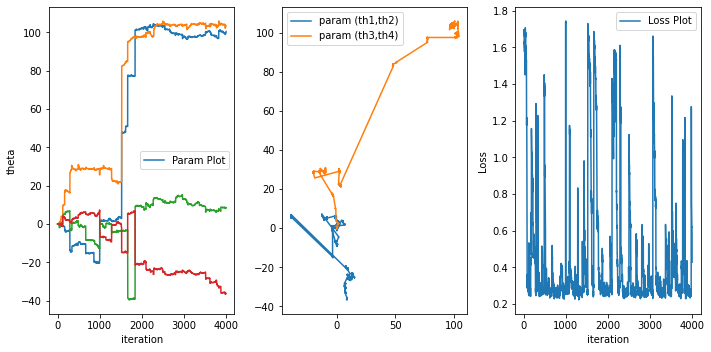

In [162]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
print('After 1000 iteration we have theta =',theta)
axes[0].plot(thdata)
axes[0].set_ylabel('theta')
axes[0].legend(['Param Plot'])
axes[0].set_xlabel('iteration')
axes[1].plot([item[2] for item in thdata],[item[3] for item in thdata],[item[0] for item in thdata],[item[1] for item in thdata])
axes[1].legend(['param (th1,th2)','param (th3,th4)'])

axes[2].plot(progress)
axes[2].legend(['Loss Plot'])
axes[2].set_ylabel('Loss')
axes[2].set_xlabel('iteration')
fig.tight_layout()

### c1=0.05(Medium movement) delta=0.3+ (Small fluctuation)

In [163]:
progress=[];
theta=[0,0,0,0];
thdata=[];

c1=0.05
delta=6
nshot=3000;
theta=np.array(theta)-SPSA(1,theta,c1,delta,nshot)
for ep in range(4000):
    delta=random.random()+0.3
    theta=theta-SPSA(1,theta,c1,delta,nshot)
    print(ep,"th iteration L=",lossCal2qubit(1,theta,nshot))
    progress.append(lossCal2qubit(1,theta,nshot))
    thdata.append(theta)

0 th iteration L= 1.6753333333333333
1 th iteration L= 1.6720000000000002
2 th iteration L= 1.6400000000000001
3 th iteration L= 1.654
4 th iteration L= 1.6313333333333333
5 th iteration L= 1.65
6 th iteration L= 1.62
7 th iteration L= 1.6006666666666667
8 th iteration L= 1.5859999999999999
9 th iteration L= 1.6126666666666667
10 th iteration L= 1.6133333333333333
11 th iteration L= 1.532
12 th iteration L= 1.588
13 th iteration L= 1.53
14 th iteration L= 1.4853333333333334
15 th iteration L= 1.4713333333333334
16 th iteration L= 1.462
17 th iteration L= 1.4493333333333334
18 th iteration L= 1.384
19 th iteration L= 1.3786666666666667
20 th iteration L= 1.4133333333333333
21 th iteration L= 1.3593333333333333
22 th iteration L= 1.3206666666666667
23 th iteration L= 1.3166666666666667
24 th iteration L= 1.2253333333333334
25 th iteration L= 1.2333333333333334
26 th iteration L= 1.21
27 th iteration L= 1.176
28 th iteration L= 1.0793333333333333
29 th iteration L= 1.0646666666666667
30 t

239 th iteration L= 0.266
240 th iteration L= 0.2726666666666666
241 th iteration L= 0.2793333333333333
242 th iteration L= 0.252
243 th iteration L= 0.2446666666666667
244 th iteration L= 0.2773333333333333
245 th iteration L= 0.264
246 th iteration L= 0.2486666666666667
247 th iteration L= 0.2733333333333333
248 th iteration L= 0.2433333333333333
249 th iteration L= 0.2553333333333333
250 th iteration L= 0.2393333333333333
251 th iteration L= 0.254
252 th iteration L= 0.2453333333333333
253 th iteration L= 0.2706666666666667
254 th iteration L= 0.2526666666666667
255 th iteration L= 0.2546666666666667
256 th iteration L= 0.2513333333333333
257 th iteration L= 0.2346666666666667
258 th iteration L= 0.2526666666666667
259 th iteration L= 0.2593333333333333
260 th iteration L= 0.2553333333333333
261 th iteration L= 0.2626666666666667
262 th iteration L= 0.276
263 th iteration L= 0.2593333333333333
264 th iteration L= 0.248
265 th iteration L= 0.2526666666666667
266 th iteration L= 0.255

478 th iteration L= 0.2793333333333333
479 th iteration L= 0.272
480 th iteration L= 0.2453333333333333
481 th iteration L= 0.2486666666666667
482 th iteration L= 0.2633333333333333
483 th iteration L= 0.244
484 th iteration L= 0.25
485 th iteration L= 0.2453333333333333
486 th iteration L= 0.262
487 th iteration L= 0.2786666666666666
488 th iteration L= 0.2706666666666667
489 th iteration L= 0.2413333333333333
490 th iteration L= 0.25
491 th iteration L= 0.26
492 th iteration L= 0.25
493 th iteration L= 0.2613333333333333
494 th iteration L= 0.2386666666666667
495 th iteration L= 0.2813333333333333
496 th iteration L= 0.2533333333333333
497 th iteration L= 0.258
498 th iteration L= 0.2366666666666667
499 th iteration L= 0.2573333333333333
500 th iteration L= 0.2666666666666667
501 th iteration L= 0.2713333333333333
502 th iteration L= 0.26
503 th iteration L= 0.2733333333333333
504 th iteration L= 0.29333333333333333
505 th iteration L= 0.244
506 th iteration L= 0.2646666666666667
507

714 th iteration L= 0.2653333333333333
715 th iteration L= 0.276
716 th iteration L= 0.254
717 th iteration L= 0.264
718 th iteration L= 0.2753333333333333
719 th iteration L= 0.2493333333333333
720 th iteration L= 0.2666666666666667
721 th iteration L= 0.28600000000000003
722 th iteration L= 0.2686666666666667
723 th iteration L= 0.2646666666666667
724 th iteration L= 0.276
725 th iteration L= 0.2493333333333333
726 th iteration L= 0.26
727 th iteration L= 0.2733333333333333
728 th iteration L= 0.25
729 th iteration L= 0.2693333333333333
730 th iteration L= 0.2666666666666667
731 th iteration L= 0.26
732 th iteration L= 0.2626666666666667
733 th iteration L= 0.274
734 th iteration L= 0.2466666666666667
735 th iteration L= 0.2513333333333333
736 th iteration L= 0.21733333333333338
737 th iteration L= 0.2493333333333333
738 th iteration L= 0.262
739 th iteration L= 0.27
740 th iteration L= 0.2473333333333333
741 th iteration L= 0.25
742 th iteration L= 0.2446666666666667
743 th iteratio

954 th iteration L= 0.2506666666666667
955 th iteration L= 0.2613333333333333
956 th iteration L= 0.2613333333333333
957 th iteration L= 0.24
958 th iteration L= 0.2586666666666667
959 th iteration L= 0.2633333333333333
960 th iteration L= 0.2753333333333333
961 th iteration L= 0.2633333333333333
962 th iteration L= 0.2553333333333333
963 th iteration L= 0.2513333333333333
964 th iteration L= 0.2686666666666667
965 th iteration L= 0.2613333333333333
966 th iteration L= 0.2713333333333333
967 th iteration L= 0.2626666666666667
968 th iteration L= 0.2426666666666667
969 th iteration L= 0.2613333333333333
970 th iteration L= 0.2693333333333333
971 th iteration L= 0.2573333333333333
972 th iteration L= 0.2453333333333333
973 th iteration L= 0.2726666666666666
974 th iteration L= 0.256
975 th iteration L= 0.254
976 th iteration L= 0.256
977 th iteration L= 0.258
978 th iteration L= 0.2673333333333333
979 th iteration L= 0.242
980 th iteration L= 0.2713333333333333
981 th iteration L= 0.2506

1188 th iteration L= 0.2466666666666667
1189 th iteration L= 0.2633333333333333
1190 th iteration L= 0.2593333333333333
1191 th iteration L= 0.2593333333333333
1192 th iteration L= 0.2453333333333333
1193 th iteration L= 0.2586666666666667
1194 th iteration L= 0.2646666666666667
1195 th iteration L= 0.2566666666666667
1196 th iteration L= 0.268
1197 th iteration L= 0.268
1198 th iteration L= 0.242
1199 th iteration L= 0.252
1200 th iteration L= 0.2326666666666667
1201 th iteration L= 0.2706666666666667
1202 th iteration L= 0.2526666666666667
1203 th iteration L= 0.28733333333333333
1204 th iteration L= 0.2553333333333333
1205 th iteration L= 0.2553333333333333
1206 th iteration L= 0.2613333333333333
1207 th iteration L= 0.2713333333333333
1208 th iteration L= 0.258
1209 th iteration L= 0.2746666666666666
1210 th iteration L= 0.262
1211 th iteration L= 0.2553333333333333
1212 th iteration L= 0.26
1213 th iteration L= 0.262
1214 th iteration L= 0.276
1215 th iteration L= 0.26266666666666

1417 th iteration L= 0.2506666666666667
1418 th iteration L= 0.2633333333333333
1419 th iteration L= 0.252
1420 th iteration L= 0.2673333333333333
1421 th iteration L= 0.2793333333333333
1422 th iteration L= 0.29000000000000004
1423 th iteration L= 0.2693333333333333
1424 th iteration L= 0.2406666666666667
1425 th iteration L= 0.2613333333333333
1426 th iteration L= 0.274
1427 th iteration L= 0.2606666666666667
1428 th iteration L= 0.2726666666666666
1429 th iteration L= 0.26
1430 th iteration L= 0.2386666666666667
1431 th iteration L= 0.2666666666666667
1432 th iteration L= 0.266
1433 th iteration L= 0.246
1434 th iteration L= 0.264
1435 th iteration L= 0.2733333333333333
1436 th iteration L= 0.258
1437 th iteration L= 0.2826666666666666
1438 th iteration L= 0.2593333333333333
1439 th iteration L= 0.2753333333333333
1440 th iteration L= 0.2853333333333333
1441 th iteration L= 0.2506666666666667
1442 th iteration L= 0.2513333333333333
1443 th iteration L= 0.2493333333333333
1444 th ite

1642 th iteration L= 0.2673333333333333
1643 th iteration L= 0.2533333333333333
1644 th iteration L= 0.23533333333333328
1645 th iteration L= 0.2686666666666667
1646 th iteration L= 0.2826666666666666
1647 th iteration L= 0.2453333333333333
1648 th iteration L= 0.2546666666666667
1649 th iteration L= 0.236
1650 th iteration L= 0.274
1651 th iteration L= 0.2473333333333333
1652 th iteration L= 0.2746666666666666
1653 th iteration L= 0.2473333333333333
1654 th iteration L= 0.2566666666666667
1655 th iteration L= 0.2413333333333333
1656 th iteration L= 0.2553333333333333
1657 th iteration L= 0.2613333333333333
1658 th iteration L= 0.252
1659 th iteration L= 0.25
1660 th iteration L= 0.2626666666666667
1661 th iteration L= 0.2653333333333333
1662 th iteration L= 0.2606666666666667
1663 th iteration L= 0.2746666666666666
1664 th iteration L= 0.2573333333333333
1665 th iteration L= 0.246
1666 th iteration L= 0.2586666666666667
1667 th iteration L= 0.264
1668 th iteration L= 0.264666666666666

1870 th iteration L= 0.2633333333333333
1871 th iteration L= 0.256
1872 th iteration L= 0.2573333333333333
1873 th iteration L= 0.276
1874 th iteration L= 0.2626666666666667
1875 th iteration L= 0.248
1876 th iteration L= 0.258
1877 th iteration L= 0.2573333333333333
1878 th iteration L= 0.2593333333333333
1879 th iteration L= 0.2613333333333333
1880 th iteration L= 0.2613333333333333
1881 th iteration L= 0.2533333333333333
1882 th iteration L= 0.2586666666666667
1883 th iteration L= 0.2613333333333333
1884 th iteration L= 0.2406666666666667
1885 th iteration L= 0.2526666666666667
1886 th iteration L= 0.266
1887 th iteration L= 0.2626666666666667
1888 th iteration L= 0.2546666666666667
1889 th iteration L= 0.2553333333333333
1890 th iteration L= 0.2653333333333333
1891 th iteration L= 0.2526666666666667
1892 th iteration L= 0.2633333333333333
1893 th iteration L= 0.2626666666666667
1894 th iteration L= 0.28
1895 th iteration L= 0.258
1896 th iteration L= 0.2713333333333333
1897 th iter

2104 th iteration L= 0.2406666666666667
2105 th iteration L= 0.2726666666666666
2106 th iteration L= 0.2613333333333333
2107 th iteration L= 0.2453333333333333
2108 th iteration L= 0.2513333333333333
2109 th iteration L= 0.2673333333333333
2110 th iteration L= 0.2506666666666667
2111 th iteration L= 0.23399999999999999
2112 th iteration L= 0.2506666666666667
2113 th iteration L= 0.274
2114 th iteration L= 0.2413333333333333
2115 th iteration L= 0.2693333333333333
2116 th iteration L= 0.2766666666666666
2117 th iteration L= 0.2586666666666667
2118 th iteration L= 0.2686666666666667
2119 th iteration L= 0.2733333333333333
2120 th iteration L= 0.2673333333333333
2121 th iteration L= 0.274
2122 th iteration L= 0.2606666666666667
2123 th iteration L= 0.2666666666666667
2124 th iteration L= 0.27
2125 th iteration L= 0.2566666666666667
2126 th iteration L= 0.26
2127 th iteration L= 0.2406666666666667
2128 th iteration L= 0.2653333333333333
2129 th iteration L= 0.2633333333333333
2130 th itera

2335 th iteration L= 0.252
2336 th iteration L= 0.258
2337 th iteration L= 0.2666666666666667
2338 th iteration L= 0.23733333333333329
2339 th iteration L= 0.264
2340 th iteration L= 0.2606666666666667
2341 th iteration L= 0.2493333333333333
2342 th iteration L= 0.2646666666666667
2343 th iteration L= 0.2733333333333333
2344 th iteration L= 0.2393333333333333
2345 th iteration L= 0.2593333333333333
2346 th iteration L= 0.2673333333333333
2347 th iteration L= 0.27
2348 th iteration L= 0.2613333333333333
2349 th iteration L= 0.27
2350 th iteration L= 0.266
2351 th iteration L= 0.2326666666666667
2352 th iteration L= 0.252
2353 th iteration L= 0.2666666666666667
2354 th iteration L= 0.2553333333333333
2355 th iteration L= 0.2513333333333333
2356 th iteration L= 0.256
2357 th iteration L= 0.2473333333333333
2358 th iteration L= 0.2433333333333333
2359 th iteration L= 0.2526666666666667
2360 th iteration L= 0.23533333333333328
2361 th iteration L= 0.22999999999999998
2362 th iteration L= 0.

2561 th iteration L= 0.2626666666666667
2562 th iteration L= 0.2706666666666667
2563 th iteration L= 0.2626666666666667
2564 th iteration L= 0.2646666666666667
2565 th iteration L= 0.2306666666666667
2566 th iteration L= 0.2453333333333333
2567 th iteration L= 0.264
2568 th iteration L= 0.2726666666666666
2569 th iteration L= 0.2526666666666667
2570 th iteration L= 0.2653333333333333
2571 th iteration L= 0.29666666666666663
2572 th iteration L= 0.2753333333333333
2573 th iteration L= 0.2513333333333333
2574 th iteration L= 0.2773333333333333
2575 th iteration L= 0.22266666666666668
2576 th iteration L= 0.266
2577 th iteration L= 0.2613333333333333
2578 th iteration L= 0.2653333333333333
2579 th iteration L= 0.2533333333333333
2580 th iteration L= 0.2566666666666667
2581 th iteration L= 0.2526666666666667
2582 th iteration L= 0.2533333333333333
2583 th iteration L= 0.2506666666666667
2584 th iteration L= 0.2746666666666666
2585 th iteration L= 0.2513333333333333
2586 th iteration L= 0.2

2788 th iteration L= 0.2593333333333333
2789 th iteration L= 0.2486666666666667
2790 th iteration L= 0.2533333333333333
2791 th iteration L= 0.256
2792 th iteration L= 0.2513333333333333
2793 th iteration L= 0.262
2794 th iteration L= 0.24
2795 th iteration L= 0.2633333333333333
2796 th iteration L= 0.2473333333333333
2797 th iteration L= 0.272
2798 th iteration L= 0.2586666666666667
2799 th iteration L= 0.2546666666666667
2800 th iteration L= 0.2533333333333333
2801 th iteration L= 0.2533333333333333
2802 th iteration L= 0.2393333333333333
2803 th iteration L= 0.2486666666666667
2804 th iteration L= 0.2533333333333333
2805 th iteration L= 0.2746666666666666
2806 th iteration L= 0.2586666666666667
2807 th iteration L= 0.2633333333333333
2808 th iteration L= 0.2646666666666667
2809 th iteration L= 0.258
2810 th iteration L= 0.2626666666666667
2811 th iteration L= 0.276
2812 th iteration L= 0.2573333333333333
2813 th iteration L= 0.2593333333333333
2814 th iteration L= 0.2806666666666666

3016 th iteration L= 0.2506666666666667
3017 th iteration L= 0.254
3018 th iteration L= 0.27
3019 th iteration L= 0.242
3020 th iteration L= 0.2633333333333333
3021 th iteration L= 0.2766666666666666
3022 th iteration L= 0.2606666666666667
3023 th iteration L= 0.256
3024 th iteration L= 0.2513333333333333
3025 th iteration L= 0.2573333333333333
3026 th iteration L= 0.2513333333333333
3027 th iteration L= 0.2626666666666667
3028 th iteration L= 0.23533333333333328
3029 th iteration L= 0.266
3030 th iteration L= 0.2646666666666667
3031 th iteration L= 0.2746666666666666
3032 th iteration L= 0.29066666666666663
3033 th iteration L= 0.2533333333333333
3034 th iteration L= 0.2773333333333333
3035 th iteration L= 0.268
3036 th iteration L= 0.26
3037 th iteration L= 0.2673333333333333
3038 th iteration L= 0.248
3039 th iteration L= 0.2586666666666667
3040 th iteration L= 0.2506666666666667
3041 th iteration L= 0.2546666666666667
3042 th iteration L= 0.254
3043 th iteration L= 0.266
3044 th it

3246 th iteration L= 0.2626666666666667
3247 th iteration L= 0.26
3248 th iteration L= 0.2446666666666667
3249 th iteration L= 0.2433333333333333
3250 th iteration L= 0.2346666666666667
3251 th iteration L= 0.29066666666666663
3252 th iteration L= 0.2653333333333333
3253 th iteration L= 0.2573333333333333
3254 th iteration L= 0.2473333333333333
3255 th iteration L= 0.2546666666666667
3256 th iteration L= 0.2593333333333333
3257 th iteration L= 0.2506666666666667
3258 th iteration L= 0.2713333333333333
3259 th iteration L= 0.2573333333333333
3260 th iteration L= 0.2466666666666667
3261 th iteration L= 0.2713333333333333
3262 th iteration L= 0.244
3263 th iteration L= 0.2526666666666667
3264 th iteration L= 0.256
3265 th iteration L= 0.266
3266 th iteration L= 0.2506666666666667
3267 th iteration L= 0.274
3268 th iteration L= 0.2733333333333333
3269 th iteration L= 0.2466666666666667
3270 th iteration L= 0.258
3271 th iteration L= 0.2646666666666667
3272 th iteration L= 0.262
3273 th ite

3476 th iteration L= 0.2593333333333333
3477 th iteration L= 0.2466666666666667
3478 th iteration L= 0.2606666666666667
3479 th iteration L= 0.254
3480 th iteration L= 0.256
3481 th iteration L= 0.252
3482 th iteration L= 0.278
3483 th iteration L= 0.2813333333333333
3484 th iteration L= 0.2426666666666667
3485 th iteration L= 0.242
3486 th iteration L= 0.2686666666666667
3487 th iteration L= 0.22599999999999998
3488 th iteration L= 0.2546666666666667
3489 th iteration L= 0.2773333333333333
3490 th iteration L= 0.2466666666666667
3491 th iteration L= 0.2413333333333333
3492 th iteration L= 0.2653333333333333
3493 th iteration L= 0.2586666666666667
3494 th iteration L= 0.2793333333333333
3495 th iteration L= 0.248
3496 th iteration L= 0.2513333333333333
3497 th iteration L= 0.2533333333333333
3498 th iteration L= 0.2706666666666667
3499 th iteration L= 0.2606666666666667
3500 th iteration L= 0.2573333333333333
3501 th iteration L= 0.2753333333333333
3502 th iteration L= 0.25066666666666

3704 th iteration L= 0.266
3705 th iteration L= 0.2466666666666667
3706 th iteration L= 0.268
3707 th iteration L= 0.254
3708 th iteration L= 0.2673333333333333
3709 th iteration L= 0.2766666666666666
3710 th iteration L= 0.238
3711 th iteration L= 0.2553333333333333
3712 th iteration L= 0.256
3713 th iteration L= 0.2513333333333333
3714 th iteration L= 0.2726666666666666
3715 th iteration L= 0.248
3716 th iteration L= 0.2486666666666667
3717 th iteration L= 0.27
3718 th iteration L= 0.266
3719 th iteration L= 0.2506666666666667
3720 th iteration L= 0.2713333333333333
3721 th iteration L= 0.25
3722 th iteration L= 0.2553333333333333
3723 th iteration L= 0.2646666666666667
3724 th iteration L= 0.2526666666666667
3725 th iteration L= 0.246
3726 th iteration L= 0.2393333333333333
3727 th iteration L= 0.2586666666666667
3728 th iteration L= 0.2593333333333333
3729 th iteration L= 0.2566666666666667
3730 th iteration L= 0.2633333333333333
3731 th iteration L= 0.248
3732 th iteration L= 0.24

3936 th iteration L= 0.27
3937 th iteration L= 0.2773333333333333
3938 th iteration L= 0.2666666666666667
3939 th iteration L= 0.2666666666666667
3940 th iteration L= 0.264
3941 th iteration L= 0.2646666666666667
3942 th iteration L= 0.2553333333333333
3943 th iteration L= 0.2853333333333333
3944 th iteration L= 0.2733333333333333
3945 th iteration L= 0.242
3946 th iteration L= 0.238
3947 th iteration L= 0.26
3948 th iteration L= 0.21799999999999997
3949 th iteration L= 0.2493333333333333
3950 th iteration L= 0.2613333333333333
3951 th iteration L= 0.2513333333333333
3952 th iteration L= 0.266
3953 th iteration L= 0.23133333333333328
3954 th iteration L= 0.25
3955 th iteration L= 0.2646666666666667
3956 th iteration L= 0.25
3957 th iteration L= 0.238
3958 th iteration L= 0.2513333333333333
3959 th iteration L= 0.2393333333333333
3960 th iteration L= 0.262
3961 th iteration L= 0.2533333333333333
3962 th iteration L= 0.2566666666666667
3963 th iteration L= 0.2453333333333333
3964 th iter

After 1000 iteration we have theta = [ 0.63709584 -2.71611025  0.85931948  0.98989377]


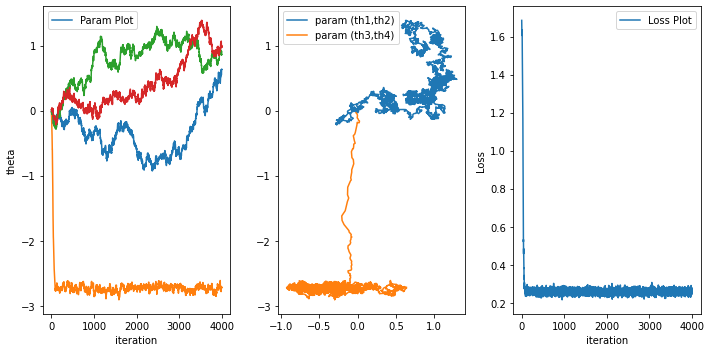

In [164]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
print('After 1000 iteration we have theta =',theta)
axes[0].plot(thdata)
axes[0].set_ylabel('theta')
axes[0].legend(['Param Plot'])
axes[0].set_xlabel('iteration')
axes[1].plot([item[2] for item in thdata],[item[3] for item in thdata],[item[0] for item in thdata],[item[1] for item in thdata])
axes[1].legend(['param (th1,th2)','param (th3,th4)'])

axes[2].plot(progress)
axes[2].legend(['Loss Plot'])
axes[2].set_ylabel('Loss')
axes[2].set_xlabel('iteration')
fig.tight_layout()

### c1=0.05(Medium movement) delta=0.1+ (Medium fluctuation)

In [165]:
progress=[];
theta=[0,0,0,0];
thdata=[];

c1=0.05
delta=6
nshot=3000;
theta=np.array(theta)-SPSA(1,theta,c1,delta,nshot)
for ep in range(4000):
    delta=random.random()+0.1
    theta=theta-SPSA(1,theta,c1,delta,nshot)
    print(ep,"th iteration L=",lossCal2qubit(1,theta,nshot))
    progress.append(lossCal2qubit(1,theta,nshot))
    thdata.append(theta)

0 th iteration L= 1.6586666666666665
1 th iteration L= 1.6646666666666667
2 th iteration L= 1.6
3 th iteration L= 1.56
4 th iteration L= 1.5153333333333334
5 th iteration L= 1.5353333333333334
6 th iteration L= 1.498
7 th iteration L= 1.488
8 th iteration L= 1.3566666666666667
9 th iteration L= 1.3266666666666667
10 th iteration L= 1.3086666666666666
11 th iteration L= 1.2806666666666666
12 th iteration L= 1.3053333333333335
13 th iteration L= 1.1313333333333333
14 th iteration L= 1.12
15 th iteration L= 1.028
16 th iteration L= 1.028
17 th iteration L= 0.862
18 th iteration L= 0.8013333333333333
19 th iteration L= 0.708
20 th iteration L= 0.6886666666666666
21 th iteration L= 0.5640000000000001
22 th iteration L= 0.51
23 th iteration L= 0.536
24 th iteration L= 0.508
25 th iteration L= 0.524
26 th iteration L= 0.5086666666666666
27 th iteration L= 0.4653333333333334
28 th iteration L= 0.44733333333333336
29 th iteration L= 0.4093333333333333
30 th iteration L= 0.3966666666666666
31 th

238 th iteration L= 0.2513333333333333
239 th iteration L= 0.246
240 th iteration L= 0.2553333333333333
241 th iteration L= 0.2766666666666666
242 th iteration L= 0.264
243 th iteration L= 0.264
244 th iteration L= 0.2773333333333333
245 th iteration L= 0.2586666666666667
246 th iteration L= 0.2466666666666667
247 th iteration L= 0.28600000000000003
248 th iteration L= 0.2613333333333333
249 th iteration L= 0.2586666666666667
250 th iteration L= 0.2513333333333333
251 th iteration L= 0.2473333333333333
252 th iteration L= 0.23133333333333328
253 th iteration L= 0.2613333333333333
254 th iteration L= 0.2693333333333333
255 th iteration L= 0.252
256 th iteration L= 0.2573333333333333
257 th iteration L= 0.238
258 th iteration L= 0.2726666666666666
259 th iteration L= 0.264
260 th iteration L= 0.2546666666666667
261 th iteration L= 0.2746666666666666
262 th iteration L= 0.2693333333333333
263 th iteration L= 0.256
264 th iteration L= 0.256
265 th iteration L= 0.28400000000000003
266 th it

473 th iteration L= 0.2786666666666666
474 th iteration L= 0.2566666666666667
475 th iteration L= 0.2506666666666667
476 th iteration L= 0.23533333333333328
477 th iteration L= 0.2533333333333333
478 th iteration L= 0.2613333333333333
479 th iteration L= 0.2413333333333333
480 th iteration L= 0.28400000000000003
481 th iteration L= 0.2853333333333333
482 th iteration L= 0.2326666666666667
483 th iteration L= 0.2746666666666666
484 th iteration L= 0.2686666666666667
485 th iteration L= 0.2806666666666666
486 th iteration L= 0.2686666666666667
487 th iteration L= 0.2526666666666667
488 th iteration L= 0.2806666666666666
489 th iteration L= 0.2753333333333333
490 th iteration L= 0.2486666666666667
491 th iteration L= 0.256
492 th iteration L= 0.2593333333333333
493 th iteration L= 0.2846666666666666
494 th iteration L= 0.28
495 th iteration L= 0.2773333333333333
496 th iteration L= 0.28600000000000003
497 th iteration L= 0.2426666666666667
498 th iteration L= 0.262
499 th iteration L= 0.2

709 th iteration L= 0.2566666666666667
710 th iteration L= 0.2533333333333333
711 th iteration L= 0.2653333333333333
712 th iteration L= 0.2673333333333333
713 th iteration L= 0.22799999999999998
714 th iteration L= 0.274
715 th iteration L= 0.2586666666666667
716 th iteration L= 0.2566666666666667
717 th iteration L= 0.2506666666666667
718 th iteration L= 0.2626666666666667
719 th iteration L= 0.2466666666666667
720 th iteration L= 0.2433333333333333
721 th iteration L= 0.262
722 th iteration L= 0.2566666666666667
723 th iteration L= 0.264
724 th iteration L= 0.2513333333333333
725 th iteration L= 0.2733333333333333
726 th iteration L= 0.264
727 th iteration L= 0.264
728 th iteration L= 0.2546666666666667
729 th iteration L= 0.2666666666666667
730 th iteration L= 0.2506666666666667
731 th iteration L= 0.252
732 th iteration L= 0.2566666666666667
733 th iteration L= 0.26
734 th iteration L= 0.28800000000000003
735 th iteration L= 0.264
736 th iteration L= 0.266
737 th iteration L= 0.24

947 th iteration L= 0.2726666666666666
948 th iteration L= 0.2346666666666667
949 th iteration L= 0.244
950 th iteration L= 0.2586666666666667
951 th iteration L= 0.2593333333333333
952 th iteration L= 0.2786666666666666
953 th iteration L= 0.274
954 th iteration L= 0.2593333333333333
955 th iteration L= 0.2566666666666667
956 th iteration L= 0.2626666666666667
957 th iteration L= 0.2753333333333333
958 th iteration L= 0.2486666666666667
959 th iteration L= 0.2433333333333333
960 th iteration L= 0.2586666666666667
961 th iteration L= 0.29200000000000004
962 th iteration L= 0.2586666666666667
963 th iteration L= 0.254
964 th iteration L= 0.2586666666666667
965 th iteration L= 0.2726666666666666
966 th iteration L= 0.2546666666666667
967 th iteration L= 0.22266666666666668
968 th iteration L= 0.258
969 th iteration L= 0.2586666666666667
970 th iteration L= 0.2406666666666667
971 th iteration L= 0.2633333333333333
972 th iteration L= 0.2626666666666667
973 th iteration L= 0.266
974 th ite

1174 th iteration L= 0.2473333333333333
1175 th iteration L= 0.256
1176 th iteration L= 0.26
1177 th iteration L= 0.2566666666666667
1178 th iteration L= 0.2653333333333333
1179 th iteration L= 0.2573333333333333
1180 th iteration L= 0.2713333333333333
1181 th iteration L= 0.2426666666666667
1182 th iteration L= 0.242
1183 th iteration L= 0.2593333333333333
1184 th iteration L= 0.2753333333333333
1185 th iteration L= 0.2666666666666667
1186 th iteration L= 0.252
1187 th iteration L= 0.2593333333333333
1188 th iteration L= 0.266
1189 th iteration L= 0.262
1190 th iteration L= 0.2386666666666667
1191 th iteration L= 0.254
1192 th iteration L= 0.2493333333333333
1193 th iteration L= 0.264
1194 th iteration L= 0.21599999999999997
1195 th iteration L= 0.2586666666666667
1196 th iteration L= 0.244
1197 th iteration L= 0.2553333333333333
1198 th iteration L= 0.2653333333333333
1199 th iteration L= 0.246
1200 th iteration L= 0.2773333333333333
1201 th iteration L= 0.2466666666666667
1202 th it

1401 th iteration L= 0.2573333333333333
1402 th iteration L= 0.276
1403 th iteration L= 0.2613333333333333
1404 th iteration L= 0.2546666666666667
1405 th iteration L= 0.2433333333333333
1406 th iteration L= 0.2653333333333333
1407 th iteration L= 0.248
1408 th iteration L= 0.2673333333333333
1409 th iteration L= 0.2586666666666667
1410 th iteration L= 0.254
1411 th iteration L= 0.266
1412 th iteration L= 0.2566666666666667
1413 th iteration L= 0.2806666666666666
1414 th iteration L= 0.2686666666666667
1415 th iteration L= 0.2726666666666666
1416 th iteration L= 0.2446666666666667
1417 th iteration L= 0.2846666666666666
1418 th iteration L= 0.2466666666666667
1419 th iteration L= 0.2486666666666667
1420 th iteration L= 0.2473333333333333
1421 th iteration L= 0.264
1422 th iteration L= 0.2573333333333333
1423 th iteration L= 0.2566666666666667
1424 th iteration L= 0.2653333333333333
1425 th iteration L= 0.258
1426 th iteration L= 0.2766666666666666
1427 th iteration L= 0.241333333333333

1630 th iteration L= 0.2586666666666667
1631 th iteration L= 0.2466666666666667
1632 th iteration L= 0.2366666666666667
1633 th iteration L= 0.22266666666666668
1634 th iteration L= 0.254
1635 th iteration L= 0.2646666666666667
1636 th iteration L= 0.2613333333333333
1637 th iteration L= 0.2453333333333333
1638 th iteration L= 0.28200000000000003
1639 th iteration L= 0.2526666666666667
1640 th iteration L= 0.2426666666666667
1641 th iteration L= 0.2573333333333333
1642 th iteration L= 0.2406666666666667
1643 th iteration L= 0.2586666666666667
1644 th iteration L= 0.2653333333333333
1645 th iteration L= 0.2753333333333333
1646 th iteration L= 0.2453333333333333
1647 th iteration L= 0.2573333333333333
1648 th iteration L= 0.2413333333333333
1649 th iteration L= 0.2673333333333333
1650 th iteration L= 0.26
1651 th iteration L= 0.2553333333333333
1652 th iteration L= 0.274
1653 th iteration L= 0.2673333333333333
1654 th iteration L= 0.2673333333333333
1655 th iteration L= 0.244
1656 th ite

1857 th iteration L= 0.258
1858 th iteration L= 0.2566666666666667
1859 th iteration L= 0.252
1860 th iteration L= 0.242
1861 th iteration L= 0.2546666666666667
1862 th iteration L= 0.2433333333333333
1863 th iteration L= 0.254
1864 th iteration L= 0.2566666666666667
1865 th iteration L= 0.276
1866 th iteration L= 0.28400000000000003
1867 th iteration L= 0.2426666666666667
1868 th iteration L= 0.2566666666666667
1869 th iteration L= 0.254
1870 th iteration L= 0.256
1871 th iteration L= 0.2573333333333333
1872 th iteration L= 0.2706666666666667
1873 th iteration L= 0.2593333333333333
1874 th iteration L= 0.2513333333333333
1875 th iteration L= 0.2733333333333333
1876 th iteration L= 0.2706666666666667
1877 th iteration L= 0.2606666666666667
1878 th iteration L= 0.28733333333333333
1879 th iteration L= 0.2526666666666667
1880 th iteration L= 0.2786666666666666
1881 th iteration L= 0.2406666666666667
1882 th iteration L= 0.2766666666666666
1883 th iteration L= 0.27
1884 th iteration L= 0.

2085 th iteration L= 0.248
2086 th iteration L= 0.23333333333333328
2087 th iteration L= 0.2346666666666667
2088 th iteration L= 0.258
2089 th iteration L= 0.2533333333333333
2090 th iteration L= 0.248
2091 th iteration L= 0.23333333333333328
2092 th iteration L= 0.2633333333333333
2093 th iteration L= 0.266
2094 th iteration L= 0.2366666666666667
2095 th iteration L= 0.2533333333333333
2096 th iteration L= 0.2506666666666667
2097 th iteration L= 0.238
2098 th iteration L= 0.2606666666666667
2099 th iteration L= 0.2546666666666667
2100 th iteration L= 0.252
2101 th iteration L= 0.27
2102 th iteration L= 0.2586666666666667
2103 th iteration L= 0.236
2104 th iteration L= 0.2826666666666666
2105 th iteration L= 0.2706666666666667
2106 th iteration L= 0.2686666666666667
2107 th iteration L= 0.2453333333333333
2108 th iteration L= 0.2466666666666667
2109 th iteration L= 0.2626666666666667
2110 th iteration L= 0.2566666666666667
2111 th iteration L= 0.2806666666666666
2112 th iteration L= 0.

2312 th iteration L= 0.266
2313 th iteration L= 0.2666666666666667
2314 th iteration L= 0.244
2315 th iteration L= 0.26
2316 th iteration L= 0.2473333333333333
2317 th iteration L= 0.2506666666666667
2318 th iteration L= 0.2586666666666667
2319 th iteration L= 0.2686666666666667
2320 th iteration L= 0.2826666666666666
2321 th iteration L= 0.258
2322 th iteration L= 0.2633333333333333
2323 th iteration L= 0.264
2324 th iteration L= 0.23333333333333328
2325 th iteration L= 0.2406666666666667
2326 th iteration L= 0.256
2327 th iteration L= 0.2586666666666667
2328 th iteration L= 0.2553333333333333
2329 th iteration L= 0.266
2330 th iteration L= 0.272
2331 th iteration L= 0.2466666666666667
2332 th iteration L= 0.246
2333 th iteration L= 0.2633333333333333
2334 th iteration L= 0.2713333333333333
2335 th iteration L= 0.2426666666666667
2336 th iteration L= 0.2633333333333333
2337 th iteration L= 0.2593333333333333
2338 th iteration L= 0.2573333333333333
2339 th iteration L= 0.26533333333333

2538 th iteration L= 0.264
2539 th iteration L= 0.2453333333333333
2540 th iteration L= 0.2786666666666666
2541 th iteration L= 0.2686666666666667
2542 th iteration L= 0.2846666666666666
2543 th iteration L= 0.2593333333333333
2544 th iteration L= 0.2706666666666667
2545 th iteration L= 0.2533333333333333
2546 th iteration L= 0.254
2547 th iteration L= 0.2666666666666667
2548 th iteration L= 0.2273333333333334
2549 th iteration L= 0.272
2550 th iteration L= 0.258
2551 th iteration L= 0.2426666666666667
2552 th iteration L= 0.2513333333333333
2553 th iteration L= 0.256
2554 th iteration L= 0.2586666666666667
2555 th iteration L= 0.2526666666666667
2556 th iteration L= 0.28600000000000003
2557 th iteration L= 0.258
2558 th iteration L= 0.276
2559 th iteration L= 0.25
2560 th iteration L= 0.23333333333333328
2561 th iteration L= 0.276
2562 th iteration L= 0.2513333333333333
2563 th iteration L= 0.2586666666666667
2564 th iteration L= 0.274
2565 th iteration L= 0.2486666666666667
2566 th i

2765 th iteration L= 0.272
2766 th iteration L= 0.2673333333333333
2767 th iteration L= 0.2406666666666667
2768 th iteration L= 0.2453333333333333
2769 th iteration L= 0.2673333333333333
2770 th iteration L= 0.2846666666666666
2771 th iteration L= 0.2473333333333333
2772 th iteration L= 0.256
2773 th iteration L= 0.2406666666666667
2774 th iteration L= 0.272
2775 th iteration L= 0.2733333333333333
2776 th iteration L= 0.2486666666666667
2777 th iteration L= 0.2493333333333333
2778 th iteration L= 0.2346666666666667
2779 th iteration L= 0.2653333333333333
2780 th iteration L= 0.2546666666666667
2781 th iteration L= 0.272
2782 th iteration L= 0.2646666666666667
2783 th iteration L= 0.2566666666666667
2784 th iteration L= 0.2546666666666667
2785 th iteration L= 0.2673333333333333
2786 th iteration L= 0.2786666666666666
2787 th iteration L= 0.2486666666666667
2788 th iteration L= 0.2633333333333333
2789 th iteration L= 0.2666666666666667
2790 th iteration L= 0.2646666666666667
2791 th iter

2992 th iteration L= 0.262
2993 th iteration L= 0.262
2994 th iteration L= 0.2526666666666667
2995 th iteration L= 0.242
2996 th iteration L= 0.2406666666666667
2997 th iteration L= 0.2673333333333333
2998 th iteration L= 0.2806666666666666
2999 th iteration L= 0.2673333333333333
3000 th iteration L= 0.2586666666666667
3001 th iteration L= 0.2693333333333333
3002 th iteration L= 0.2626666666666667
3003 th iteration L= 0.2633333333333333
3004 th iteration L= 0.2653333333333333
3005 th iteration L= 0.262
3006 th iteration L= 0.2646666666666667
3007 th iteration L= 0.2773333333333333
3008 th iteration L= 0.2533333333333333
3009 th iteration L= 0.2726666666666666
3010 th iteration L= 0.2466666666666667
3011 th iteration L= 0.262
3012 th iteration L= 0.2553333333333333
3013 th iteration L= 0.2673333333333333
3014 th iteration L= 0.264
3015 th iteration L= 0.262
3016 th iteration L= 0.2586666666666667
3017 th iteration L= 0.25
3018 th iteration L= 0.2473333333333333
3019 th iteration L= 0.25

3220 th iteration L= 0.2413333333333333
3221 th iteration L= 0.2693333333333333
3222 th iteration L= 0.256
3223 th iteration L= 0.266
3224 th iteration L= 0.252
3225 th iteration L= 0.256
3226 th iteration L= 0.2593333333333333
3227 th iteration L= 0.274
3228 th iteration L= 0.2693333333333333
3229 th iteration L= 0.25
3230 th iteration L= 0.2666666666666667
3231 th iteration L= 0.26
3232 th iteration L= 0.2566666666666667
3233 th iteration L= 0.256
3234 th iteration L= 0.2733333333333333
3235 th iteration L= 0.2606666666666667
3236 th iteration L= 0.28400000000000003
3237 th iteration L= 0.2526666666666667
3238 th iteration L= 0.2753333333333333
3239 th iteration L= 0.248
3240 th iteration L= 0.2653333333333333
3241 th iteration L= 0.2613333333333333
3242 th iteration L= 0.2706666666666667
3243 th iteration L= 0.266
3244 th iteration L= 0.2273333333333334
3245 th iteration L= 0.262
3246 th iteration L= 0.258
3247 th iteration L= 0.266
3248 th iteration L= 0.256
3249 th iteration L= 0.

3450 th iteration L= 0.2386666666666667
3451 th iteration L= 0.2713333333333333
3452 th iteration L= 0.2653333333333333
3453 th iteration L= 0.254
3454 th iteration L= 0.23533333333333328
3455 th iteration L= 0.2546666666666667
3456 th iteration L= 0.258
3457 th iteration L= 0.2433333333333333
3458 th iteration L= 0.2786666666666666
3459 th iteration L= 0.2666666666666667
3460 th iteration L= 0.2473333333333333
3461 th iteration L= 0.2693333333333333
3462 th iteration L= 0.22399999999999998
3463 th iteration L= 0.266
3464 th iteration L= 0.2453333333333333
3465 th iteration L= 0.2753333333333333
3466 th iteration L= 0.258
3467 th iteration L= 0.2606666666666667
3468 th iteration L= 0.2813333333333333
3469 th iteration L= 0.244
3470 th iteration L= 0.2753333333333333
3471 th iteration L= 0.248
3472 th iteration L= 0.2653333333333333
3473 th iteration L= 0.2473333333333333
3474 th iteration L= 0.2473333333333333
3475 th iteration L= 0.2593333333333333
3476 th iteration L= 0.2553333333333

3674 th iteration L= 0.2713333333333333
3675 th iteration L= 0.2593333333333333
3676 th iteration L= 0.252
3677 th iteration L= 0.2646666666666667
3678 th iteration L= 0.2813333333333333
3679 th iteration L= 0.2653333333333333
3680 th iteration L= 0.2626666666666667
3681 th iteration L= 0.2573333333333333
3682 th iteration L= 0.2493333333333333
3683 th iteration L= 0.2626666666666667
3684 th iteration L= 0.274
3685 th iteration L= 0.2626666666666667
3686 th iteration L= 0.2606666666666667
3687 th iteration L= 0.258
3688 th iteration L= 0.23399999999999999
3689 th iteration L= 0.266
3690 th iteration L= 0.2526666666666667
3691 th iteration L= 0.2666666666666667
3692 th iteration L= 0.23399999999999999
3693 th iteration L= 0.242
3694 th iteration L= 0.258
3695 th iteration L= 0.2513333333333333
3696 th iteration L= 0.26
3697 th iteration L= 0.2433333333333333
3698 th iteration L= 0.2473333333333333
3699 th iteration L= 0.26
3700 th iteration L= 0.252
3701 th iteration L= 0.27333333333333

3903 th iteration L= 0.27
3904 th iteration L= 0.2506666666666667
3905 th iteration L= 0.262
3906 th iteration L= 0.2553333333333333
3907 th iteration L= 0.2693333333333333
3908 th iteration L= 0.278
3909 th iteration L= 0.266
3910 th iteration L= 0.2653333333333333
3911 th iteration L= 0.264
3912 th iteration L= 0.2673333333333333
3913 th iteration L= 0.2633333333333333
3914 th iteration L= 0.274
3915 th iteration L= 0.254
3916 th iteration L= 0.2666666666666667
3917 th iteration L= 0.2486666666666667
3918 th iteration L= 0.2853333333333333
3919 th iteration L= 0.2586666666666667
3920 th iteration L= 0.252
3921 th iteration L= 0.2433333333333333
3922 th iteration L= 0.2606666666666667
3923 th iteration L= 0.258
3924 th iteration L= 0.2346666666666667
3925 th iteration L= 0.2613333333333333
3926 th iteration L= 0.2613333333333333
3927 th iteration L= 0.2573333333333333
3928 th iteration L= 0.27
3929 th iteration L= 0.2553333333333333
3930 th iteration L= 0.2553333333333333
3931 th iter

After 1000 iteration we have theta = [-1.59721634 -2.6808427   2.32849765  0.1924541 ]


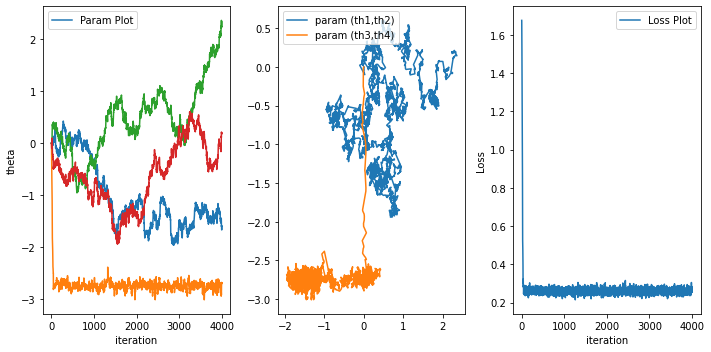

In [166]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
print('After 1000 iteration we have theta =',theta)
axes[0].plot(thdata)
axes[0].set_ylabel('theta')
axes[0].legend(['Param Plot'])
axes[0].set_xlabel('iteration')
axes[1].plot([item[2] for item in thdata],[item[3] for item in thdata],[item[0] for item in thdata],[item[1] for item in thdata])
axes[1].legend(['param (th1,th2)','param (th3,th4)'])

axes[2].plot(progress)
axes[2].legend(['Loss Plot'])
axes[2].set_ylabel('Loss')
axes[2].set_xlabel('iteration')
fig.tight_layout()

### c1=0.05(Medium movement) delta=0+ (Large fluctuation)

In [167]:
progress=[];
theta=[0,0,0,0];
thdata=[];

c1=0.05
delta=6
nshot=3000;
theta=np.array(theta)-SPSA(1,theta,c1,delta,nshot)
for ep in range(4000):
    delta=random.random()
    theta=theta-SPSA(1,theta,c1,delta,nshot)
    print(ep,"th iteration L=",lossCal2qubit(1,theta,nshot))
    progress.append(lossCal2qubit(1,theta,nshot))
    thdata.append(theta)

0 th iteration L= 1.6613333333333333
1 th iteration L= 1.712
2 th iteration L= 1.6873333333333334
3 th iteration L= 1.6853333333333333
4 th iteration L= 1.6393333333333333
5 th iteration L= 1.6400000000000001
6 th iteration L= 1.6386666666666667
7 th iteration L= 1.6346666666666667
8 th iteration L= 1.63
9 th iteration L= 1.6113333333333333
10 th iteration L= 1.5873333333333335
11 th iteration L= 1.5626666666666666
12 th iteration L= 1.488
13 th iteration L= 1.488
14 th iteration L= 1.3813333333333333
15 th iteration L= 1.278
16 th iteration L= 1.288
17 th iteration L= 1.158
18 th iteration L= 1.068
19 th iteration L= 1.0273333333333334
20 th iteration L= 0.946
21 th iteration L= 0.892
22 th iteration L= 0.7353333333333334
23 th iteration L= 0.7093333333333334
24 th iteration L= 0.6626666666666667
25 th iteration L= 0.5720000000000001
26 th iteration L= 0.5653333333333334
27 th iteration L= 0.3886666666666667
28 th iteration L= 0.33599999999999997
29 th iteration L= 0.33466666666666667

234 th iteration L= 0.2833333333333333
235 th iteration L= 0.2813333333333333
236 th iteration L= 0.2733333333333333
237 th iteration L= 0.2613333333333333
238 th iteration L= 0.268
239 th iteration L= 0.2693333333333333
240 th iteration L= 0.2673333333333333
241 th iteration L= 0.2786666666666666
242 th iteration L= 0.2686666666666667
243 th iteration L= 0.28933333333333333
244 th iteration L= 0.268
245 th iteration L= 0.2713333333333333
246 th iteration L= 0.2613333333333333
247 th iteration L= 0.2593333333333333
248 th iteration L= 0.2726666666666666
249 th iteration L= 0.2726666666666666
250 th iteration L= 0.2606666666666667
251 th iteration L= 0.2666666666666667
252 th iteration L= 0.2546666666666667
253 th iteration L= 0.2593333333333333
254 th iteration L= 0.2773333333333333
255 th iteration L= 0.26
256 th iteration L= 0.266
257 th iteration L= 0.2673333333333333
258 th iteration L= 0.2446666666666667
259 th iteration L= 0.266
260 th iteration L= 0.2506666666666667
261 th itera

467 th iteration L= 0.2733333333333333
468 th iteration L= 0.2533333333333333
469 th iteration L= 0.2693333333333333
470 th iteration L= 0.2506666666666667
471 th iteration L= 0.2613333333333333
472 th iteration L= 0.23133333333333328
473 th iteration L= 0.22399999999999998
474 th iteration L= 0.2526666666666667
475 th iteration L= 0.2753333333333333
476 th iteration L= 0.254
477 th iteration L= 0.2533333333333333
478 th iteration L= 0.2733333333333333
479 th iteration L= 0.258
480 th iteration L= 0.2366666666666667
481 th iteration L= 0.272
482 th iteration L= 0.2573333333333333
483 th iteration L= 0.26
484 th iteration L= 0.272
485 th iteration L= 0.5913333333333333
486 th iteration L= 0.5833333333333333
487 th iteration L= 0.44533333333333336
488 th iteration L= 0.45466666666666666
489 th iteration L= 0.3613333333333333
490 th iteration L= 0.3993333333333333
491 th iteration L= 0.3773333333333333
492 th iteration L= 0.3666666666666667
493 th iteration L= 0.3533333333333334
494 th it

696 th iteration L= 0.2606666666666667
697 th iteration L= 0.262
698 th iteration L= 0.28400000000000003
699 th iteration L= 0.2626666666666667
700 th iteration L= 0.2426666666666667
701 th iteration L= 0.2746666666666666
702 th iteration L= 0.2533333333333333
703 th iteration L= 0.2693333333333333
704 th iteration L= 0.2746666666666666
705 th iteration L= 0.2493333333333333
706 th iteration L= 0.256
707 th iteration L= 0.3446666666666667
708 th iteration L= 0.3486666666666667
709 th iteration L= 0.346
710 th iteration L= 0.4933333333333333
711 th iteration L= 0.4873333333333333
712 th iteration L= 0.4866666666666667
713 th iteration L= 0.4653333333333334
714 th iteration L= 1.6246666666666667
715 th iteration L= 1.4893333333333334
716 th iteration L= 1.436
717 th iteration L= 1.3066666666666666
718 th iteration L= 1.1493333333333333
719 th iteration L= 1.088
720 th iteration L= 0.97
721 th iteration L= 0.8933333333333333
722 th iteration L= 0.8433333333333333
723 th iteration L= 0.750

930 th iteration L= 0.28200000000000003
931 th iteration L= 0.29733333333333334
932 th iteration L= 0.2626666666666667
933 th iteration L= 0.27
934 th iteration L= 0.28400000000000003
935 th iteration L= 0.2546666666666667
936 th iteration L= 0.266
937 th iteration L= 0.2573333333333333
938 th iteration L= 0.23133333333333328
939 th iteration L= 0.2466666666666667
940 th iteration L= 0.266
941 th iteration L= 0.2646666666666667
942 th iteration L= 0.264
943 th iteration L= 0.2633333333333333
944 th iteration L= 0.2646666666666667
945 th iteration L= 0.922
946 th iteration L= 0.6233333333333333
947 th iteration L= 0.6226666666666667
948 th iteration L= 0.5640000000000001
949 th iteration L= 0.5133333333333333
950 th iteration L= 0.4733333333333334
951 th iteration L= 0.43266666666666664
952 th iteration L= 0.3773333333333333
953 th iteration L= 0.3746666666666667
954 th iteration L= 0.3473333333333334
955 th iteration L= 0.33999999999999997
956 th iteration L= 0.3446666666666667
957 th 

1157 th iteration L= 0.2673333333333333
1158 th iteration L= 0.264
1159 th iteration L= 0.2693333333333333
1160 th iteration L= 0.2846666666666666
1161 th iteration L= 0.2753333333333333
1162 th iteration L= 0.254
1163 th iteration L= 0.2633333333333333
1164 th iteration L= 0.262
1165 th iteration L= 0.2833333333333333
1166 th iteration L= 0.266
1167 th iteration L= 0.2586666666666667
1168 th iteration L= 0.256
1169 th iteration L= 0.2606666666666667
1170 th iteration L= 0.2586666666666667
1171 th iteration L= 0.2626666666666667
1172 th iteration L= 0.2326666666666667
1173 th iteration L= 0.2653333333333333
1174 th iteration L= 0.2713333333333333
1175 th iteration L= 0.406
1176 th iteration L= 0.41133333333333333
1177 th iteration L= 0.3626666666666667
1178 th iteration L= 0.356
1179 th iteration L= 0.3526666666666667
1180 th iteration L= 0.354
1181 th iteration L= 0.2833333333333333
1182 th iteration L= 0.29800000000000004
1183 th iteration L= 0.2866666666666666
1184 th iteration L= 0

1380 th iteration L= 0.2506666666666667
1381 th iteration L= 0.2653333333333333
1382 th iteration L= 0.254
1383 th iteration L= 0.278
1384 th iteration L= 0.278
1385 th iteration L= 0.2546666666666667
1386 th iteration L= 0.254
1387 th iteration L= 0.2626666666666667
1388 th iteration L= 0.2506666666666667
1389 th iteration L= 0.2526666666666667
1390 th iteration L= 0.264
1391 th iteration L= 0.238
1392 th iteration L= 0.266
1393 th iteration L= 0.258
1394 th iteration L= 0.2606666666666667
1395 th iteration L= 0.2453333333333333
1396 th iteration L= 0.26
1397 th iteration L= 0.28600000000000003
1398 th iteration L= 0.2513333333333333
1399 th iteration L= 0.254
1400 th iteration L= 0.2713333333333333
1401 th iteration L= 0.274
1402 th iteration L= 0.2786666666666666
1403 th iteration L= 0.2593333333333333
1404 th iteration L= 0.31000000000000005
1405 th iteration L= 0.29933333333333334
1406 th iteration L= 0.29000000000000004
1407 th iteration L= 0.33533333333333337
1408 th iteration L

1608 th iteration L= 0.27
1609 th iteration L= 0.2786666666666666
1610 th iteration L= 0.2386666666666667
1611 th iteration L= 0.29400000000000004
1612 th iteration L= 0.2426666666666667
1613 th iteration L= 0.2386666666666667
1614 th iteration L= 0.2526666666666667
1615 th iteration L= 0.256
1616 th iteration L= 0.2593333333333333
1617 th iteration L= 0.244
1618 th iteration L= 0.2633333333333333
1619 th iteration L= 0.258
1620 th iteration L= 0.252
1621 th iteration L= 0.2493333333333333
1622 th iteration L= 0.2346666666666667
1623 th iteration L= 0.256
1624 th iteration L= 0.258
1625 th iteration L= 0.2606666666666667
1626 th iteration L= 0.262
1627 th iteration L= 0.2393333333333333
1628 th iteration L= 0.2586666666666667
1629 th iteration L= 0.2746666666666666
1630 th iteration L= 0.28
1631 th iteration L= 0.2766666666666666
1632 th iteration L= 0.262
1633 th iteration L= 0.2486666666666667
1634 th iteration L= 0.2533333333333333
1635 th iteration L= 0.2713333333333333
1636 th ite

1834 th iteration L= 0.2553333333333333
1835 th iteration L= 0.2646666666666667
1836 th iteration L= 0.25
1837 th iteration L= 0.27
1838 th iteration L= 0.2573333333333333
1839 th iteration L= 0.25
1840 th iteration L= 0.2686666666666667
1841 th iteration L= 0.23399999999999999
1842 th iteration L= 0.2813333333333333
1843 th iteration L= 0.2653333333333333
1844 th iteration L= 0.2606666666666667
1845 th iteration L= 0.2573333333333333
1846 th iteration L= 0.266
1847 th iteration L= 0.274
1848 th iteration L= 0.2506666666666667
1849 th iteration L= 0.248
1850 th iteration L= 0.2466666666666667
1851 th iteration L= 0.28
1852 th iteration L= 0.2533333333333333
1853 th iteration L= 0.2766666666666666
1854 th iteration L= 0.2833333333333333
1855 th iteration L= 0.2693333333333333
1856 th iteration L= 0.25
1857 th iteration L= 0.2626666666666667
1858 th iteration L= 0.29133333333333333
1859 th iteration L= 0.2553333333333333
1860 th iteration L= 0.2666666666666667
1861 th iteration L= 0.2886

2058 th iteration L= 0.2506666666666667
2059 th iteration L= 0.2646666666666667
2060 th iteration L= 0.2653333333333333
2061 th iteration L= 0.272
2062 th iteration L= 0.2686666666666667
2063 th iteration L= 0.2486666666666667
2064 th iteration L= 0.2613333333333333
2065 th iteration L= 0.2566666666666667
2066 th iteration L= 0.256
2067 th iteration L= 0.2506666666666667
2068 th iteration L= 0.2813333333333333
2069 th iteration L= 0.2586666666666667
2070 th iteration L= 0.258
2071 th iteration L= 0.2493333333333333
2072 th iteration L= 0.2853333333333333
2073 th iteration L= 0.25
2074 th iteration L= 0.28400000000000003
2075 th iteration L= 0.2866666666666666
2076 th iteration L= 0.2686666666666667
2077 th iteration L= 0.2546666666666667
2078 th iteration L= 0.276
2079 th iteration L= 0.27
2080 th iteration L= 0.2513333333333333
2081 th iteration L= 0.2646666666666667
2082 th iteration L= 0.2693333333333333
2083 th iteration L= 0.2786666666666666
2084 th iteration L= 0.2586666666666667

2283 th iteration L= 0.29666666666666663
2284 th iteration L= 0.28200000000000003
2285 th iteration L= 0.2413333333333333
2286 th iteration L= 0.2473333333333333
2287 th iteration L= 0.2593333333333333
2288 th iteration L= 1.3639999999999999
2289 th iteration L= 1.3006666666666666
2290 th iteration L= 1.2646666666666666
2291 th iteration L= 1.2673333333333332
2292 th iteration L= 1.2233333333333334
2293 th iteration L= 1.1493333333333333
2294 th iteration L= 0.6986666666666667
2295 th iteration L= 0.71
2296 th iteration L= 0.6746666666666667
2297 th iteration L= 0.5640000000000001
2298 th iteration L= 0.5346666666666666
2299 th iteration L= 0.4873333333333333
2300 th iteration L= 0.46399999999999997
2301 th iteration L= 0.45133333333333336
2302 th iteration L= 0.42133333333333334
2303 th iteration L= 0.3806666666666667
2304 th iteration L= 0.3533333333333334
2305 th iteration L= 0.3526666666666667
2306 th iteration L= 0.30466666666666664
2307 th iteration L= 0.35
2308 th iteration L= 0

2505 th iteration L= 0.2706666666666667
2506 th iteration L= 0.2566666666666667
2507 th iteration L= 0.262
2508 th iteration L= 0.272
2509 th iteration L= 0.2606666666666667
2510 th iteration L= 0.2506666666666667
2511 th iteration L= 0.256
2512 th iteration L= 0.2753333333333333
2513 th iteration L= 0.266
2514 th iteration L= 0.258
2515 th iteration L= 0.2666666666666667
2516 th iteration L= 0.26
2517 th iteration L= 0.2573333333333333
2518 th iteration L= 0.2706666666666667
2519 th iteration L= 0.2573333333333333
2520 th iteration L= 0.252
2521 th iteration L= 0.2533333333333333
2522 th iteration L= 0.29733333333333334
2523 th iteration L= 0.30066666666666664
2524 th iteration L= 0.30466666666666664
2525 th iteration L= 0.2846666666666666
2526 th iteration L= 0.29866666666666664
2527 th iteration L= 0.2693333333333333
2528 th iteration L= 0.30066666666666664
2529 th iteration L= 0.28200000000000003
2530 th iteration L= 0.2726666666666666
2531 th iteration L= 0.2613333333333333
2532 t

2732 th iteration L= 0.2693333333333333
2733 th iteration L= 0.252
2734 th iteration L= 0.31399999999999995
2735 th iteration L= 0.2433333333333333
2736 th iteration L= 0.248
2737 th iteration L= 0.2793333333333333
2738 th iteration L= 0.2713333333333333
2739 th iteration L= 0.262
2740 th iteration L= 0.2566666666666667
2741 th iteration L= 0.2673333333333333
2742 th iteration L= 0.2446666666666667
2743 th iteration L= 0.274
2744 th iteration L= 0.258
2745 th iteration L= 0.2633333333333333
2746 th iteration L= 0.2613333333333333
2747 th iteration L= 0.2606666666666667
2748 th iteration L= 0.2486666666666667
2749 th iteration L= 0.2666666666666667
2750 th iteration L= 0.278
2751 th iteration L= 0.2433333333333333
2752 th iteration L= 0.2566666666666667
2753 th iteration L= 0.2486666666666667
2754 th iteration L= 0.29800000000000004
2755 th iteration L= 0.2493333333333333
2756 th iteration L= 0.2593333333333333
2757 th iteration L= 0.2526666666666667
2758 th iteration L= 0.2413333333333

2960 th iteration L= 0.9299999999999999
2961 th iteration L= 0.8
2962 th iteration L= 0.7893333333333333
2963 th iteration L= 0.7673333333333333
2964 th iteration L= 0.704
2965 th iteration L= 0.6593333333333333
2966 th iteration L= 0.61
2967 th iteration L= 0.3893333333333333
2968 th iteration L= 0.3746666666666667
2969 th iteration L= 0.3686666666666667
2970 th iteration L= 0.3613333333333333
2971 th iteration L= 0.3693333333333333
2972 th iteration L= 0.33466666666666667
2973 th iteration L= 0.32733333333333337
2974 th iteration L= 0.2786666666666666
2975 th iteration L= 0.252
2976 th iteration L= 0.29266666666666663
2977 th iteration L= 0.28
2978 th iteration L= 0.26
2979 th iteration L= 0.2566666666666667
2980 th iteration L= 0.2506666666666667
2981 th iteration L= 0.2586666666666667
2982 th iteration L= 0.2633333333333333
2983 th iteration L= 0.2846666666666666
2984 th iteration L= 0.2386666666666667
2985 th iteration L= 0.2826666666666666
2986 th iteration L= 0.2713333333333333


3185 th iteration L= 0.26
3186 th iteration L= 0.25
3187 th iteration L= 0.258
3188 th iteration L= 0.2713333333333333
3189 th iteration L= 0.2626666666666667
3190 th iteration L= 0.2453333333333333
3191 th iteration L= 0.2633333333333333
3192 th iteration L= 0.2686666666666667
3193 th iteration L= 0.27
3194 th iteration L= 0.2473333333333333
3195 th iteration L= 0.252
3196 th iteration L= 0.2413333333333333
3197 th iteration L= 0.246
3198 th iteration L= 0.2633333333333333
3199 th iteration L= 0.2653333333333333
3200 th iteration L= 0.2746666666666666
3201 th iteration L= 0.2786666666666666
3202 th iteration L= 0.276
3203 th iteration L= 0.2566666666666667
3204 th iteration L= 0.256
3205 th iteration L= 0.254
3206 th iteration L= 0.2706666666666667
3207 th iteration L= 0.2706666666666667
3208 th iteration L= 0.2653333333333333
3209 th iteration L= 0.2406666666666667
3210 th iteration L= 0.27
3211 th iteration L= 0.2573333333333333
3212 th iteration L= 0.2673333333333333
3213 th iterat

3411 th iteration L= 0.274
3412 th iteration L= 0.272
3413 th iteration L= 0.2826666666666666
3414 th iteration L= 0.2753333333333333
3415 th iteration L= 0.2633333333333333
3416 th iteration L= 0.262
3417 th iteration L= 0.268
3418 th iteration L= 0.2566666666666667
3419 th iteration L= 0.264
3420 th iteration L= 0.2733333333333333
3421 th iteration L= 0.254
3422 th iteration L= 0.2686666666666667
3423 th iteration L= 0.2586666666666667
3424 th iteration L= 0.256
3425 th iteration L= 0.2726666666666666
3426 th iteration L= 0.24
3427 th iteration L= 0.27
3428 th iteration L= 0.2493333333333333
3429 th iteration L= 0.2613333333333333
3430 th iteration L= 0.2713333333333333
3431 th iteration L= 0.264
3432 th iteration L= 0.22599999999999998
3433 th iteration L= 0.23399999999999999
3434 th iteration L= 0.2533333333333333
3435 th iteration L= 0.27
3436 th iteration L= 0.254
3437 th iteration L= 0.2426666666666667
3438 th iteration L= 0.2746666666666666
3439 th iteration L= 0.278
3440 th it

3638 th iteration L= 0.2706666666666667
3639 th iteration L= 0.2546666666666667
3640 th iteration L= 0.2626666666666667
3641 th iteration L= 0.254
3642 th iteration L= 0.2753333333333333
3643 th iteration L= 0.23533333333333328
3644 th iteration L= 0.2746666666666666
3645 th iteration L= 0.268
3646 th iteration L= 0.2566666666666667
3647 th iteration L= 0.2693333333333333
3648 th iteration L= 0.254
3649 th iteration L= 0.248
3650 th iteration L= 0.2526666666666667
3651 th iteration L= 0.2586666666666667
3652 th iteration L= 0.2806666666666666
3653 th iteration L= 0.2506666666666667
3654 th iteration L= 0.2586666666666667
3655 th iteration L= 0.2446666666666667
3656 th iteration L= 0.252
3657 th iteration L= 0.2766666666666666
3658 th iteration L= 0.2626666666666667
3659 th iteration L= 0.254
3660 th iteration L= 0.258
3661 th iteration L= 0.268
3662 th iteration L= 0.262
3663 th iteration L= 0.268
3664 th iteration L= 0.2653333333333333
3665 th iteration L= 0.2366666666666667
3666 th i

3863 th iteration L= 0.252
3864 th iteration L= 0.258
3865 th iteration L= 0.29066666666666663
3866 th iteration L= 0.2413333333333333
3867 th iteration L= 0.262
3868 th iteration L= 0.2626666666666667
3869 th iteration L= 0.29466666666666663
3870 th iteration L= 0.2506666666666667
3871 th iteration L= 0.2473333333333333
3872 th iteration L= 0.2886666666666666
3873 th iteration L= 0.2413333333333333
3874 th iteration L= 0.258
3875 th iteration L= 0.2633333333333333
3876 th iteration L= 0.26
3877 th iteration L= 0.2606666666666667
3878 th iteration L= 0.2693333333333333
3879 th iteration L= 0.2686666666666667
3880 th iteration L= 0.2633333333333333
3881 th iteration L= 0.2726666666666666
3882 th iteration L= 0.2746666666666666
3883 th iteration L= 0.2553333333333333
3884 th iteration L= 0.254
3885 th iteration L= 0.2693333333333333
3886 th iteration L= 0.256
3887 th iteration L= 0.2546666666666667
3888 th iteration L= 0.2306666666666667
3889 th iteration L= 0.2533333333333333
3890 th it

After 1000 iteration we have theta = [-21.75496883  -2.75522218 -13.25950019  -4.34197778]


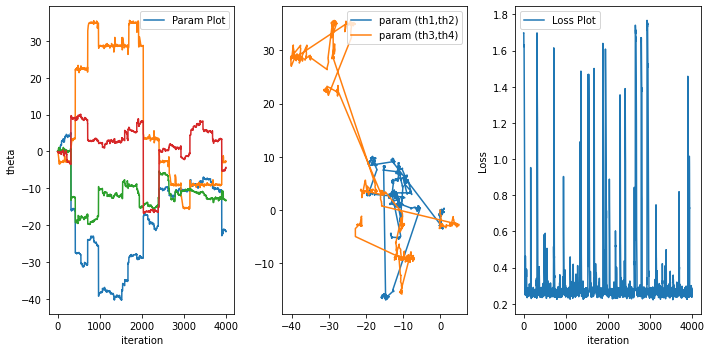

In [168]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
print('After 1000 iteration we have theta =',theta)
axes[0].plot(thdata)
axes[0].set_ylabel('theta')
axes[0].legend(['Param Plot'])
axes[0].set_xlabel('iteration')
axes[1].plot([item[2] for item in thdata],[item[3] for item in thdata],[item[0] for item in thdata],[item[1] for item in thdata])
axes[1].legend(['param (th1,th2)','param (th3,th4)'])

axes[2].plot(progress)
axes[2].legend(['Loss Plot'])
axes[2].set_ylabel('Loss')
axes[2].set_xlabel('iteration')
fig.tight_layout()

### c1=0.1(Large movement) delta=0.3+ (Small fluctuation)

In [169]:
progress=[];
theta=[0,0,0,0];
thdata=[];

c1=0.1   
delta=6
nshot=3000;
theta=np.array(theta)-SPSA(1,theta,c1,delta,nshot)
for ep in range(4000):
    delta=random.random()+0.3
    theta=theta-SPSA(1,theta,c1,delta,nshot)
    print(ep,"th iteration L=",lossCal2qubit(1,theta,nshot))
    progress.append(lossCal2qubit(1,theta,nshot))
    thdata.append(theta)

0 th iteration L= 1.6793333333333333
1 th iteration L= 1.6400000000000001
2 th iteration L= 1.6513333333333333
3 th iteration L= 1.6093333333333333
4 th iteration L= 1.5699999999999998
5 th iteration L= 1.5779999999999998
6 th iteration L= 1.5093333333333332
7 th iteration L= 1.4926666666666666
8 th iteration L= 1.414
9 th iteration L= 1.4046666666666667
10 th iteration L= 1.3166666666666667
11 th iteration L= 1.1993333333333334
12 th iteration L= 1.0693333333333332
13 th iteration L= 0.938
14 th iteration L= 0.74
15 th iteration L= 0.7053333333333334
16 th iteration L= 0.6586666666666667
17 th iteration L= 0.5946666666666667
18 th iteration L= 0.5433333333333333
19 th iteration L= 0.486
20 th iteration L= 0.45133333333333336
21 th iteration L= 0.41400000000000003
22 th iteration L= 0.3486666666666667
23 th iteration L= 0.362
24 th iteration L= 0.33333333333333337
25 th iteration L= 0.3446666666666667
26 th iteration L= 0.30800000000000005
27 th iteration L= 0.29666666666666663
28 th i

240 th iteration L= 0.258
241 th iteration L= 0.2453333333333333
242 th iteration L= 0.23133333333333328
243 th iteration L= 0.2593333333333333
244 th iteration L= 0.2713333333333333
245 th iteration L= 0.2526666666666667
246 th iteration L= 0.262
247 th iteration L= 0.2593333333333333
248 th iteration L= 0.2633333333333333
249 th iteration L= 0.27
250 th iteration L= 0.2413333333333333
251 th iteration L= 0.2726666666666666
252 th iteration L= 0.27
253 th iteration L= 0.248
254 th iteration L= 0.2733333333333333
255 th iteration L= 0.262
256 th iteration L= 0.2593333333333333
257 th iteration L= 0.2626666666666667
258 th iteration L= 0.2626666666666667
259 th iteration L= 0.268
260 th iteration L= 0.2506666666666667
261 th iteration L= 0.25
262 th iteration L= 0.2573333333333333
263 th iteration L= 0.2486666666666667
264 th iteration L= 0.2533333333333333
265 th iteration L= 0.2586666666666667
266 th iteration L= 0.2846666666666666
267 th iteration L= 0.2553333333333333
268 th iterati

471 th iteration L= 0.262
472 th iteration L= 0.2393333333333333
473 th iteration L= 0.25
474 th iteration L= 0.2453333333333333
475 th iteration L= 0.256
476 th iteration L= 0.2653333333333333
477 th iteration L= 0.2566666666666667
478 th iteration L= 0.2606666666666667
479 th iteration L= 0.2593333333333333
480 th iteration L= 0.2753333333333333
481 th iteration L= 0.2833333333333333
482 th iteration L= 0.2466666666666667
483 th iteration L= 0.2513333333333333
484 th iteration L= 0.242
485 th iteration L= 0.2526666666666667
486 th iteration L= 0.256
487 th iteration L= 0.2653333333333333
488 th iteration L= 0.268
489 th iteration L= 0.252
490 th iteration L= 0.274
491 th iteration L= 0.2586666666666667
492 th iteration L= 0.2846666666666666
493 th iteration L= 0.2586666666666667
494 th iteration L= 0.246
495 th iteration L= 0.2586666666666667
496 th iteration L= 0.274
497 th iteration L= 0.2746666666666666
498 th iteration L= 0.2426666666666667
499 th iteration L= 0.256
500 th iterat

711 th iteration L= 0.2533333333333333
712 th iteration L= 0.2666666666666667
713 th iteration L= 0.276
714 th iteration L= 0.258
715 th iteration L= 0.266
716 th iteration L= 0.2553333333333333
717 th iteration L= 0.2626666666666667
718 th iteration L= 0.256
719 th iteration L= 0.2486666666666667
720 th iteration L= 0.2273333333333334
721 th iteration L= 0.2466666666666667
722 th iteration L= 0.244
723 th iteration L= 0.2573333333333333
724 th iteration L= 0.2673333333333333
725 th iteration L= 0.2833333333333333
726 th iteration L= 0.2533333333333333
727 th iteration L= 0.2386666666666667
728 th iteration L= 0.29066666666666663
729 th iteration L= 0.2693333333333333
730 th iteration L= 0.2666666666666667
731 th iteration L= 0.2653333333333333
732 th iteration L= 0.2533333333333333
733 th iteration L= 0.2606666666666667
734 th iteration L= 0.2386666666666667
735 th iteration L= 0.2426666666666667
736 th iteration L= 0.2553333333333333
737 th iteration L= 0.2673333333333333
738 th iter

944 th iteration L= 0.2526666666666667
945 th iteration L= 0.236
946 th iteration L= 0.2433333333333333
947 th iteration L= 0.2693333333333333
948 th iteration L= 0.2513333333333333
949 th iteration L= 0.2573333333333333
950 th iteration L= 0.2513333333333333
951 th iteration L= 0.258
952 th iteration L= 0.262
953 th iteration L= 0.262
954 th iteration L= 0.27
955 th iteration L= 0.2586666666666667
956 th iteration L= 0.272
957 th iteration L= 0.262
958 th iteration L= 0.274
959 th iteration L= 0.2613333333333333
960 th iteration L= 0.2613333333333333
961 th iteration L= 0.25
962 th iteration L= 0.2766666666666666
963 th iteration L= 0.26
964 th iteration L= 0.2606666666666667
965 th iteration L= 0.2493333333333333
966 th iteration L= 0.2693333333333333
967 th iteration L= 0.26
968 th iteration L= 0.2546666666666667
969 th iteration L= 0.2526666666666667
970 th iteration L= 0.258
971 th iteration L= 0.2686666666666667
972 th iteration L= 0.2593333333333333
973 th iteration L= 0.25
974 

1178 th iteration L= 0.2706666666666667
1179 th iteration L= 0.268
1180 th iteration L= 0.264
1181 th iteration L= 0.2593333333333333
1182 th iteration L= 0.2586666666666667
1183 th iteration L= 0.22466666666666668
1184 th iteration L= 0.2533333333333333
1185 th iteration L= 0.246
1186 th iteration L= 0.272
1187 th iteration L= 0.2566666666666667
1188 th iteration L= 0.2573333333333333
1189 th iteration L= 0.256
1190 th iteration L= 0.2673333333333333
1191 th iteration L= 0.2613333333333333
1192 th iteration L= 0.2633333333333333
1193 th iteration L= 0.2613333333333333
1194 th iteration L= 0.272
1195 th iteration L= 0.2866666666666666
1196 th iteration L= 0.262
1197 th iteration L= 0.26
1198 th iteration L= 0.2733333333333333
1199 th iteration L= 0.254
1200 th iteration L= 0.254
1201 th iteration L= 0.272
1202 th iteration L= 0.2526666666666667
1203 th iteration L= 0.2533333333333333
1204 th iteration L= 0.24
1205 th iteration L= 0.264
1206 th iteration L= 0.2426666666666667
1207 th it

1410 th iteration L= 0.2586666666666667
1411 th iteration L= 0.268
1412 th iteration L= 0.2493333333333333
1413 th iteration L= 0.2693333333333333
1414 th iteration L= 0.262
1415 th iteration L= 0.262
1416 th iteration L= 0.2553333333333333
1417 th iteration L= 0.26
1418 th iteration L= 0.2446666666666667
1419 th iteration L= 0.2633333333333333
1420 th iteration L= 0.262
1421 th iteration L= 0.2426666666666667
1422 th iteration L= 0.256
1423 th iteration L= 0.2626666666666667
1424 th iteration L= 0.2626666666666667
1425 th iteration L= 0.2493333333333333
1426 th iteration L= 0.248
1427 th iteration L= 0.2586666666666667
1428 th iteration L= 0.262
1429 th iteration L= 0.256
1430 th iteration L= 0.2693333333333333
1431 th iteration L= 0.2806666666666666
1432 th iteration L= 0.2573333333333333
1433 th iteration L= 0.248
1434 th iteration L= 0.248
1435 th iteration L= 0.2573333333333333
1436 th iteration L= 0.2633333333333333
1437 th iteration L= 0.25
1438 th iteration L= 0.270666666666666

1637 th iteration L= 0.25
1638 th iteration L= 0.2713333333333333
1639 th iteration L= 0.27
1640 th iteration L= 0.2793333333333333
1641 th iteration L= 0.2646666666666667
1642 th iteration L= 0.2666666666666667
1643 th iteration L= 0.258
1644 th iteration L= 0.264
1645 th iteration L= 0.266
1646 th iteration L= 0.2513333333333333
1647 th iteration L= 0.2673333333333333
1648 th iteration L= 0.2533333333333333
1649 th iteration L= 0.2653333333333333
1650 th iteration L= 0.238
1651 th iteration L= 0.236
1652 th iteration L= 0.2806666666666666
1653 th iteration L= 0.2513333333333333
1654 th iteration L= 0.2753333333333333
1655 th iteration L= 0.2386666666666667
1656 th iteration L= 0.254
1657 th iteration L= 0.248
1658 th iteration L= 0.2513333333333333
1659 th iteration L= 0.2786666666666666
1660 th iteration L= 0.23533333333333328
1661 th iteration L= 0.246
1662 th iteration L= 0.2466666666666667
1663 th iteration L= 0.2673333333333333
1664 th iteration L= 0.2833333333333333
1665 th ite

1870 th iteration L= 0.2493333333333333
1871 th iteration L= 0.27
1872 th iteration L= 0.23133333333333328
1873 th iteration L= 0.26
1874 th iteration L= 0.278
1875 th iteration L= 0.252
1876 th iteration L= 0.2573333333333333
1877 th iteration L= 0.24
1878 th iteration L= 0.2606666666666667
1879 th iteration L= 0.2633333333333333
1880 th iteration L= 0.2513333333333333
1881 th iteration L= 0.2526666666666667
1882 th iteration L= 0.27
1883 th iteration L= 0.244
1884 th iteration L= 0.2673333333333333
1885 th iteration L= 0.2573333333333333
1886 th iteration L= 0.2673333333333333
1887 th iteration L= 0.252
1888 th iteration L= 0.2613333333333333
1889 th iteration L= 0.25
1890 th iteration L= 0.2606666666666667
1891 th iteration L= 0.2653333333333333
1892 th iteration L= 0.252
1893 th iteration L= 0.2653333333333333
1894 th iteration L= 0.2433333333333333
1895 th iteration L= 0.262
1896 th iteration L= 0.2546666666666667
1897 th iteration L= 0.2513333333333333
1898 th iteration L= 0.2586

2100 th iteration L= 0.2493333333333333
2101 th iteration L= 0.2606666666666667
2102 th iteration L= 0.246
2103 th iteration L= 0.272
2104 th iteration L= 0.2593333333333333
2105 th iteration L= 0.2793333333333333
2106 th iteration L= 0.246
2107 th iteration L= 0.23399999999999999
2108 th iteration L= 0.262
2109 th iteration L= 0.256
2110 th iteration L= 0.26
2111 th iteration L= 0.2486666666666667
2112 th iteration L= 0.2786666666666666
2113 th iteration L= 0.2646666666666667
2114 th iteration L= 0.2506666666666667
2115 th iteration L= 0.2806666666666666
2116 th iteration L= 0.2686666666666667
2117 th iteration L= 0.2693333333333333
2118 th iteration L= 0.26
2119 th iteration L= 0.2693333333333333
2120 th iteration L= 0.266
2121 th iteration L= 0.2513333333333333
2122 th iteration L= 0.2626666666666667
2123 th iteration L= 0.26
2124 th iteration L= 0.2713333333333333
2125 th iteration L= 0.2586666666666667
2126 th iteration L= 0.2526666666666667
2127 th iteration L= 0.2726666666666666

2334 th iteration L= 0.2746666666666666
2335 th iteration L= 0.256
2336 th iteration L= 0.2546666666666667
2337 th iteration L= 0.258
2338 th iteration L= 0.2606666666666667
2339 th iteration L= 0.262
2340 th iteration L= 0.2433333333333333
2341 th iteration L= 0.28
2342 th iteration L= 0.2653333333333333
2343 th iteration L= 0.25
2344 th iteration L= 0.2826666666666666
2345 th iteration L= 0.2493333333333333
2346 th iteration L= 0.2413333333333333
2347 th iteration L= 0.2626666666666667
2348 th iteration L= 0.2666666666666667
2349 th iteration L= 0.2433333333333333
2350 th iteration L= 0.2733333333333333
2351 th iteration L= 0.274
2352 th iteration L= 0.238
2353 th iteration L= 0.2613333333333333
2354 th iteration L= 0.2586666666666667
2355 th iteration L= 0.236
2356 th iteration L= 0.2513333333333333
2357 th iteration L= 0.2666666666666667
2358 th iteration L= 0.26
2359 th iteration L= 0.2493333333333333
2360 th iteration L= 0.2613333333333333
2361 th iteration L= 0.2546666666666667


2563 th iteration L= 0.248
2564 th iteration L= 0.276
2565 th iteration L= 0.2613333333333333
2566 th iteration L= 0.2613333333333333
2567 th iteration L= 0.2853333333333333
2568 th iteration L= 0.2566666666666667
2569 th iteration L= 0.258
2570 th iteration L= 0.252
2571 th iteration L= 0.2493333333333333
2572 th iteration L= 0.2473333333333333
2573 th iteration L= 0.26
2574 th iteration L= 0.23733333333333329
2575 th iteration L= 0.23199999999999998
2576 th iteration L= 0.2786666666666666
2577 th iteration L= 0.22333333333333338
2578 th iteration L= 0.26
2579 th iteration L= 0.248
2580 th iteration L= 0.2446666666666667
2581 th iteration L= 0.2653333333333333
2582 th iteration L= 0.2606666666666667
2583 th iteration L= 0.2766666666666666
2584 th iteration L= 0.262
2585 th iteration L= 0.278
2586 th iteration L= 0.2486666666666667
2587 th iteration L= 0.248
2588 th iteration L= 0.262
2589 th iteration L= 0.2693333333333333
2590 th iteration L= 0.2633333333333333
2591 th iteration L= 0

2790 th iteration L= 0.274
2791 th iteration L= 0.2553333333333333
2792 th iteration L= 0.272
2793 th iteration L= 0.2673333333333333
2794 th iteration L= 0.2773333333333333
2795 th iteration L= 0.2513333333333333
2796 th iteration L= 0.2546666666666667
2797 th iteration L= 0.2366666666666667
2798 th iteration L= 0.2686666666666667
2799 th iteration L= 0.238
2800 th iteration L= 0.2566666666666667
2801 th iteration L= 0.266
2802 th iteration L= 0.2633333333333333
2803 th iteration L= 0.262
2804 th iteration L= 0.2606666666666667
2805 th iteration L= 0.2506666666666667
2806 th iteration L= 0.26
2807 th iteration L= 0.2593333333333333
2808 th iteration L= 0.2826666666666666
2809 th iteration L= 0.23133333333333328
2810 th iteration L= 0.25
2811 th iteration L= 0.2733333333333333
2812 th iteration L= 0.25
2813 th iteration L= 0.28800000000000003
2814 th iteration L= 0.2733333333333333
2815 th iteration L= 0.272
2816 th iteration L= 0.2506666666666667
2817 th iteration L= 0.244666666666666

3020 th iteration L= 0.2593333333333333
3021 th iteration L= 0.2453333333333333
3022 th iteration L= 0.2473333333333333
3023 th iteration L= 0.2566666666666667
3024 th iteration L= 0.248
3025 th iteration L= 0.2686666666666667
3026 th iteration L= 0.252
3027 th iteration L= 0.2566666666666667
3028 th iteration L= 0.2553333333333333
3029 th iteration L= 0.2786666666666666
3030 th iteration L= 0.23333333333333328
3031 th iteration L= 0.2713333333333333
3032 th iteration L= 0.2673333333333333
3033 th iteration L= 0.28800000000000003
3034 th iteration L= 0.2573333333333333
3035 th iteration L= 0.2526666666666667
3036 th iteration L= 0.2526666666666667
3037 th iteration L= 0.2593333333333333
3038 th iteration L= 0.25
3039 th iteration L= 0.2606666666666667
3040 th iteration L= 0.2586666666666667
3041 th iteration L= 0.272
3042 th iteration L= 0.2806666666666666
3043 th iteration L= 0.2606666666666667
3044 th iteration L= 0.266
3045 th iteration L= 0.236
3046 th iteration L= 0.26733333333333

3250 th iteration L= 0.2713333333333333
3251 th iteration L= 0.2613333333333333
3252 th iteration L= 0.2606666666666667
3253 th iteration L= 0.23399999999999999
3254 th iteration L= 0.262
3255 th iteration L= 0.262
3256 th iteration L= 0.2446666666666667
3257 th iteration L= 0.2566666666666667
3258 th iteration L= 0.2553333333333333
3259 th iteration L= 0.2786666666666666
3260 th iteration L= 0.2733333333333333
3261 th iteration L= 0.2453333333333333
3262 th iteration L= 0.2453333333333333
3263 th iteration L= 0.2393333333333333
3264 th iteration L= 0.2586666666666667
3265 th iteration L= 0.23399999999999999
3266 th iteration L= 0.2793333333333333
3267 th iteration L= 0.2733333333333333
3268 th iteration L= 0.258
3269 th iteration L= 0.2673333333333333
3270 th iteration L= 0.2593333333333333
3271 th iteration L= 0.258
3272 th iteration L= 0.2653333333333333
3273 th iteration L= 0.26
3274 th iteration L= 0.254
3275 th iteration L= 0.2646666666666667
3276 th iteration L= 0.26333333333333

3481 th iteration L= 0.2666666666666667
3482 th iteration L= 0.2686666666666667
3483 th iteration L= 0.2626666666666667
3484 th iteration L= 0.2553333333333333
3485 th iteration L= 0.2493333333333333
3486 th iteration L= 0.2366666666666667
3487 th iteration L= 0.2473333333333333
3488 th iteration L= 0.2573333333333333
3489 th iteration L= 0.242
3490 th iteration L= 0.2646666666666667
3491 th iteration L= 0.28800000000000003
3492 th iteration L= 0.2513333333333333
3493 th iteration L= 0.26
3494 th iteration L= 0.276
3495 th iteration L= 0.2406666666666667
3496 th iteration L= 0.2773333333333333
3497 th iteration L= 0.2526666666666667
3498 th iteration L= 0.2386666666666667
3499 th iteration L= 0.266
3500 th iteration L= 0.264
3501 th iteration L= 0.2633333333333333
3502 th iteration L= 0.2606666666666667
3503 th iteration L= 0.2613333333333333
3504 th iteration L= 0.2713333333333333
3505 th iteration L= 0.2466666666666667
3506 th iteration L= 0.264
3507 th iteration L= 0.265333333333333

3714 th iteration L= 0.256
3715 th iteration L= 0.246
3716 th iteration L= 0.2413333333333333
3717 th iteration L= 0.2413333333333333
3718 th iteration L= 0.2446666666666667
3719 th iteration L= 0.2473333333333333
3720 th iteration L= 0.2726666666666666
3721 th iteration L= 0.2453333333333333
3722 th iteration L= 0.274
3723 th iteration L= 0.2466666666666667
3724 th iteration L= 0.2666666666666667
3725 th iteration L= 0.272
3726 th iteration L= 0.2566666666666667
3727 th iteration L= 0.256
3728 th iteration L= 0.272
3729 th iteration L= 0.22999999999999998
3730 th iteration L= 0.2673333333333333
3731 th iteration L= 0.28
3732 th iteration L= 0.2593333333333333
3733 th iteration L= 0.262
3734 th iteration L= 0.2453333333333333
3735 th iteration L= 0.26
3736 th iteration L= 0.2346666666666667
3737 th iteration L= 0.256
3738 th iteration L= 0.2606666666666667
3739 th iteration L= 0.2526666666666667
3740 th iteration L= 0.2553333333333333
3741 th iteration L= 0.2666666666666667
3742 th ite

3941 th iteration L= 0.2553333333333333
3942 th iteration L= 0.254
3943 th iteration L= 0.274
3944 th iteration L= 0.2673333333333333
3945 th iteration L= 0.26
3946 th iteration L= 0.2386666666666667
3947 th iteration L= 0.2613333333333333
3948 th iteration L= 0.2666666666666667
3949 th iteration L= 0.246
3950 th iteration L= 0.254
3951 th iteration L= 0.2566666666666667
3952 th iteration L= 0.2653333333333333
3953 th iteration L= 0.278
3954 th iteration L= 0.26
3955 th iteration L= 0.2546666666666667
3956 th iteration L= 0.28600000000000003
3957 th iteration L= 0.2553333333333333
3958 th iteration L= 0.2773333333333333
3959 th iteration L= 0.258
3960 th iteration L= 0.2626666666666667
3961 th iteration L= 0.252
3962 th iteration L= 0.2473333333333333
3963 th iteration L= 0.2633333333333333
3964 th iteration L= 0.2446666666666667
3965 th iteration L= 0.2713333333333333
3966 th iteration L= 0.2433333333333333
3967 th iteration L= 0.258
3968 th iteration L= 0.2546666666666667
3969 th ite

After 1000 iteration we have theta = [-0.59096371 -2.73316523 -0.01193892  0.51762063]


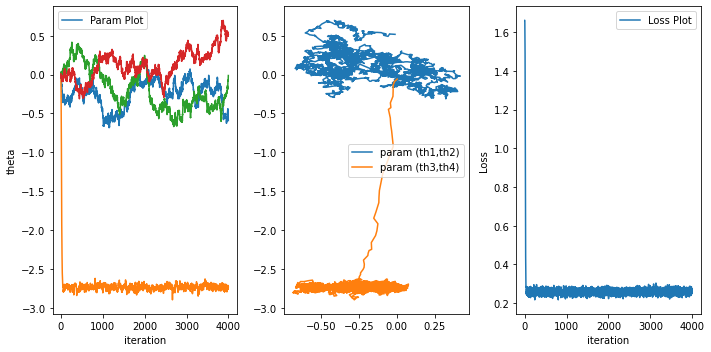

In [170]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
print('After 1000 iteration we have theta =',theta)
axes[0].plot(thdata)
axes[0].set_ylabel('theta')
axes[0].legend(['Param Plot'])
axes[0].set_xlabel('iteration')
axes[1].plot([item[2] for item in thdata],[item[3] for item in thdata],[item[0] for item in thdata],[item[1] for item in thdata])
axes[1].legend(['param (th1,th2)','param (th3,th4)'])

axes[2].plot(progress)
axes[2].legend(['Loss Plot'])
axes[2].set_ylabel('Loss')
axes[2].set_xlabel('iteration')
fig.tight_layout()

### c1=0.1(Large movement) delta=0.1+ (Medium fluctuation)

In [171]:
progress=[];
theta=[0,0,0,0];
thdata=[];

c1=0.1   
delta=6
nshot=3000;
theta=np.array(theta)-SPSA(1,theta,c1,delta,nshot)
for ep in range(4000):
    delta=random.random()+0.1
    theta=theta-SPSA(1,theta,c1,delta,nshot)
    print(ep,"th iteration L=",lossCal2qubit(1,theta,nshot))
    progress.append(lossCal2qubit(1,theta,nshot))
    thdata.append(theta)

0 th iteration L= 1.6906666666666665
1 th iteration L= 1.6386666666666667
2 th iteration L= 1.6266666666666667
3 th iteration L= 1.592
4 th iteration L= 1.5606666666666666
5 th iteration L= 1.5206666666666666
6 th iteration L= 1.4273333333333333
7 th iteration L= 1.4206666666666667
8 th iteration L= 1.162
9 th iteration L= 1.1153333333333333
10 th iteration L= 1.0813333333333333
11 th iteration L= 1.002
12 th iteration L= 0.8926666666666667
13 th iteration L= 0.6973333333333334
14 th iteration L= 0.6639999999999999
15 th iteration L= 0.4633333333333334
16 th iteration L= 0.43600000000000005
17 th iteration L= 0.406
18 th iteration L= 0.3906666666666667
19 th iteration L= 0.33533333333333337
20 th iteration L= 0.31200000000000006
21 th iteration L= 0.29533333333333334
22 th iteration L= 0.29133333333333333
23 th iteration L= 0.246
24 th iteration L= 0.2573333333333333
25 th iteration L= 0.25
26 th iteration L= 0.26
27 th iteration L= 0.2566666666666667
28 th iteration L= 0.2533333333333

237 th iteration L= 0.2606666666666667
238 th iteration L= 0.2693333333333333
239 th iteration L= 0.258
240 th iteration L= 0.254
241 th iteration L= 0.28733333333333333
242 th iteration L= 0.2553333333333333
243 th iteration L= 0.2506666666666667
244 th iteration L= 0.254
245 th iteration L= 0.254
246 th iteration L= 0.28200000000000003
247 th iteration L= 0.2646666666666667
248 th iteration L= 0.2473333333333333
249 th iteration L= 0.2653333333333333
250 th iteration L= 0.256
251 th iteration L= 0.268
252 th iteration L= 0.2533333333333333
253 th iteration L= 0.256
254 th iteration L= 0.2613333333333333
255 th iteration L= 0.30333333333333334
256 th iteration L= 0.248
257 th iteration L= 0.252
258 th iteration L= 0.258
259 th iteration L= 0.2673333333333333
260 th iteration L= 0.252
261 th iteration L= 0.2706666666666667
262 th iteration L= 0.252
263 th iteration L= 0.28733333333333333
264 th iteration L= 0.27
265 th iteration L= 0.2586666666666667
266 th iteration L= 0.26
267 th ite

476 th iteration L= 0.2526666666666667
477 th iteration L= 0.2613333333333333
478 th iteration L= 0.2653333333333333
479 th iteration L= 0.2466666666666667
480 th iteration L= 0.23733333333333329
481 th iteration L= 0.2613333333333333
482 th iteration L= 0.2646666666666667
483 th iteration L= 0.2566666666666667
484 th iteration L= 0.2533333333333333
485 th iteration L= 0.2546666666666667
486 th iteration L= 0.268
487 th iteration L= 0.2433333333333333
488 th iteration L= 0.2666666666666667
489 th iteration L= 0.2773333333333333
490 th iteration L= 0.248
491 th iteration L= 0.244
492 th iteration L= 0.2566666666666667
493 th iteration L= 0.2666666666666667
494 th iteration L= 0.2693333333333333
495 th iteration L= 0.2426666666666667
496 th iteration L= 0.2513333333333333
497 th iteration L= 0.2553333333333333
498 th iteration L= 0.242
499 th iteration L= 0.2546666666666667
500 th iteration L= 0.2626666666666667
501 th iteration L= 0.2726666666666666
502 th iteration L= 0.259333333333333

710 th iteration L= 0.252
711 th iteration L= 0.2553333333333333
712 th iteration L= 0.2473333333333333
713 th iteration L= 0.28200000000000003
714 th iteration L= 0.2393333333333333
715 th iteration L= 0.23733333333333329
716 th iteration L= 0.2486666666666667
717 th iteration L= 0.2646666666666667
718 th iteration L= 0.2553333333333333
719 th iteration L= 0.252
720 th iteration L= 0.2453333333333333
721 th iteration L= 0.2573333333333333
722 th iteration L= 0.2453333333333333
723 th iteration L= 0.266
724 th iteration L= 0.2606666666666667
725 th iteration L= 0.2506666666666667
726 th iteration L= 0.2606666666666667
727 th iteration L= 0.2653333333333333
728 th iteration L= 0.2606666666666667
729 th iteration L= 0.2693333333333333
730 th iteration L= 0.2673333333333333
731 th iteration L= 0.2546666666666667
732 th iteration L= 0.2626666666666667
733 th iteration L= 0.2726666666666666
734 th iteration L= 0.244
735 th iteration L= 0.2693333333333333
736 th iteration L= 0.27866666666666

947 th iteration L= 0.2573333333333333
948 th iteration L= 0.254
949 th iteration L= 0.258
950 th iteration L= 0.2513333333333333
951 th iteration L= 0.268
952 th iteration L= 0.2713333333333333
953 th iteration L= 0.276
954 th iteration L= 0.2733333333333333
955 th iteration L= 0.2593333333333333
956 th iteration L= 0.2486666666666667
957 th iteration L= 0.2666666666666667
958 th iteration L= 0.2526666666666667
959 th iteration L= 0.248
960 th iteration L= 0.2493333333333333
961 th iteration L= 0.2453333333333333
962 th iteration L= 0.268
963 th iteration L= 0.2573333333333333
964 th iteration L= 0.2466666666666667
965 th iteration L= 0.244
966 th iteration L= 0.268
967 th iteration L= 0.2526666666666667
968 th iteration L= 0.28733333333333333
969 th iteration L= 0.2613333333333333
970 th iteration L= 0.2473333333333333
971 th iteration L= 0.2686666666666667
972 th iteration L= 0.27
973 th iteration L= 0.262
974 th iteration L= 0.2586666666666667
975 th iteration L= 0.2806666666666666

1176 th iteration L= 0.2486666666666667
1177 th iteration L= 0.2566666666666667
1178 th iteration L= 0.242
1179 th iteration L= 0.23533333333333328
1180 th iteration L= 0.246
1181 th iteration L= 0.254
1182 th iteration L= 0.2346666666666667
1183 th iteration L= 0.2753333333333333
1184 th iteration L= 0.2513333333333333
1185 th iteration L= 0.2553333333333333
1186 th iteration L= 0.238
1187 th iteration L= 0.2733333333333333
1188 th iteration L= 0.256
1189 th iteration L= 0.242
1190 th iteration L= 0.2826666666666666
1191 th iteration L= 0.26
1192 th iteration L= 0.2613333333333333
1193 th iteration L= 0.266
1194 th iteration L= 0.2506666666666667
1195 th iteration L= 0.2493333333333333
1196 th iteration L= 0.248
1197 th iteration L= 0.2526666666666667
1198 th iteration L= 0.2606666666666667
1199 th iteration L= 0.2633333333333333
1200 th iteration L= 0.272
1201 th iteration L= 0.258
1202 th iteration L= 0.2446666666666667
1203 th iteration L= 0.27
1204 th iteration L= 0.24866666666666

1404 th iteration L= 0.26
1405 th iteration L= 0.2466666666666667
1406 th iteration L= 0.256
1407 th iteration L= 0.2493333333333333
1408 th iteration L= 0.2633333333333333
1409 th iteration L= 0.2593333333333333
1410 th iteration L= 0.2493333333333333
1411 th iteration L= 0.2566666666666667
1412 th iteration L= 0.2386666666666667
1413 th iteration L= 0.2606666666666667
1414 th iteration L= 0.2533333333333333
1415 th iteration L= 0.27
1416 th iteration L= 0.258
1417 th iteration L= 0.236
1418 th iteration L= 0.25
1419 th iteration L= 0.258
1420 th iteration L= 0.2446666666666667
1421 th iteration L= 0.2386666666666667
1422 th iteration L= 0.2693333333333333
1423 th iteration L= 0.2706666666666667
1424 th iteration L= 0.2433333333333333
1425 th iteration L= 0.2346666666666667
1426 th iteration L= 0.26
1427 th iteration L= 0.23533333333333328
1428 th iteration L= 0.258
1429 th iteration L= 0.2613333333333333
1430 th iteration L= 0.2593333333333333
1431 th iteration L= 0.2653333333333333


1628 th iteration L= 0.2513333333333333
1629 th iteration L= 0.2573333333333333
1630 th iteration L= 0.25
1631 th iteration L= 0.2746666666666666
1632 th iteration L= 0.29466666666666663
1633 th iteration L= 0.252
1634 th iteration L= 0.25
1635 th iteration L= 0.25
1636 th iteration L= 0.274
1637 th iteration L= 0.2653333333333333
1638 th iteration L= 0.2566666666666667
1639 th iteration L= 0.2733333333333333
1640 th iteration L= 0.2606666666666667
1641 th iteration L= 0.2553333333333333
1642 th iteration L= 0.276
1643 th iteration L= 0.2653333333333333
1644 th iteration L= 0.2846666666666666
1645 th iteration L= 0.25
1646 th iteration L= 0.2506666666666667
1647 th iteration L= 0.244
1648 th iteration L= 0.2586666666666667
1649 th iteration L= 0.2653333333333333
1650 th iteration L= 0.2653333333333333
1651 th iteration L= 0.2453333333333333
1652 th iteration L= 0.274
1653 th iteration L= 0.2526666666666667
1654 th iteration L= 0.2733333333333333
1655 th iteration L= 0.2526666666666667


1856 th iteration L= 0.272
1857 th iteration L= 0.256
1858 th iteration L= 0.2553333333333333
1859 th iteration L= 0.2666666666666667
1860 th iteration L= 0.278
1861 th iteration L= 0.2633333333333333
1862 th iteration L= 0.272
1863 th iteration L= 0.2666666666666667
1864 th iteration L= 0.268
1865 th iteration L= 0.2646666666666667
1866 th iteration L= 0.2746666666666666
1867 th iteration L= 0.2506666666666667
1868 th iteration L= 0.256
1869 th iteration L= 0.2673333333333333
1870 th iteration L= 0.2753333333333333
1871 th iteration L= 0.2606666666666667
1872 th iteration L= 0.252
1873 th iteration L= 0.2553333333333333
1874 th iteration L= 0.2666666666666667
1875 th iteration L= 0.2833333333333333
1876 th iteration L= 0.2726666666666666
1877 th iteration L= 0.2713333333333333
1878 th iteration L= 0.272
1879 th iteration L= 0.262
1880 th iteration L= 0.2526666666666667
1881 th iteration L= 0.2693333333333333
1882 th iteration L= 0.262
1883 th iteration L= 0.2786666666666666
1884 th it

2084 th iteration L= 0.2593333333333333
2085 th iteration L= 0.22666666666666668
2086 th iteration L= 0.2753333333333333
2087 th iteration L= 0.2653333333333333
2088 th iteration L= 0.262
2089 th iteration L= 0.2573333333333333
2090 th iteration L= 0.2626666666666667
2091 th iteration L= 0.254
2092 th iteration L= 0.252
2093 th iteration L= 0.2653333333333333
2094 th iteration L= 0.2346666666666667
2095 th iteration L= 0.2813333333333333
2096 th iteration L= 0.2453333333333333
2097 th iteration L= 0.254
2098 th iteration L= 0.2673333333333333
2099 th iteration L= 0.2546666666666667
2100 th iteration L= 0.2633333333333333
2101 th iteration L= 0.2586666666666667
2102 th iteration L= 0.2633333333333333
2103 th iteration L= 0.2546666666666667
2104 th iteration L= 0.2733333333333333
2105 th iteration L= 0.2813333333333333
2106 th iteration L= 0.2826666666666666
2107 th iteration L= 0.2693333333333333
2108 th iteration L= 0.264
2109 th iteration L= 0.2766666666666666
2110 th iteration L= 0.2

2313 th iteration L= 0.2726666666666666
2314 th iteration L= 0.262
2315 th iteration L= 0.2413333333333333
2316 th iteration L= 0.2746666666666666
2317 th iteration L= 0.242
2318 th iteration L= 0.262
2319 th iteration L= 0.2726666666666666
2320 th iteration L= 0.2773333333333333
2321 th iteration L= 0.27
2322 th iteration L= 0.2526666666666667
2323 th iteration L= 0.262
2324 th iteration L= 0.256
2325 th iteration L= 0.2746666666666666
2326 th iteration L= 0.2466666666666667
2327 th iteration L= 0.262
2328 th iteration L= 0.262
2329 th iteration L= 0.256
2330 th iteration L= 0.2593333333333333
2331 th iteration L= 0.252
2332 th iteration L= 0.22999999999999998
2333 th iteration L= 0.2586666666666667
2334 th iteration L= 0.2593333333333333
2335 th iteration L= 0.2633333333333333
2336 th iteration L= 0.2506666666666667
2337 th iteration L= 0.2586666666666667
2338 th iteration L= 0.2633333333333333
2339 th iteration L= 0.2573333333333333
2340 th iteration L= 0.2746666666666666
2341 th it

2541 th iteration L= 0.264
2542 th iteration L= 0.262
2543 th iteration L= 0.274
2544 th iteration L= 0.2686666666666667
2545 th iteration L= 0.2433333333333333
2546 th iteration L= 0.264
2547 th iteration L= 0.2593333333333333
2548 th iteration L= 0.254
2549 th iteration L= 0.2626666666666667
2550 th iteration L= 0.252
2551 th iteration L= 0.2746666666666666
2552 th iteration L= 0.2766666666666666
2553 th iteration L= 0.2486666666666667
2554 th iteration L= 0.2346666666666667
2555 th iteration L= 0.2433333333333333
2556 th iteration L= 0.2513333333333333
2557 th iteration L= 0.2786666666666666
2558 th iteration L= 0.2646666666666667
2559 th iteration L= 0.2626666666666667
2560 th iteration L= 0.2826666666666666
2561 th iteration L= 0.2566666666666667
2562 th iteration L= 0.28200000000000003
2563 th iteration L= 0.254
2564 th iteration L= 0.262
2565 th iteration L= 0.2733333333333333
2566 th iteration L= 0.28200000000000003
2567 th iteration L= 0.2726666666666666
2568 th iteration L= 0

2772 th iteration L= 0.27
2773 th iteration L= 0.2693333333333333
2774 th iteration L= 0.264
2775 th iteration L= 0.2626666666666667
2776 th iteration L= 0.254
2777 th iteration L= 0.2726666666666666
2778 th iteration L= 0.2726666666666666
2779 th iteration L= 0.254
2780 th iteration L= 0.2566666666666667
2781 th iteration L= 0.2593333333333333
2782 th iteration L= 0.2446666666666667
2783 th iteration L= 0.2673333333333333
2784 th iteration L= 0.23199999999999998
2785 th iteration L= 0.2386666666666667
2786 th iteration L= 0.28
2787 th iteration L= 0.2666666666666667
2788 th iteration L= 0.2546666666666667
2789 th iteration L= 0.256
2790 th iteration L= 0.2533333333333333
2791 th iteration L= 0.2613333333333333
2792 th iteration L= 0.262
2793 th iteration L= 0.2453333333333333
2794 th iteration L= 0.254
2795 th iteration L= 0.254
2796 th iteration L= 0.23333333333333328
2797 th iteration L= 0.248
2798 th iteration L= 0.2526666666666667
2799 th iteration L= 0.2453333333333333
2800 th it

3000 th iteration L= 0.2806666666666666
3001 th iteration L= 0.2726666666666666
3002 th iteration L= 0.2466666666666667
3003 th iteration L= 0.25
3004 th iteration L= 0.2486666666666667
3005 th iteration L= 0.2673333333333333
3006 th iteration L= 0.27
3007 th iteration L= 0.2413333333333333
3008 th iteration L= 0.2686666666666667
3009 th iteration L= 0.2606666666666667
3010 th iteration L= 0.2506666666666667
3011 th iteration L= 0.2593333333333333
3012 th iteration L= 0.2793333333333333
3013 th iteration L= 0.2533333333333333
3014 th iteration L= 0.2653333333333333
3015 th iteration L= 0.2886666666666666
3016 th iteration L= 0.23533333333333328
3017 th iteration L= 0.22533333333333339
3018 th iteration L= 0.2566666666666667
3019 th iteration L= 0.2573333333333333
3020 th iteration L= 0.262
3021 th iteration L= 0.268
3022 th iteration L= 0.264
3023 th iteration L= 0.2766666666666666
3024 th iteration L= 0.2506666666666667
3025 th iteration L= 0.2573333333333333
3026 th iteration L= 0.24

3227 th iteration L= 0.2473333333333333
3228 th iteration L= 0.28
3229 th iteration L= 0.2553333333333333
3230 th iteration L= 0.2406666666666667
3231 th iteration L= 0.2493333333333333
3232 th iteration L= 0.268
3233 th iteration L= 0.22533333333333339
3234 th iteration L= 0.2586666666666667
3235 th iteration L= 0.2653333333333333
3236 th iteration L= 0.29000000000000004
3237 th iteration L= 0.2653333333333333
3238 th iteration L= 0.248
3239 th iteration L= 0.272
3240 th iteration L= 0.26
3241 th iteration L= 0.2713333333333333
3242 th iteration L= 0.264
3243 th iteration L= 0.25
3244 th iteration L= 0.2433333333333333
3245 th iteration L= 0.2646666666666667
3246 th iteration L= 0.258
3247 th iteration L= 0.264
3248 th iteration L= 0.278
3249 th iteration L= 0.2453333333333333
3250 th iteration L= 0.2833333333333333
3251 th iteration L= 0.2633333333333333
3252 th iteration L= 0.2493333333333333
3253 th iteration L= 0.23333333333333328
3254 th iteration L= 0.2753333333333333
3255 th it

3463 th iteration L= 0.2506666666666667
3464 th iteration L= 0.2553333333333333
3465 th iteration L= 0.2806666666666666
3466 th iteration L= 0.2733333333333333
3467 th iteration L= 0.254
3468 th iteration L= 0.2726666666666666
3469 th iteration L= 0.2646666666666667
3470 th iteration L= 0.2393333333333333
3471 th iteration L= 0.2686666666666667
3472 th iteration L= 0.2513333333333333
3473 th iteration L= 0.2746666666666666
3474 th iteration L= 0.23133333333333328
3475 th iteration L= 0.2646666666666667
3476 th iteration L= 0.262
3477 th iteration L= 0.2693333333333333
3478 th iteration L= 0.256
3479 th iteration L= 0.2673333333333333
3480 th iteration L= 0.2693333333333333
3481 th iteration L= 0.2633333333333333
3482 th iteration L= 0.2466666666666667
3483 th iteration L= 0.2733333333333333
3484 th iteration L= 0.2566666666666667
3485 th iteration L= 0.238
3486 th iteration L= 0.2553333333333333
3487 th iteration L= 0.274
3488 th iteration L= 0.238
3489 th iteration L= 0.27
3490 th ite

3693 th iteration L= 0.2433333333333333
3694 th iteration L= 0.254
3695 th iteration L= 0.2666666666666667
3696 th iteration L= 0.266
3697 th iteration L= 0.2486666666666667
3698 th iteration L= 0.27
3699 th iteration L= 0.254
3700 th iteration L= 0.2613333333333333
3701 th iteration L= 0.276
3702 th iteration L= 0.2626666666666667
3703 th iteration L= 0.2426666666666667
3704 th iteration L= 0.2573333333333333
3705 th iteration L= 0.264
3706 th iteration L= 0.26
3707 th iteration L= 0.2693333333333333
3708 th iteration L= 0.264
3709 th iteration L= 0.2753333333333333
3710 th iteration L= 0.26
3711 th iteration L= 0.2866666666666666
3712 th iteration L= 0.272
3713 th iteration L= 0.2533333333333333
3714 th iteration L= 0.27
3715 th iteration L= 0.2693333333333333
3716 th iteration L= 0.2593333333333333
3717 th iteration L= 0.28733333333333333
3718 th iteration L= 0.2526666666666667
3719 th iteration L= 0.2766666666666666
3720 th iteration L= 0.2486666666666667
3721 th iteration L= 0.263

3927 th iteration L= 0.252
3928 th iteration L= 0.23399999999999999
3929 th iteration L= 0.262
3930 th iteration L= 0.2686666666666667
3931 th iteration L= 0.2513333333333333
3932 th iteration L= 0.254
3933 th iteration L= 0.2573333333333333
3934 th iteration L= 0.25
3935 th iteration L= 0.26
3936 th iteration L= 0.2433333333333333
3937 th iteration L= 0.2613333333333333
3938 th iteration L= 0.248
3939 th iteration L= 0.28800000000000003
3940 th iteration L= 0.26
3941 th iteration L= 0.2553333333333333
3942 th iteration L= 0.2686666666666667
3943 th iteration L= 0.24
3944 th iteration L= 0.2553333333333333
3945 th iteration L= 0.2773333333333333
3946 th iteration L= 0.264
3947 th iteration L= 0.2566666666666667
3948 th iteration L= 0.2646666666666667
3949 th iteration L= 0.2346666666666667
3950 th iteration L= 0.246
3951 th iteration L= 0.252
3952 th iteration L= 0.28
3953 th iteration L= 0.28
3954 th iteration L= 0.22933333333333328
3955 th iteration L= 0.272
3956 th iteration L= 0.24

After 1000 iteration we have theta = [ 3.61470417 -2.73610579 -2.04026212  0.99320514]


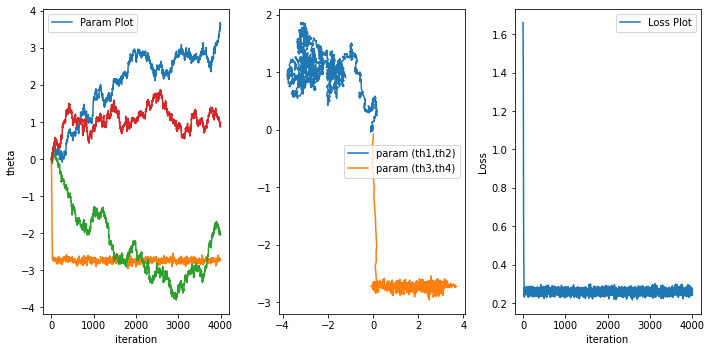

In [172]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
print('After 1000 iteration we have theta =',theta)
axes[0].plot(thdata)
axes[0].set_ylabel('theta')
axes[0].legend(['Param Plot'])
axes[0].set_xlabel('iteration')
axes[1].plot([item[2] for item in thdata],[item[3] for item in thdata],[item[0] for item in thdata],[item[1] for item in thdata])
axes[1].legend(['param (th1,th2)','param (th3,th4)'])

axes[2].plot(progress)
axes[2].legend(['Loss Plot'])
axes[2].set_ylabel('Loss')
axes[2].set_xlabel('iteration')
fig.tight_layout()

### c1=0.1(Large movement) delta=0+ (Large fluctuation)

In [173]:
progress=[];
theta=[0,0,0,0];
thdata=[];

c1=0.1   
delta=6
nshot=3000;
theta=np.array(theta)-SPSA(1,theta,c1,delta,nshot)
for ep in range(4000):
    delta=random.random()
    theta=theta-SPSA(1,theta,c1,delta,nshot)
    print(ep,"th iteration L=",lossCal2qubit(1,theta,nshot))
    progress.append(lossCal2qubit(1,theta,nshot))
    thdata.append(theta)

0 th iteration L= 1.662
1 th iteration L= 1.6406666666666667
2 th iteration L= 1.6046666666666667
3 th iteration L= 1.5473333333333334
4 th iteration L= 1.5653333333333332
5 th iteration L= 0.952
6 th iteration L= 0.83
7 th iteration L= 0.6866666666666666
8 th iteration L= 0.6133333333333333
9 th iteration L= 0.5246666666666666
10 th iteration L= 0.45466666666666666
11 th iteration L= 0.3666666666666667
12 th iteration L= 0.3453333333333334
13 th iteration L= 0.32733333333333337
14 th iteration L= 0.30133333333333334
15 th iteration L= 0.30266666666666664
16 th iteration L= 0.2766666666666666
17 th iteration L= 0.3466666666666667
18 th iteration L= 0.33599999999999997
19 th iteration L= 0.32599999999999996
20 th iteration L= 0.32933333333333337
21 th iteration L= 0.2693333333333333
22 th iteration L= 0.2633333333333333
23 th iteration L= 0.278
24 th iteration L= 0.2773333333333333
25 th iteration L= 0.2706666666666667
26 th iteration L= 0.2513333333333333
27 th iteration L= 0.246666666

240 th iteration L= 0.258
241 th iteration L= 0.2726666666666666
242 th iteration L= 0.258
243 th iteration L= 0.246
244 th iteration L= 0.2586666666666667
245 th iteration L= 0.2586666666666667
246 th iteration L= 0.2706666666666667
247 th iteration L= 0.248
248 th iteration L= 0.2753333333333333
249 th iteration L= 0.2606666666666667
250 th iteration L= 0.2546666666666667
251 th iteration L= 0.2733333333333333
252 th iteration L= 0.2406666666666667
253 th iteration L= 0.25
254 th iteration L= 0.252
255 th iteration L= 0.2646666666666667
256 th iteration L= 0.2426666666666667
257 th iteration L= 0.2526666666666667
258 th iteration L= 0.27
259 th iteration L= 0.2506666666666667
260 th iteration L= 0.274
261 th iteration L= 0.2686666666666667
262 th iteration L= 0.2713333333333333
263 th iteration L= 0.2506666666666667
264 th iteration L= 0.2666666666666667
265 th iteration L= 0.2606666666666667
266 th iteration L= 0.2506666666666667
267 th iteration L= 0.2546666666666667
268 th iterati

474 th iteration L= 0.2546666666666667
475 th iteration L= 0.2473333333333333
476 th iteration L= 0.2693333333333333
477 th iteration L= 0.272
478 th iteration L= 0.2586666666666667
479 th iteration L= 0.2453333333333333
480 th iteration L= 0.266
481 th iteration L= 0.2686666666666667
482 th iteration L= 0.2633333333333333
483 th iteration L= 0.28400000000000003
484 th iteration L= 0.258
485 th iteration L= 0.2566666666666667
486 th iteration L= 0.2566666666666667
487 th iteration L= 0.2633333333333333
488 th iteration L= 0.2586666666666667
489 th iteration L= 0.2766666666666666
490 th iteration L= 0.2746666666666666
491 th iteration L= 0.2646666666666667
492 th iteration L= 0.2553333333333333
493 th iteration L= 0.244
494 th iteration L= 0.2413333333333333
495 th iteration L= 0.2513333333333333
496 th iteration L= 0.27
497 th iteration L= 0.2426666666666667
498 th iteration L= 0.2746666666666666
499 th iteration L= 0.272
500 th iteration L= 0.242
501 th iteration L= 0.2433333333333333

707 th iteration L= 0.26
708 th iteration L= 0.27
709 th iteration L= 0.2706666666666667
710 th iteration L= 0.27
711 th iteration L= 0.258
712 th iteration L= 0.2806666666666666
713 th iteration L= 0.2726666666666666
714 th iteration L= 0.2626666666666667
715 th iteration L= 0.2666666666666667
716 th iteration L= 0.2473333333333333
717 th iteration L= 0.24
718 th iteration L= 0.2613333333333333
719 th iteration L= 0.2506666666666667
720 th iteration L= 0.2453333333333333
721 th iteration L= 0.2666666666666667
722 th iteration L= 0.2526666666666667
723 th iteration L= 0.28400000000000003
724 th iteration L= 0.2493333333333333
725 th iteration L= 0.2833333333333333
726 th iteration L= 0.2706666666666667
727 th iteration L= 0.2753333333333333
728 th iteration L= 0.274
729 th iteration L= 0.2673333333333333
730 th iteration L= 0.26
731 th iteration L= 0.23333333333333328
732 th iteration L= 0.266
733 th iteration L= 0.2573333333333333
734 th iteration L= 0.2833333333333333
735 th iteratio

938 th iteration L= 0.2773333333333333
939 th iteration L= 0.29333333333333333
940 th iteration L= 0.2686666666666667
941 th iteration L= 0.2793333333333333
942 th iteration L= 0.2433333333333333
943 th iteration L= 0.2673333333333333
944 th iteration L= 0.2666666666666667
945 th iteration L= 0.272
946 th iteration L= 0.278
947 th iteration L= 0.2666666666666667
948 th iteration L= 0.26
949 th iteration L= 0.2666666666666667
950 th iteration L= 0.266
951 th iteration L= 0.2666666666666667
952 th iteration L= 0.2693333333333333
953 th iteration L= 0.254
954 th iteration L= 0.2586666666666667
955 th iteration L= 0.2606666666666667
956 th iteration L= 0.2693333333333333
957 th iteration L= 0.238
958 th iteration L= 0.2646666666666667
959 th iteration L= 0.278
960 th iteration L= 0.2653333333333333
961 th iteration L= 0.278
962 th iteration L= 0.2466666666666667
963 th iteration L= 0.24
964 th iteration L= 0.244
965 th iteration L= 0.2453333333333333
966 th iteration L= 0.2646666666666667


1165 th iteration L= 0.2513333333333333
1166 th iteration L= 0.2513333333333333
1167 th iteration L= 0.2813333333333333
1168 th iteration L= 0.262
1169 th iteration L= 0.2706666666666667
1170 th iteration L= 0.27
1171 th iteration L= 0.2766666666666666
1172 th iteration L= 0.2666666666666667
1173 th iteration L= 0.276
1174 th iteration L= 0.2473333333333333
1175 th iteration L= 0.2706666666666667
1176 th iteration L= 0.2666666666666667
1177 th iteration L= 0.2673333333333333
1178 th iteration L= 0.262
1179 th iteration L= 0.2593333333333333
1180 th iteration L= 0.2573333333333333
1181 th iteration L= 0.2853333333333333
1182 th iteration L= 0.2506666666666667
1183 th iteration L= 0.256
1184 th iteration L= 0.2693333333333333
1185 th iteration L= 0.2673333333333333
1186 th iteration L= 0.2753333333333333
1187 th iteration L= 0.2706666666666667
1188 th iteration L= 0.236
1189 th iteration L= 0.262
1190 th iteration L= 0.2853333333333333
1191 th iteration L= 0.2773333333333333
1192 th iter

1393 th iteration L= 0.242
1394 th iteration L= 0.252
1395 th iteration L= 0.262
1396 th iteration L= 0.242
1397 th iteration L= 0.264
1398 th iteration L= 0.2546666666666667
1399 th iteration L= 0.2493333333333333
1400 th iteration L= 0.2606666666666667
1401 th iteration L= 0.2633333333333333
1402 th iteration L= 0.2446666666666667
1403 th iteration L= 0.246
1404 th iteration L= 0.2593333333333333
1405 th iteration L= 0.256
1406 th iteration L= 0.2613333333333333
1407 th iteration L= 0.25
1408 th iteration L= 0.242
1409 th iteration L= 0.2586666666666667
1410 th iteration L= 0.278
1411 th iteration L= 0.2726666666666666
1412 th iteration L= 0.2566666666666667
1413 th iteration L= 0.2613333333333333
1414 th iteration L= 0.29866666666666664
1415 th iteration L= 0.2746666666666666
1416 th iteration L= 0.2473333333333333
1417 th iteration L= 0.2573333333333333
1418 th iteration L= 0.2786666666666666
1419 th iteration L= 0.2426666666666667
1420 th iteration L= 0.25
1421 th iteration L= 0.2

1615 th iteration L= 0.2613333333333333
1616 th iteration L= 0.28733333333333333
1617 th iteration L= 0.254
1618 th iteration L= 0.2426666666666667
1619 th iteration L= 0.252
1620 th iteration L= 0.2566666666666667
1621 th iteration L= 0.274
1622 th iteration L= 0.252
1623 th iteration L= 0.2433333333333333
1624 th iteration L= 0.246
1625 th iteration L= 0.2613333333333333
1626 th iteration L= 0.2506666666666667
1627 th iteration L= 0.2486666666666667
1628 th iteration L= 0.244
1629 th iteration L= 0.254
1630 th iteration L= 0.2626666666666667
1631 th iteration L= 0.34199999999999997
1632 th iteration L= 0.29533333333333334
1633 th iteration L= 0.28600000000000003
1634 th iteration L= 0.26
1635 th iteration L= 0.2726666666666666
1636 th iteration L= 0.274
1637 th iteration L= 0.2666666666666667
1638 th iteration L= 0.2613333333333333
1639 th iteration L= 0.28
1640 th iteration L= 0.2666666666666667
1641 th iteration L= 0.268
1642 th iteration L= 0.2686666666666667
1643 th iteration L= 

1839 th iteration L= 0.2506666666666667
1840 th iteration L= 0.6819999999999999
1841 th iteration L= 0.638
1842 th iteration L= 0.394
1843 th iteration L= 0.3673333333333333
1844 th iteration L= 0.2833333333333333
1845 th iteration L= 0.2733333333333333
1846 th iteration L= 0.2686666666666667
1847 th iteration L= 0.29266666666666663
1848 th iteration L= 0.2393333333333333
1849 th iteration L= 0.2673333333333333
1850 th iteration L= 0.252
1851 th iteration L= 0.266
1852 th iteration L= 0.2653333333333333
1853 th iteration L= 0.2606666666666667
1854 th iteration L= 0.2586666666666667
1855 th iteration L= 0.2586666666666667
1856 th iteration L= 0.2726666666666666
1857 th iteration L= 0.26
1858 th iteration L= 0.262
1859 th iteration L= 0.2433333333333333
1860 th iteration L= 0.2626666666666667
1861 th iteration L= 0.2806666666666666
1862 th iteration L= 0.2613333333333333
1863 th iteration L= 0.246
1864 th iteration L= 0.27
1865 th iteration L= 0.2446666666666667
1866 th iteration L= 0.27

2066 th iteration L= 0.2746666666666666
2067 th iteration L= 0.2526666666666667
2068 th iteration L= 0.254
2069 th iteration L= 0.29666666666666663
2070 th iteration L= 0.2493333333333333
2071 th iteration L= 0.2686666666666667
2072 th iteration L= 0.258
2073 th iteration L= 0.2553333333333333
2074 th iteration L= 0.28600000000000003
2075 th iteration L= 0.2593333333333333
2076 th iteration L= 0.254
2077 th iteration L= 0.2646666666666667
2078 th iteration L= 0.2733333333333333
2079 th iteration L= 0.2506666666666667
2080 th iteration L= 0.2653333333333333
2081 th iteration L= 0.2626666666666667
2082 th iteration L= 0.2726666666666666
2083 th iteration L= 0.258
2084 th iteration L= 0.2686666666666667
2085 th iteration L= 0.2613333333333333
2086 th iteration L= 0.27
2087 th iteration L= 0.2813333333333333
2088 th iteration L= 0.2646666666666667
2089 th iteration L= 0.2526666666666667
2090 th iteration L= 0.2586666666666667
2091 th iteration L= 0.274
2092 th iteration L= 0.256
2093 th it

2292 th iteration L= 0.272
2293 th iteration L= 0.238
2294 th iteration L= 0.2713333333333333
2295 th iteration L= 0.25
2296 th iteration L= 0.246
2297 th iteration L= 0.25
2298 th iteration L= 0.268
2299 th iteration L= 0.2673333333333333
2300 th iteration L= 0.2533333333333333
2301 th iteration L= 0.2553333333333333
2302 th iteration L= 0.25
2303 th iteration L= 0.2746666666666666
2304 th iteration L= 0.276
2305 th iteration L= 0.2693333333333333
2306 th iteration L= 0.246
2307 th iteration L= 0.24
2308 th iteration L= 0.254
2309 th iteration L= 0.2586666666666667
2310 th iteration L= 0.2793333333333333
2311 th iteration L= 0.2826666666666666
2312 th iteration L= 0.2533333333333333
2313 th iteration L= 0.2653333333333333
2314 th iteration L= 0.2726666666666666
2315 th iteration L= 0.26
2316 th iteration L= 0.2606666666666667
2317 th iteration L= 0.2606666666666667
2318 th iteration L= 0.2526666666666667
2319 th iteration L= 0.246
2320 th iteration L= 0.252
2321 th iteration L= 0.266


2528 th iteration L= 0.2846666666666666
2529 th iteration L= 0.2633333333333333
2530 th iteration L= 0.2546666666666667
2531 th iteration L= 0.2693333333333333
2532 th iteration L= 0.394
2533 th iteration L= 0.28800000000000003
2534 th iteration L= 0.2853333333333333
2535 th iteration L= 0.2846666666666666
2536 th iteration L= 0.2613333333333333
2537 th iteration L= 0.2693333333333333
2538 th iteration L= 0.2506666666666667
2539 th iteration L= 0.26
2540 th iteration L= 0.252
2541 th iteration L= 0.242
2542 th iteration L= 0.2326666666666667
2543 th iteration L= 0.268
2544 th iteration L= 0.2713333333333333
2545 th iteration L= 0.2686666666666667
2546 th iteration L= 0.2746666666666666
2547 th iteration L= 0.254
2548 th iteration L= 0.29800000000000004
2549 th iteration L= 0.264
2550 th iteration L= 0.28
2551 th iteration L= 0.2773333333333333
2552 th iteration L= 0.266
2553 th iteration L= 0.2613333333333333
2554 th iteration L= 0.6073333333333333
2555 th iteration L= 0.49866666666666

2755 th iteration L= 0.278
2756 th iteration L= 0.29000000000000004
2757 th iteration L= 0.27
2758 th iteration L= 0.2453333333333333
2759 th iteration L= 0.2806666666666666
2760 th iteration L= 0.2606666666666667
2761 th iteration L= 0.2553333333333333
2762 th iteration L= 0.268
2763 th iteration L= 0.2493333333333333
2764 th iteration L= 0.236
2765 th iteration L= 0.2586666666666667
2766 th iteration L= 0.2633333333333333
2767 th iteration L= 0.2466666666666667
2768 th iteration L= 0.254
2769 th iteration L= 0.2746666666666666
2770 th iteration L= 0.23399999999999999
2771 th iteration L= 0.2593333333333333
2772 th iteration L= 0.2473333333333333
2773 th iteration L= 0.2586666666666667
2774 th iteration L= 0.30200000000000005
2775 th iteration L= 0.2726666666666666
2776 th iteration L= 0.28
2777 th iteration L= 0.2506666666666667
2778 th iteration L= 0.2566666666666667
2779 th iteration L= 0.2793333333333333
2780 th iteration L= 0.2706666666666667
2781 th iteration L= 0.27066666666666

2978 th iteration L= 0.3466666666666667
2979 th iteration L= 0.3413333333333334
2980 th iteration L= 0.33266666666666667
2981 th iteration L= 0.32799999999999996
2982 th iteration L= 0.32133333333333336
2983 th iteration L= 0.2806666666666666
2984 th iteration L= 0.264
2985 th iteration L= 0.246
2986 th iteration L= 0.2593333333333333
2987 th iteration L= 0.2493333333333333
2988 th iteration L= 0.2486666666666667
2989 th iteration L= 0.2686666666666667
2990 th iteration L= 0.2426666666666667
2991 th iteration L= 0.27
2992 th iteration L= 0.2673333333333333
2993 th iteration L= 0.2466666666666667
2994 th iteration L= 0.2553333333333333
2995 th iteration L= 0.2586666666666667
2996 th iteration L= 0.2693333333333333
2997 th iteration L= 0.2533333333333333
2998 th iteration L= 0.2346666666666667
2999 th iteration L= 0.2553333333333333
3000 th iteration L= 0.2566666666666667
3001 th iteration L= 0.2433333333333333
3002 th iteration L= 0.2753333333333333
3003 th iteration L= 0.252
3004 th it

3207 th iteration L= 0.262
3208 th iteration L= 0.2473333333333333
3209 th iteration L= 0.274
3210 th iteration L= 0.27
3211 th iteration L= 0.254
3212 th iteration L= 0.2446666666666667
3213 th iteration L= 0.2713333333333333
3214 th iteration L= 0.2533333333333333
3215 th iteration L= 0.2553333333333333
3216 th iteration L= 0.2586666666666667
3217 th iteration L= 0.2526666666666667
3218 th iteration L= 0.256
3219 th iteration L= 0.2706666666666667
3220 th iteration L= 0.2586666666666667
3221 th iteration L= 0.272
3222 th iteration L= 0.2693333333333333
3223 th iteration L= 0.274
3224 th iteration L= 0.2626666666666667
3225 th iteration L= 0.2446666666666667
3226 th iteration L= 0.2566666666666667
3227 th iteration L= 0.248
3228 th iteration L= 0.2426666666666667
3229 th iteration L= 0.246
3230 th iteration L= 0.2613333333333333
3231 th iteration L= 0.258
3232 th iteration L= 0.2453333333333333
3233 th iteration L= 0.2646666666666667
3234 th iteration L= 0.238
3235 th iteration L= 0.2

3431 th iteration L= 0.262
3432 th iteration L= 0.2466666666666667
3433 th iteration L= 0.2786666666666666
3434 th iteration L= 0.2686666666666667
3435 th iteration L= 0.2513333333333333
3436 th iteration L= 0.2553333333333333
3437 th iteration L= 0.244
3438 th iteration L= 0.262
3439 th iteration L= 0.2773333333333333
3440 th iteration L= 0.27
3441 th iteration L= 0.2593333333333333
3442 th iteration L= 0.2846666666666666
3443 th iteration L= 0.262
3444 th iteration L= 0.2493333333333333
3445 th iteration L= 0.26
3446 th iteration L= 0.2806666666666666
3447 th iteration L= 0.25
3448 th iteration L= 0.2786666666666666
3449 th iteration L= 0.2626666666666667
3450 th iteration L= 0.2633333333333333
3451 th iteration L= 0.2766666666666666
3452 th iteration L= 0.2813333333333333
3453 th iteration L= 0.252
3454 th iteration L= 0.2626666666666667
3455 th iteration L= 0.29733333333333334
3456 th iteration L= 0.2546666666666667
3457 th iteration L= 0.2846666666666666
3458 th iteration L= 0.267

3660 th iteration L= 0.2573333333333333
3661 th iteration L= 0.2626666666666667
3662 th iteration L= 0.2693333333333333
3663 th iteration L= 0.264
3664 th iteration L= 0.264
3665 th iteration L= 0.264
3666 th iteration L= 0.2586666666666667
3667 th iteration L= 0.2513333333333333
3668 th iteration L= 0.2466666666666667
3669 th iteration L= 0.2593333333333333
3670 th iteration L= 0.2533333333333333
3671 th iteration L= 0.2733333333333333
3672 th iteration L= 0.2526666666666667
3673 th iteration L= 0.2733333333333333
3674 th iteration L= 0.2646666666666667
3675 th iteration L= 0.2593333333333333
3676 th iteration L= 0.258
3677 th iteration L= 0.2653333333333333
3678 th iteration L= 0.2513333333333333
3679 th iteration L= 0.2593333333333333
3680 th iteration L= 0.24
3681 th iteration L= 0.2813333333333333
3682 th iteration L= 0.30666666666666664
3683 th iteration L= 0.28600000000000003
3684 th iteration L= 0.2766666666666666
3685 th iteration L= 0.2746666666666666
3686 th iteration L= 0.2

3889 th iteration L= 0.29866666666666664
3890 th iteration L= 0.2753333333333333
3891 th iteration L= 0.276
3892 th iteration L= 0.274
3893 th iteration L= 0.2573333333333333
3894 th iteration L= 0.254
3895 th iteration L= 0.2326666666666667
3896 th iteration L= 0.2566666666666667
3897 th iteration L= 0.26
3898 th iteration L= 0.2606666666666667
3899 th iteration L= 0.264
3900 th iteration L= 0.2866666666666666
3901 th iteration L= 0.2666666666666667
3902 th iteration L= 0.2446666666666667
3903 th iteration L= 0.246
3904 th iteration L= 0.2386666666666667
3905 th iteration L= 0.2506666666666667
3906 th iteration L= 0.2533333333333333
3907 th iteration L= 0.2706666666666667
3908 th iteration L= 0.252
3909 th iteration L= 0.2593333333333333
3910 th iteration L= 0.2593333333333333
3911 th iteration L= 0.2633333333333333
3912 th iteration L= 0.262
3913 th iteration L= 0.258
3914 th iteration L= 0.256
3915 th iteration L= 0.2526666666666667
3916 th iteration L= 0.272
3917 th iteration L= 0.

After 1000 iteration we have theta = [ 79.69179796 -40.44794104   6.42020734 -41.99669114]


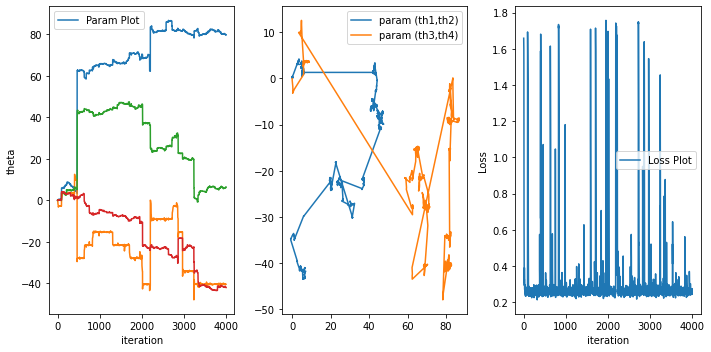

In [174]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
print('After 1000 iteration we have theta =',theta)
axes[0].plot(thdata)
axes[0].set_ylabel('theta')
axes[0].legend(['Param Plot'])
axes[0].set_xlabel('iteration')
axes[1].plot([item[2] for item in thdata],[item[3] for item in thdata],[item[0] for item in thdata],[item[1] for item in thdata])
axes[1].legend(['param (th1,th2)','param (th3,th4)'])

axes[2].plot(progress)
axes[2].legend(['Loss Plot'])
axes[2].set_ylabel('Loss')
axes[2].set_xlabel('iteration')
fig.tight_layout()

In [187]:
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator


backend = Aer.get_backend('qasm_simulator')
def lossCal2qubit(i,theta,nshot):    
    #i th data
    #parameter
    #return loss

    qr = QuantumRegister(2)
    cr = ClassicalRegister(2)
    qc = QuantumCircuit(qr,cr)

    qc.rx(a_shuffled[i][0],qr[0])
    qc.rx(a_shuffled[i][1],qr[1])
    
    qc.ry(pi/4,qr[:])
    qc.rz(pi/4,qr[:])
    
    qc.cz(qr[0],qr[1])
    qc.ry(pi/4,qr[:])
    qc.rz(pi/4,qr[:])
    
    count=0;
    for i in range(2):
        qc.rx(theta[count],qr[i])
        count=count+1
    for i in range(2):
        qc.rz(theta[count],qr[i])
        count=count+1   

    qc.measure(qr[:],cr[:])
    job = execute(qc, backend, shots=nshot)
    result = job.result()
    count =result.get_counts()
    lm=-1*(cN(count,'00')+cN(count,'01'))
    lp=1*(cN(count,'10')+cN(count,'11'))

    loss1=abs(
        (lm+lp)/nshot
        -2*(b_shuffled[i]-0.5)
    )
    loss2=((lm+lp)/nshot-2*(b_shuffled[i]-0.5))**2

    return loss1
lossCal2qubit(8,[1,1,1,1],10)

0.4

[0, 0, 0, 0]

In [58]:
#

theta=[0,0,0,0];
def SPSA(i,th,c1,delta,nshot):
    sp=[];
    c2=[[c1,0,0,0],[0,c1,0,0],[0,0,c1,0],[0,0,0,c1]]
    for x1 in range(4):
        sp.append((lossCal2qubit(i,th+np.array(c2[x1]),nshot)-lossCal2qubit(i,th-np.array(c2[x1]),nshot))/(2*delta))
    return sp

SPSA(1,theta,0.1,5,10000)

[0.006666666666666664,
 0.001666666666666668,
 0.006666666666666672,
 0.008333333333333331]

## Two Qubit iteration with 100 data

### c1=0.01(small movement) delta=0.3+ (small fluctuation)

In [214]:
progress=[];

thdata=[];


l=[];
l1p=[];
l1m=[];
l1t=[];
l1=[];
c=[];

theta=[0,0,0,0];
c1=0.01   
delta=6    
ndata=2;
nshot=2000;
l1p1=[0,0,0,0];
l1m1=[0,0,0,0];

for ep in range(1000):
    delta=random.random()+0.3
    c2=[[c1,0,0,0],[0,c1,0,0],[0,0,c1,0],[0,0,0,c1]]
    l1p1=[0,0,0,0];
    l1m1=[0,0,0,0];
    lo=0;
    for i in range(ndata):
        l1p=[];
        l1m=[];

        for j in range(4):
            
            l1p.append(lossCal2qubit(i,theta+np.array(c2[j]),nshot))
            l1m.append(lossCal2qubit(i,theta-np.array(c2[j]),nshot))
            
        lo=np.add(lo,lossCal2qubit(i,theta,nshot))
        
        l1p1=np.add(l1p1,l1p);
        
        l1m1=np.add(l1m1,l1m);
    
    SPSA=(l1p1-l1m1)/(2*delta);
    theta=theta-SPSA;
    thdata.append(theta)
    progress.append(lo)
    print(ep,"th iteration L=",lo)
    
 

0 th iteration L= 1.5819999999999999
1 th iteration L= 1.593
2 th iteration L= 1.613
3 th iteration L= 1.5510000000000002
4 th iteration L= 1.604
5 th iteration L= 1.611
6 th iteration L= 1.561
7 th iteration L= 1.5510000000000002
8 th iteration L= 1.508
9 th iteration L= 1.587
10 th iteration L= 1.526
11 th iteration L= 1.572
12 th iteration L= 1.5
13 th iteration L= 1.5630000000000002
14 th iteration L= 1.518
15 th iteration L= 1.526
16 th iteration L= 1.582
17 th iteration L= 1.5590000000000002
18 th iteration L= 1.482
19 th iteration L= 1.479
20 th iteration L= 1.504
21 th iteration L= 1.4329999999999998
22 th iteration L= 1.3130000000000002
23 th iteration L= 1.2850000000000001
24 th iteration L= 1.3
25 th iteration L= 1.275
26 th iteration L= 1.1620000000000001
27 th iteration L= 1.095
28 th iteration L= 1.114
29 th iteration L= 1.112
30 th iteration L= 1.0919999999999999
31 th iteration L= 1.167
32 th iteration L= 1.045
33 th iteration L= 1.033
34 th iteration L= 0.992
35 th ite

301 th iteration L= 0.506
302 th iteration L= 0.501
303 th iteration L= 0.494
304 th iteration L= 0.491
305 th iteration L= 0.518
306 th iteration L= 0.54
307 th iteration L= 0.481
308 th iteration L= 0.48
309 th iteration L= 0.502
310 th iteration L= 0.501
311 th iteration L= 0.493
312 th iteration L= 0.51
313 th iteration L= 0.504
314 th iteration L= 0.513
315 th iteration L= 0.499
316 th iteration L= 0.484
317 th iteration L= 0.535
318 th iteration L= 0.513
319 th iteration L= 0.479
320 th iteration L= 0.503
321 th iteration L= 0.529
322 th iteration L= 0.532
323 th iteration L= 0.516
324 th iteration L= 0.505
325 th iteration L= 0.505
326 th iteration L= 0.519
327 th iteration L= 0.544
328 th iteration L= 0.509
329 th iteration L= 0.513
330 th iteration L= 0.497
331 th iteration L= 0.514
332 th iteration L= 0.51
333 th iteration L= 0.484
334 th iteration L= 0.478
335 th iteration L= 0.497
336 th iteration L= 0.537
337 th iteration L= 0.532
338 th iteration L= 0.499
339 th iteration

612 th iteration L= 0.541
613 th iteration L= 0.519
614 th iteration L= 0.501
615 th iteration L= 0.514
616 th iteration L= 0.526
617 th iteration L= 0.512
618 th iteration L= 0.506
619 th iteration L= 0.506
620 th iteration L= 0.505
621 th iteration L= 0.531
622 th iteration L= 0.481
623 th iteration L= 0.5
624 th iteration L= 0.5710000000000001
625 th iteration L= 0.537
626 th iteration L= 0.486
627 th iteration L= 0.485
628 th iteration L= 0.483
629 th iteration L= 0.52
630 th iteration L= 0.509
631 th iteration L= 0.516
632 th iteration L= 0.49
633 th iteration L= 0.531
634 th iteration L= 0.502
635 th iteration L= 0.522
636 th iteration L= 0.545
637 th iteration L= 0.538
638 th iteration L= 0.521
639 th iteration L= 0.488
640 th iteration L= 0.524
641 th iteration L= 0.517
642 th iteration L= 0.507
643 th iteration L= 0.519
644 th iteration L= 0.549
645 th iteration L= 0.5670000000000001
646 th iteration L= 0.539
647 th iteration L= 0.542
648 th iteration L= 0.528
649 th iteration

KeyboardInterrupt: 

After 1000 iteration we have theta = [ 1.64228406  1.13115865  0.06364169 -0.68836585]


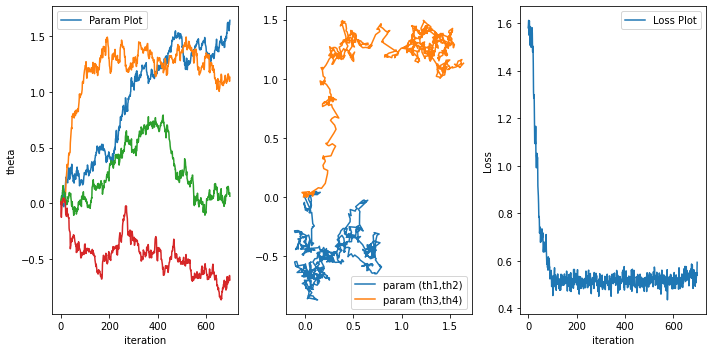

In [215]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
print('After 1000 iteration we have theta =',theta)
axes[0].plot(thdata)
axes[0].set_ylabel('theta')
axes[0].legend(['Param Plot'])
axes[0].set_xlabel('iteration')
axes[1].plot([item[2] for item in thdata],[item[3] for item in thdata],[item[0] for item in thdata],[item[1] for item in thdata])
axes[1].legend(['param (th1,th2)','param (th3,th4)'])

axes[2].plot(progress)
axes[2].legend(['Loss Plot'])
axes[2].set_ylabel('Loss')
axes[2].set_xlabel('iteration')
fig.tight_layout()

In [221]:
progress=[];

thdata=[];


l=[];
l1p=[];
l1m=[];
l1t=[];
l1=[];
c=[];

theta=[0,0,0,0];
c1=0.01  
delta=6    
ndata=200;
nshot=2000;
l1p1=[0,0,0,0];
l1m1=[0,0,0,0];

for ep in range(3000):
    delta=random.random()+1
    c2=[[c1,0,0,0],[0,c1,0,0],[0,0,c1,0],[0,0,0,c1]]
    l1p1=[0,0,0,0];
    l1m1=[0,0,0,0];
    lo=0;
    for i in range(ndata):
        l1p=[];
        l1m=[];

        for j in range(4):
            
            l1p.append(lossCal2qubit(i,theta+np.array(c2[j]),nshot))
            l1m.append(lossCal2qubit(i,theta-np.array(c2[j]),nshot))
            
        lo=np.add(lo,lossCal2qubit(i,theta,nshot))
        
        l1p1=np.add(l1p1,l1p);
        
        l1m1=np.add(l1m1,l1m);
    
    SPSA=(l1p1-l1m1)/(2*delta);
    theta=theta-SPSA;
    thdata.append(theta)
    progress.append(lo)
    print(ep,"th iteration L=",lo)

0 th iteration L= 179.02000000000004
1 th iteration L= 89.43300000000002
2 th iteration L= 82.52399999999999
3 th iteration L= 118.47900000000006
4 th iteration L= 107.592
5 th iteration L= 165.25700000000012
6 th iteration L= 160.025
7 th iteration L= 85.90399999999998
8 th iteration L= 89.41400000000004
9 th iteration L= 96.26899999999999
10 th iteration L= 86.56600000000006
11 th iteration L= 83.35199999999999
12 th iteration L= 92.69500000000004
13 th iteration L= 85.01500000000001
14 th iteration L= 90.40399999999997
15 th iteration L= 83.19299999999998
16 th iteration L= 82.56400000000004
17 th iteration L= 82.14400000000008
18 th iteration L= 82.53500000000001
19 th iteration L= 91.90900000000003
20 th iteration L= 166.44500000000008
21 th iteration L= 89.70999999999994
22 th iteration L= 228.60900000000004
23 th iteration L= 95.07800000000006
24 th iteration L= 113.903
25 th iteration L= 88.19700000000009
26 th iteration L= 118.00399999999998
27 th iteration L= 120.434999999999

227 th iteration L= 139.65900000000002
228 th iteration L= 307.7860000000002
229 th iteration L= 255.71000000000006
230 th iteration L= 82.851
231 th iteration L= 91.68000000000002
232 th iteration L= 86.03999999999999
233 th iteration L= 88.80400000000003
234 th iteration L= 86.19400000000002
235 th iteration L= 99.55100000000004
236 th iteration L= 101.81700000000002
237 th iteration L= 98.17699999999999
238 th iteration L= 111.20299999999999
239 th iteration L= 123.59400000000002
240 th iteration L= 170.83600000000007
241 th iteration L= 158.53699999999995
242 th iteration L= 93.61600000000004
243 th iteration L= 103.27200000000003
244 th iteration L= 86.042
245 th iteration L= 128.50699999999995
246 th iteration L= 95.87200000000003
247 th iteration L= 203.42499999999993
248 th iteration L= 180.78599999999992
249 th iteration L= 99.31500000000003
250 th iteration L= 82.75700000000002
251 th iteration L= 87.49899999999998
252 th iteration L= 84.1
253 th iteration L= 85.319
254 th it

449 th iteration L= 232.09799999999996
450 th iteration L= 126.02099999999992
451 th iteration L= 201.62800000000004
452 th iteration L= 133.90499999999997
453 th iteration L= 169.65499999999992
454 th iteration L= 178.77800000000013
455 th iteration L= 147.36299999999997
456 th iteration L= 237.71499999999992
457 th iteration L= 84.31500000000003
458 th iteration L= 84.779
459 th iteration L= 85.14000000000003
460 th iteration L= 92.97100000000006
461 th iteration L= 90.91700000000002
462 th iteration L= 101.486
463 th iteration L= 148.49000000000004
464 th iteration L= 97.45699999999994
465 th iteration L= 83.09100000000001
466 th iteration L= 83.26800000000004
467 th iteration L= 101.98899999999999


KeyboardInterrupt: 

After 1000 iteration we have theta = [-0.69301355  0.94203413 -7.33938625  3.46321265]


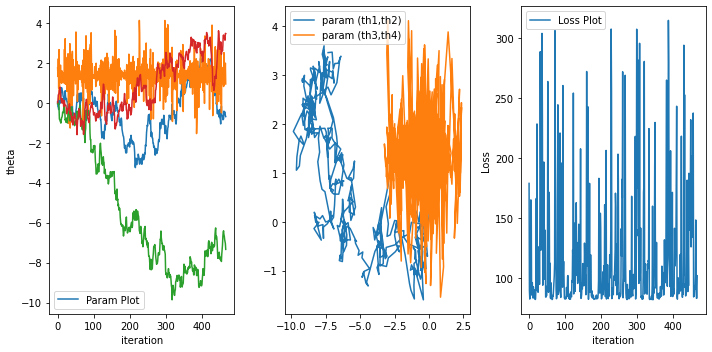

In [222]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
print('After 1000 iteration we have theta =',theta)
axes[0].plot(thdata)
axes[0].set_ylabel('theta')
axes[0].legend(['Param Plot'])
axes[0].set_xlabel('iteration')
axes[1].plot([item[2] for item in thdata],[item[3] for item in thdata],[item[0] for item in thdata],[item[1] for item in thdata])
axes[1].legend(['param (th1,th2)','param (th3,th4)'])

axes[2].plot(progress)
axes[2].legend(['Loss Plot'])
axes[2].set_ylabel('Loss')
axes[2].set_xlabel('iteration')
fig.tight_layout()

In [223]:
progress=[];

thdata=[];


l=[];
l1p=[];
l1m=[];
l1t=[];
l1=[];
c=[];

theta=[0,0,0,0];
c1=0.01  
delta=6    
ndata=200;
nshot=2000;
l1p1=[0,0,0,0];
l1m1=[0,0,0,0];

for ep in range(3000):
    delta=random.random()+1
    c2=[[c1,0,0,0],[0,c1,0,0],[0,0,c1,0],[0,0,0,c1]]
    l1p1=[0,0,0,0];
    l1m1=[0,0,0,0];
    lo=0;
    for i in range(ndata):
        l1p=[];
        l1m=[];

        for j in range(4):
            
            l1p.append(lossCal2qubit(i,theta+np.array(c2[j]),nshot))
            l1m.append(lossCal2qubit(i,theta-np.array(c2[j]),nshot))
            
        lo=np.add(lo,lossCal2qubit(i,theta,nshot))
        
        l1p1=np.add(l1p1,l1p);
        
        l1m1=np.add(l1m1,l1m);
    
    SPSA=(l1p1-l1m1)/(2*delta);
    theta=theta-SPSA;
    thdata.append(theta)
    progress.append(lo)
    print(ep,"th iteration L=",lo)

0 th iteration L= 179.39999999999984
1 th iteration L= 93.24699999999999
2 th iteration L= 82.13900000000005
3 th iteration L= 82.51999999999995
4 th iteration L= 86.51599999999996
5 th iteration L= 82.78699999999998
6 th iteration L= 86.76299999999996
7 th iteration L= 84.72100000000002
8 th iteration L= 83.003
9 th iteration L= 82.852
10 th iteration L= 83.27000000000002
11 th iteration L= 82.57499999999999
12 th iteration L= 84.396
13 th iteration L= 87.233
14 th iteration L= 83.828
15 th iteration L= 82.68000000000004
16 th iteration L= 83.41199999999998
17 th iteration L= 83.74200000000003
18 th iteration L= 83.34999999999998
19 th iteration L= 83.59299999999998
20 th iteration L= 82.607
21 th iteration L= 82.43299999999996
22 th iteration L= 86.12799999999994
23 th iteration L= 84.02899999999998
24 th iteration L= 83.10500000000002
25 th iteration L= 87.49099999999997
26 th iteration L= 83.78900000000002
27 th iteration L= 82.99399999999996
28 th iteration L= 85.20000000000003
29

230 th iteration L= 81.979
231 th iteration L= 82.907
232 th iteration L= 81.982
233 th iteration L= 82.20299999999995
234 th iteration L= 85.28999999999999
235 th iteration L= 85.03600000000002
236 th iteration L= 82.43499999999999
237 th iteration L= 82.336
238 th iteration L= 82.93500000000002
239 th iteration L= 82.63699999999999
240 th iteration L= 85.51999999999998
241 th iteration L= 83.64700000000003
242 th iteration L= 82.69799999999995
243 th iteration L= 82.305
244 th iteration L= 82.638
245 th iteration L= 84.01099999999997
246 th iteration L= 82.62900000000006
247 th iteration L= 83.00000000000001
248 th iteration L= 82.56900000000002
249 th iteration L= 82.75300000000001
250 th iteration L= 83.18299999999998
251 th iteration L= 83.19799999999995
252 th iteration L= 82.93600000000008
253 th iteration L= 82.40799999999996
254 th iteration L= 82.63099999999997
255 th iteration L= 82.42599999999996
256 th iteration L= 83.535
257 th iteration L= 82.63600000000002
258 th iterat

458 th iteration L= 82.91299999999998
459 th iteration L= 82.77000000000004
460 th iteration L= 82.27800000000002
461 th iteration L= 83.03400000000002
462 th iteration L= 83.90499999999996
463 th iteration L= 82.71900000000005
464 th iteration L= 88.17700000000005
465 th iteration L= 83.41000000000001
466 th iteration L= 83.27000000000001
467 th iteration L= 82.41099999999997
468 th iteration L= 85.166
469 th iteration L= 82.87400000000002
470 th iteration L= 82.54500000000002
471 th iteration L= 82.42300000000003
472 th iteration L= 82.38800000000003
473 th iteration L= 82.49100000000004
474 th iteration L= 84.50199999999997
475 th iteration L= 82.248
476 th iteration L= 82.70100000000004
477 th iteration L= 82.60600000000004
478 th iteration L= 82.72200000000002
479 th iteration L= 82.664
480 th iteration L= 82.21999999999998
481 th iteration L= 83.09900000000005
482 th iteration L= 82.48400000000002
483 th iteration L= 82.03499999999998
484 th iteration L= 88.80800000000002
485 th 

687 th iteration L= 82.39200000000001
688 th iteration L= 82.12300000000002
689 th iteration L= 82.97100000000006
690 th iteration L= 82.26299999999996
691 th iteration L= 82.50500000000001
692 th iteration L= 85.13099999999997
693 th iteration L= 85.95799999999997
694 th iteration L= 82.543
695 th iteration L= 83.61600000000001
696 th iteration L= 82.86199999999994
697 th iteration L= 82.60899999999998
698 th iteration L= 82.43400000000005
699 th iteration L= 81.93200000000003
700 th iteration L= 84.04399999999995
701 th iteration L= 82.50699999999998
702 th iteration L= 82.36599999999999
703 th iteration L= 83.59099999999998
704 th iteration L= 83.75200000000002
705 th iteration L= 82.382
706 th iteration L= 81.98600000000003
707 th iteration L= 85.63500000000003
708 th iteration L= 82.39300000000003
709 th iteration L= 82.724
710 th iteration L= 81.98200000000007
711 th iteration L= 82.72299999999998
712 th iteration L= 82.60800000000003
713 th iteration L= 82.048
714 th iteration L

916 th iteration L= 85.12
917 th iteration L= 100.98700000000004
918 th iteration L= 83.28900000000002
919 th iteration L= 82.55299999999997
920 th iteration L= 82.35299999999997
921 th iteration L= 83.73599999999999
922 th iteration L= 84.96600000000001
923 th iteration L= 82.569
924 th iteration L= 83.46199999999997
925 th iteration L= 87.81700000000008
926 th iteration L= 82.44800000000002
927 th iteration L= 82.29099999999995
928 th iteration L= 82.643
929 th iteration L= 82.74999999999996
930 th iteration L= 82.44399999999999
931 th iteration L= 82.54800000000004
932 th iteration L= 82.62400000000002
933 th iteration L= 82.04399999999997
934 th iteration L= 82.286
935 th iteration L= 83.37700000000004
936 th iteration L= 84.734
937 th iteration L= 85.089
938 th iteration L= 82.67800000000003
939 th iteration L= 84.057
940 th iteration L= 83.33800000000002
941 th iteration L= 82.673
942 th iteration L= 82.63100000000001
943 th iteration L= 82.27700000000002
944 th iteration L= 82.2

1140 th iteration L= 83.079
1141 th iteration L= 82.43100000000001
1142 th iteration L= 82.94800000000001
1143 th iteration L= 82.81599999999999
1144 th iteration L= 83.24600000000002
1145 th iteration L= 82.423
1146 th iteration L= 85.77999999999997
1147 th iteration L= 82.14499999999998
1148 th iteration L= 82.442
1149 th iteration L= 82.40300000000002
1150 th iteration L= 82.08400000000007
1151 th iteration L= 82.45300000000002
1152 th iteration L= 83.56899999999997
1153 th iteration L= 82.326
1154 th iteration L= 82.56800000000003
1155 th iteration L= 82.23200000000004
1156 th iteration L= 82.30099999999995
1157 th iteration L= 82.45099999999996
1158 th iteration L= 82.164
1159 th iteration L= 85.768
1160 th iteration L= 82.88600000000004
1161 th iteration L= 82.513
1162 th iteration L= 82.137
1163 th iteration L= 83.17099999999999
1164 th iteration L= 83.40100000000002
1165 th iteration L= 83.482
1166 th iteration L= 82.17100000000002
1167 th iteration L= 83.42900000000003
1168 th

1362 th iteration L= 84.29700000000001
1363 th iteration L= 82.0449999999999
1364 th iteration L= 82.70600000000002
1365 th iteration L= 89.15399999999998
1366 th iteration L= 85.22800000000001
1367 th iteration L= 84.64900000000003
1368 th iteration L= 85.30799999999996
1369 th iteration L= 83.19299999999998
1370 th iteration L= 82.70900000000003
1371 th iteration L= 82.68200000000002
1372 th iteration L= 85.17400000000002
1373 th iteration L= 85.05799999999999
1374 th iteration L= 84.30600000000001
1375 th iteration L= 83.71000000000001
1376 th iteration L= 84.55200000000006
1377 th iteration L= 82.71299999999995
1378 th iteration L= 82.54699999999994
1379 th iteration L= 83.77900000000005
1380 th iteration L= 82.45899999999999
1381 th iteration L= 82.23300000000002
1382 th iteration L= 83.10999999999997
1383 th iteration L= 85.20700000000002
1384 th iteration L= 82.524
1385 th iteration L= 81.89399999999998
1386 th iteration L= 82.67699999999995
1387 th iteration L= 83.2310000000000

1580 th iteration L= 82.81900000000002
1581 th iteration L= 82.91699999999999
1582 th iteration L= 83.67100000000003
1583 th iteration L= 86.601
1584 th iteration L= 82.99699999999996
1585 th iteration L= 83.16800000000003
1586 th iteration L= 82.834
1587 th iteration L= 82.831
1588 th iteration L= 85.41200000000002
1589 th iteration L= 86.40500000000002
1590 th iteration L= 83.42700000000004
1591 th iteration L= 82.74600000000005
1592 th iteration L= 84.37399999999998
1593 th iteration L= 82.28100000000005
1594 th iteration L= 82.97900000000001
1595 th iteration L= 82.37200000000003
1596 th iteration L= 84.648
1597 th iteration L= 84.597
1598 th iteration L= 83.291
1599 th iteration L= 83.37600000000002
1600 th iteration L= 86.75800000000001
1601 th iteration L= 82.43499999999997
1602 th iteration L= 81.97399999999996
1603 th iteration L= 84.46200000000007
1604 th iteration L= 82.42499999999993
1605 th iteration L= 82.16799999999999
1606 th iteration L= 83.997
1607 th iteration L= 81.

1803 th iteration L= 83.85100000000003
1804 th iteration L= 84.41799999999999
1805 th iteration L= 83.96799999999995
1806 th iteration L= 84.04900000000005
1807 th iteration L= 85.742
1808 th iteration L= 82.55799999999998
1809 th iteration L= 86.00799999999998
1810 th iteration L= 82.19600000000007
1811 th iteration L= 82.30899999999998
1812 th iteration L= 82.67400000000005
1813 th iteration L= 83.04499999999999
1814 th iteration L= 83.76000000000005
1815 th iteration L= 82.12
1816 th iteration L= 83.974
1817 th iteration L= 83.35400000000003
1818 th iteration L= 82.611
1819 th iteration L= 83.00999999999999
1820 th iteration L= 84.54499999999996
1821 th iteration L= 82.70600000000006
1822 th iteration L= 82.76399999999998
1823 th iteration L= 82.44400000000002
1824 th iteration L= 82.29300000000003
1825 th iteration L= 93.79900000000004
1826 th iteration L= 82.54799999999997
1827 th iteration L= 82.71000000000002
1828 th iteration L= 83.12700000000001
1829 th iteration L= 82.738
183

2026 th iteration L= 82.59499999999994
2027 th iteration L= 82.75700000000002
2028 th iteration L= 82.59200000000003
2029 th iteration L= 95.32799999999997
2030 th iteration L= 86.62100000000004
2031 th iteration L= 86.75899999999993
2032 th iteration L= 86.10900000000001
2033 th iteration L= 82.49099999999999
2034 th iteration L= 83.8800000000001
2035 th iteration L= 82.33500000000005
2036 th iteration L= 86.19500000000001
2037 th iteration L= 82.703
2038 th iteration L= 82.35700000000001
2039 th iteration L= 83.06999999999998
2040 th iteration L= 82.61400000000002
2041 th iteration L= 84.00900000000001
2042 th iteration L= 82.80800000000002
2043 th iteration L= 82.483
2044 th iteration L= 82.54799999999999
2045 th iteration L= 82.69499999999998
2046 th iteration L= 82.05800000000002
2047 th iteration L= 83.15599999999999
2048 th iteration L= 82.35700000000004
2049 th iteration L= 82.75600000000004
2050 th iteration L= 84.884
2051 th iteration L= 82.66800000000002
2052 th iteration L=

2247 th iteration L= 82.19800000000004
2248 th iteration L= 83.22200000000002
2249 th iteration L= 82.06000000000002
2250 th iteration L= 82.32400000000004
2251 th iteration L= 82.72299999999997
2252 th iteration L= 83.27299999999994
2253 th iteration L= 82.51199999999999
2254 th iteration L= 82.74399999999997
2255 th iteration L= 82.21500000000002
2256 th iteration L= 84.42200000000003
2257 th iteration L= 82.98599999999996
2258 th iteration L= 82.45700000000001
2259 th iteration L= 82.23600000000006
2260 th iteration L= 83.34700000000002
2261 th iteration L= 82.2800000000001
2262 th iteration L= 82.40100000000008
2263 th iteration L= 89.156
2264 th iteration L= 82.94099999999999
2265 th iteration L= 82.77900000000001
2266 th iteration L= 85.78200000000004
2267 th iteration L= 81.85799999999999
2268 th iteration L= 82.53900000000002
2269 th iteration L= 84.16900000000005
2270 th iteration L= 82.69600000000004
2271 th iteration L= 83.02099999999994
2272 th iteration L= 83.3250000000000

2467 th iteration L= 83.575
2468 th iteration L= 82.83400000000002
2469 th iteration L= 84.37799999999997
2470 th iteration L= 82.76399999999998
2471 th iteration L= 83.46600000000008
2472 th iteration L= 82.63600000000005
2473 th iteration L= 82.69300000000001
2474 th iteration L= 90.92899999999995
2475 th iteration L= 84.06699999999996
2476 th iteration L= 82.60499999999995
2477 th iteration L= 83.34300000000002
2478 th iteration L= 82.82900000000001
2479 th iteration L= 81.87900000000006
2480 th iteration L= 82.87900000000002
2481 th iteration L= 82.43
2482 th iteration L= 83.85899999999995
2483 th iteration L= 83.28500000000001
2484 th iteration L= 82.31600000000002
2485 th iteration L= 85.76799999999997
2486 th iteration L= 83.07699999999997
2487 th iteration L= 82.90399999999997
2488 th iteration L= 82.60099999999998
2489 th iteration L= 82.54199999999997
2490 th iteration L= 85.16199999999999
2491 th iteration L= 82.55700000000007
2492 th iteration L= 85.71499999999992
2493 th i

KeyboardInterrupt: 

After 1000 iteration we have theta = [ 6.57745625  1.33666644 -6.48763431  1.22216345]


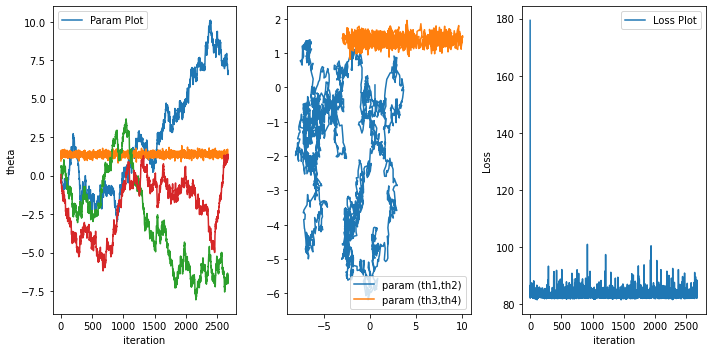

In [224]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
print('After 1000 iteration we have theta =',theta)
axes[0].plot(thdata)
axes[0].set_ylabel('theta')
axes[0].legend(['Param Plot'])
axes[0].set_xlabel('iteration')
axes[1].plot([item[2] for item in thdata],[item[3] for item in thdata],[item[0] for item in thdata],[item[1] for item in thdata])
axes[1].legend(['param (th1,th2)','param (th3,th4)'])

axes[2].plot(progress)
axes[2].legend(['Loss Plot'])
axes[2].set_ylabel('Loss')
axes[2].set_xlabel('iteration')
fig.tight_layout()